In [1]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import logging
import sys
import re
from tqdm import tqdm
from IPython.display import HTML
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import clip
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import pathlib
import json
from datasets import _transform, get_full_class_labels, fix_class_names, idx_to_label, CUBDataset
openai.api_key  = os.getenv('OPENAI_API_KEY')

# Dataset

In [2]:
CUB_DIR = '/home/kush/Desktop/CLIP/CUB/CUB_200_2011' # REPLACE THIS WITH YOUR OWN PATH
# load CUB dataset
data_dir = pathlib.Path(CUB_DIR)
cub_dataset = CUBDataset(data_dir, train=True, transform=_transform(224))

/home/kush/anaconda3/envs/kush/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


# Load model

In [1]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

NameError: name 'torch' is not defined

# Function for computing Label text emebddings

In [6]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

# Function for index to label

In [7]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [8]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [9]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [51]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list):
    print(pred_index_list.size())
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx]))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

# Calculate CLIP accuracy

In [49]:
def calc_acc(model, dataset, descriptions, batch_size = 64*10, count_classes = False, 
             topK = 5):

    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    encodings = compute_encodings(model, dataset.classes)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_topk = torchmetrics.Accuracy(top_k=topK, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        topk_values, topk_indices = image_labels_similarity.topk(topK, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_topk = clip_accuracy_metric_topk(image_labels_similarity, labels)
        
        
        if count_classes == True:
            count_classes_dict = add_to_counter_dict(count_classes_dict, index_to_class_dict,
                                                 labels, topk_indices)

    # Make Top k 1 again

    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    if topK > 1:
        accuracy_logs[f"Total CLIP-Standard Top-{topK} Accuracy: "] = 100*clip_accuracy_metric_topk.compute().item()
    
    if count_classes == True:
        for actual_key in count_classes_dict.keys():
            count_classes_dict[actual_key] = sorted(count_classes_dict[actual_key].items(),
                                                key=lambda x: x[1], reverse=True)

        json_string = json.dumps(count_classes_dict, indent=4)  # indent for pretty formatting

        # Write JSON string to a text file
        with open(f'top{topK}.txt', 'w') as file:
            file.write(json_string)

    
    return accuracy_logs

In [52]:
calc_acc(model, cub_dataset, cub_dataset.classes,
         count_classes = True, topK = 1)

 10%|███████████▍                                                                                                      | 1/10 [00:18<02:45, 18.43s/it]

torch.Size([640, 1])


 30%|██████████████████████████████████▏                                                                               | 3/10 [00:18<00:30,  4.31s/it]

torch.Size([640, 1])
torch.Size([640, 1])


 50%|█████████████████████████████████████████████████████████                                                         | 5/10 [00:19<00:08,  1.77s/it]

torch.Size([640, 1])
torch.Size([640, 1])


 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 7/10 [00:19<00:02,  1.13it/s]

torch.Size([640, 1])
torch.Size([640, 1])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9/10 [00:19<00:00,  1.97it/s]

torch.Size([640, 1])
torch.Size([640, 1])
torch.Size([234, 1])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


{'Total CLIP-Standard Top-1 Accuracy: ': 49.582916498184204}

# Graphs

In [53]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


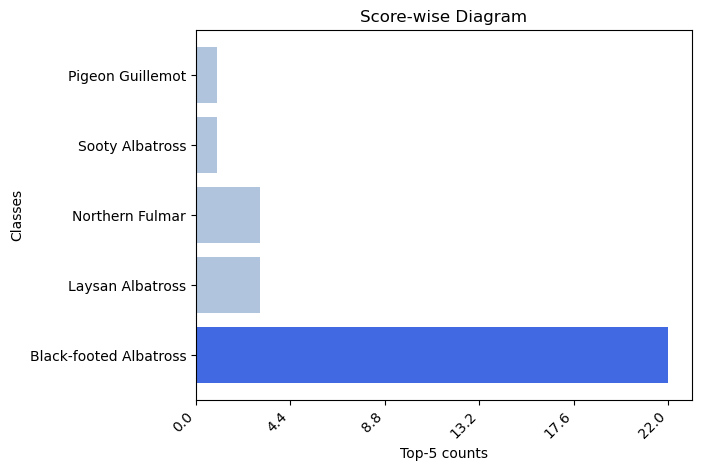

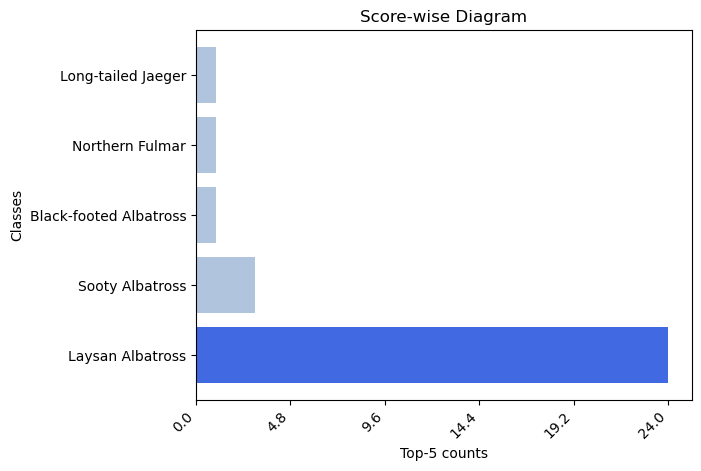

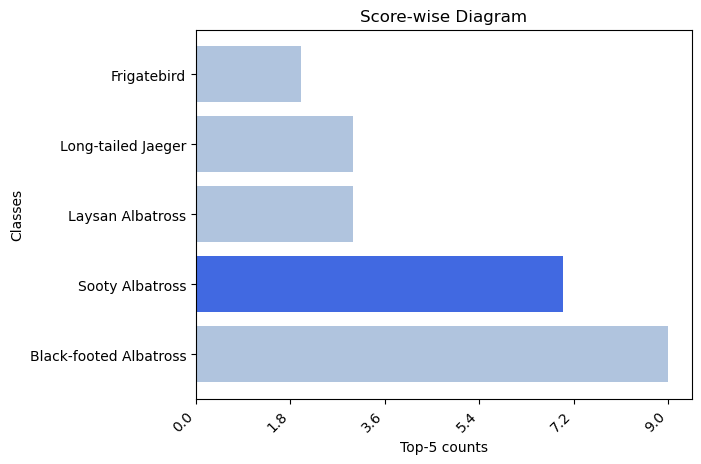

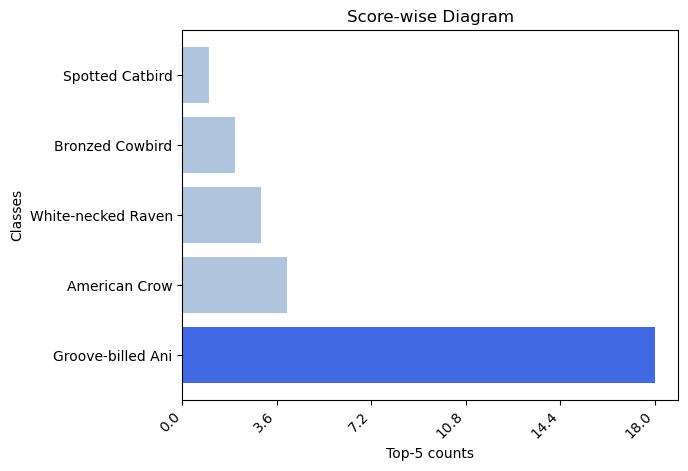

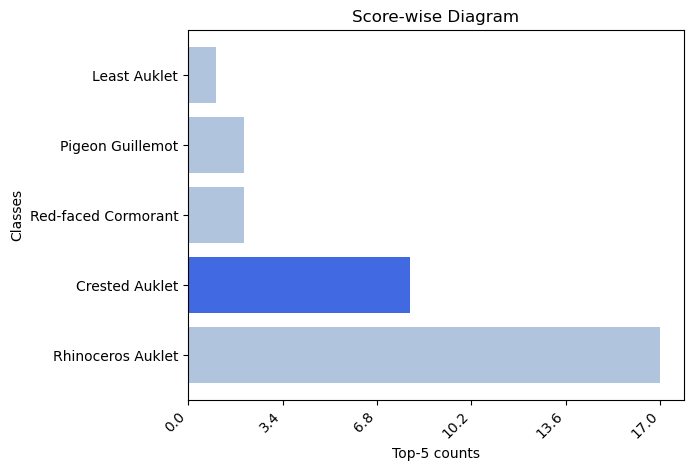

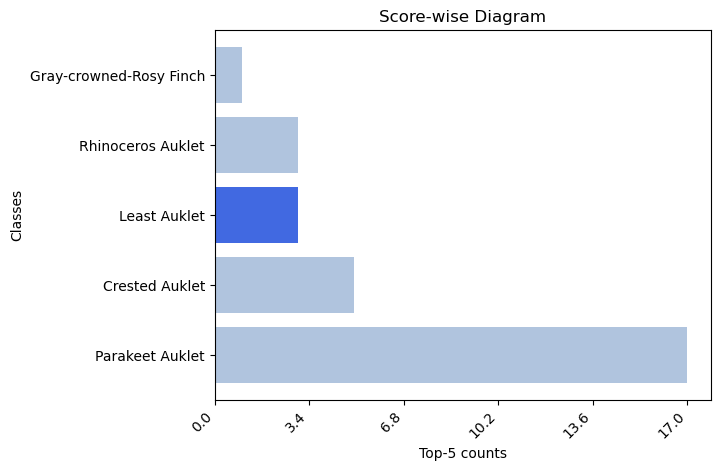

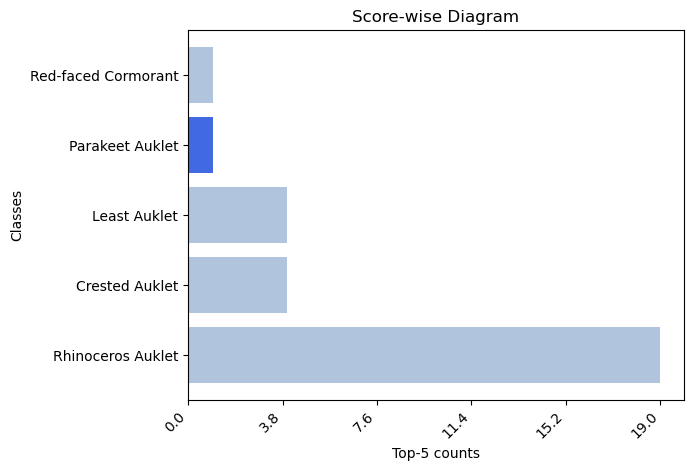

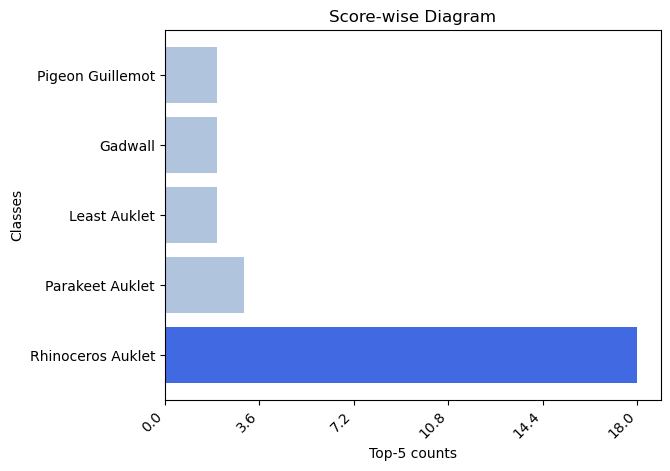

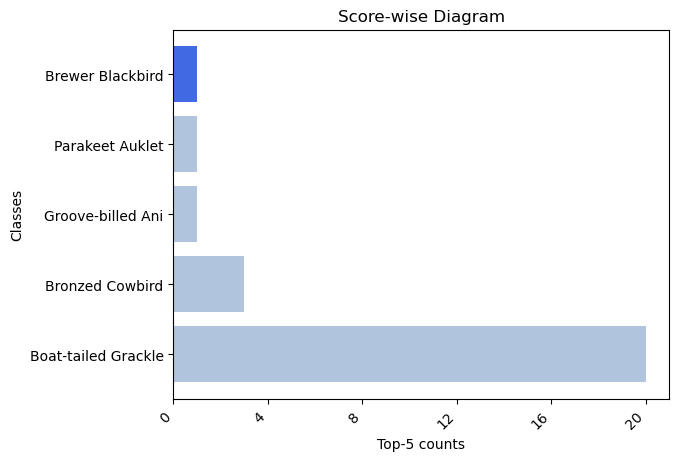

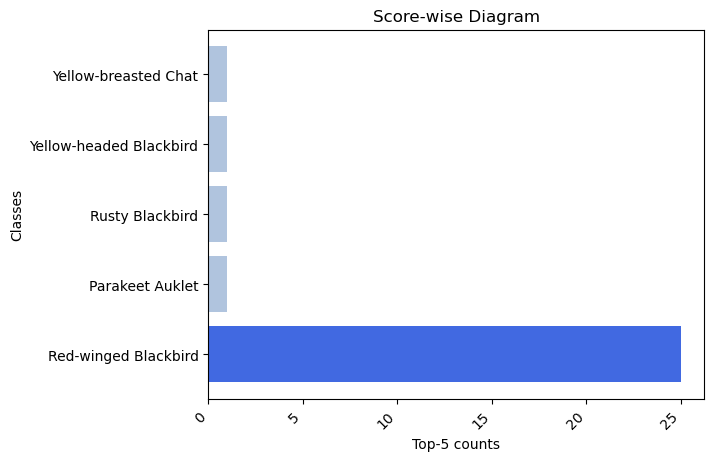

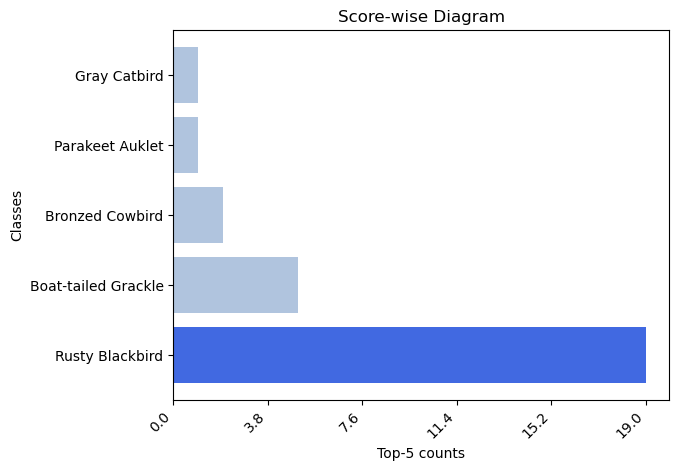

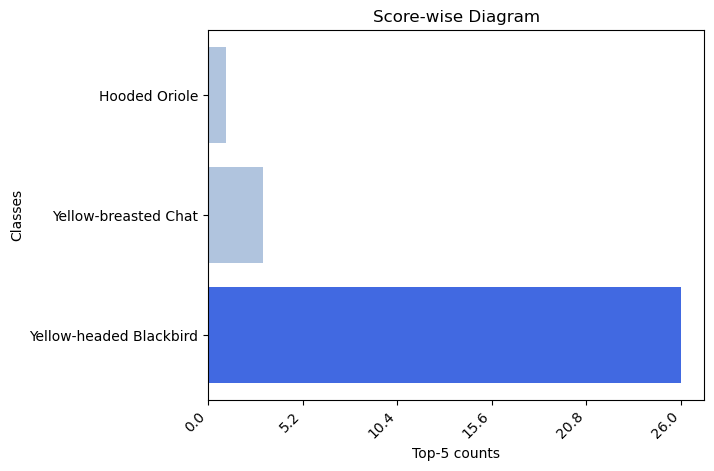

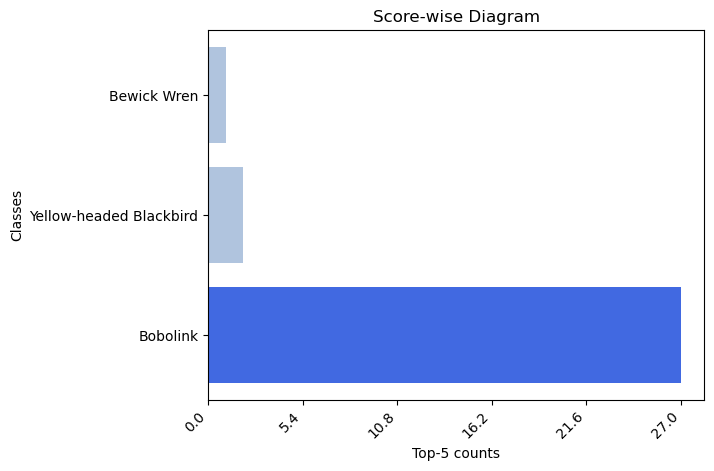

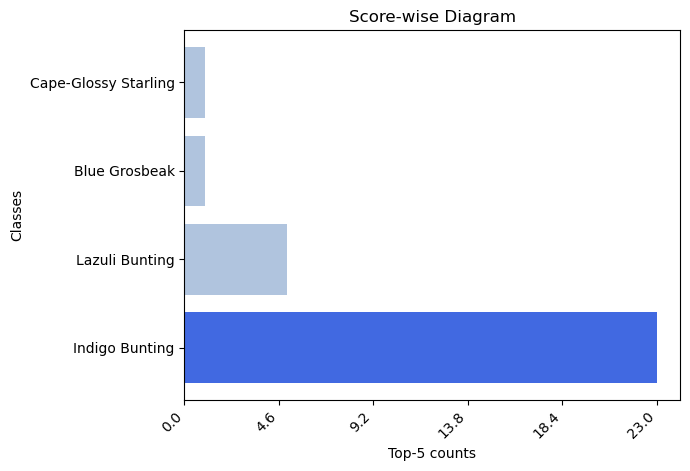

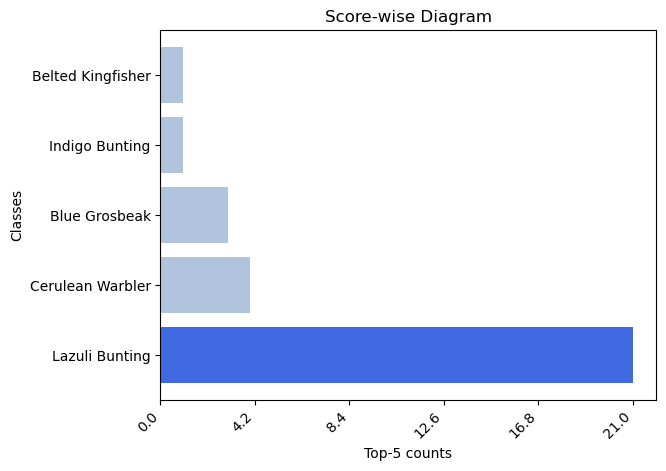

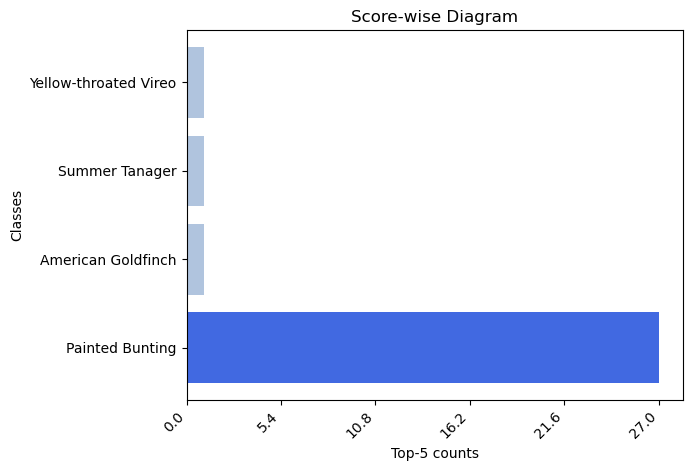

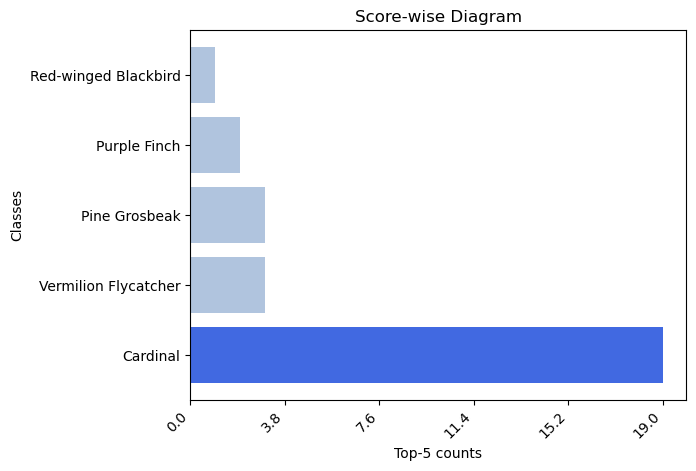

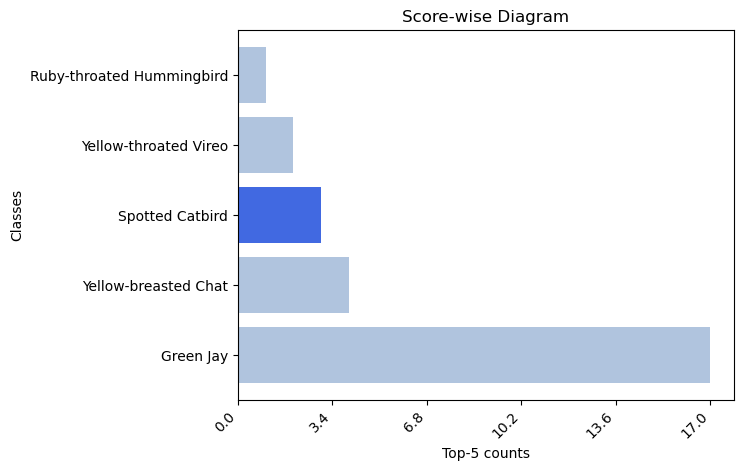

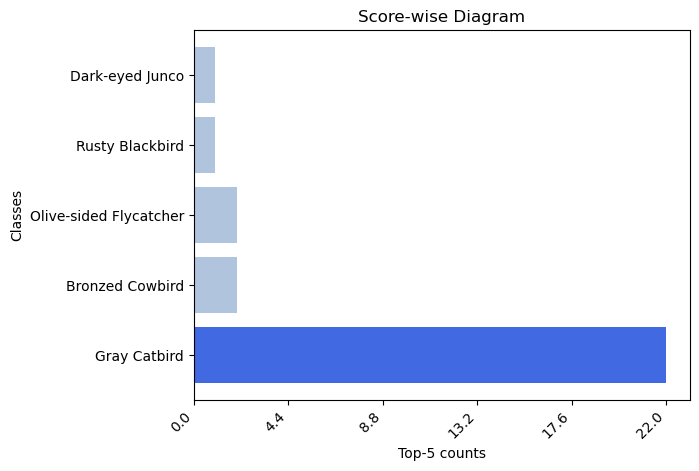

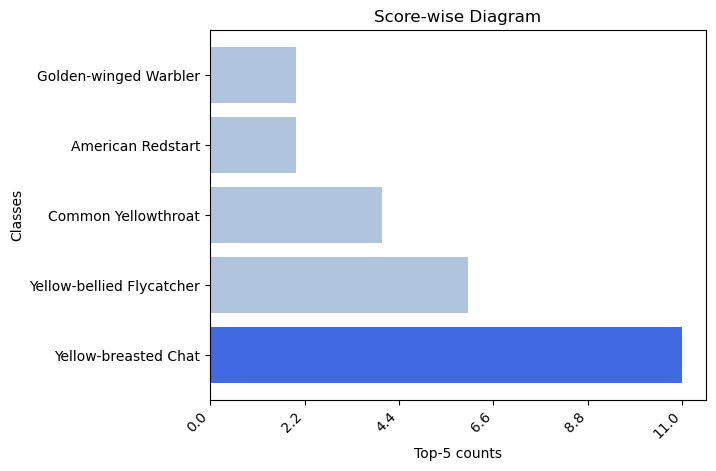

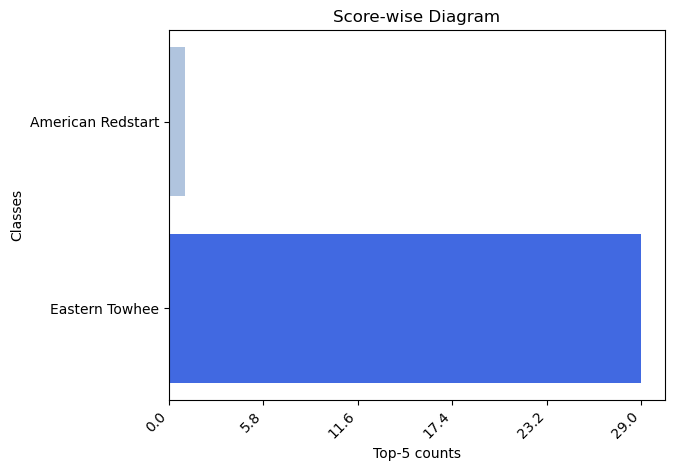

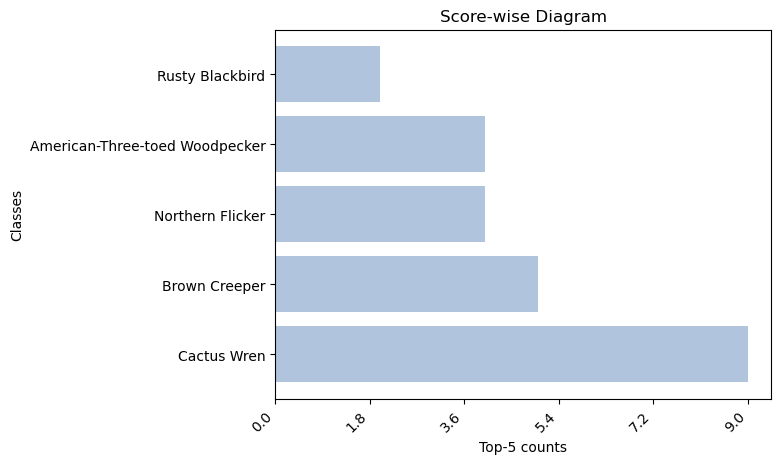

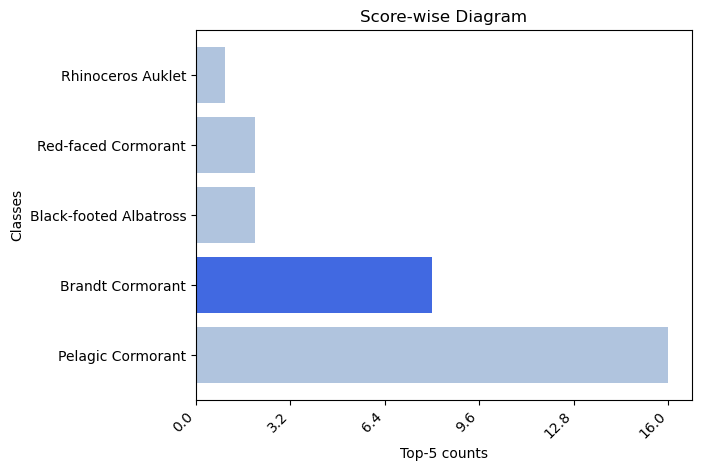

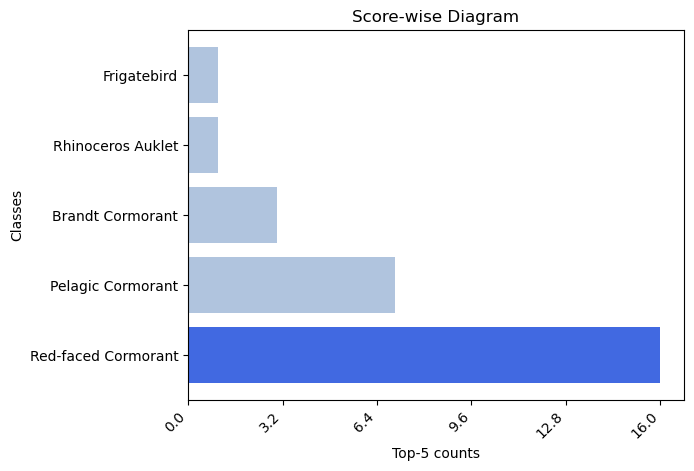

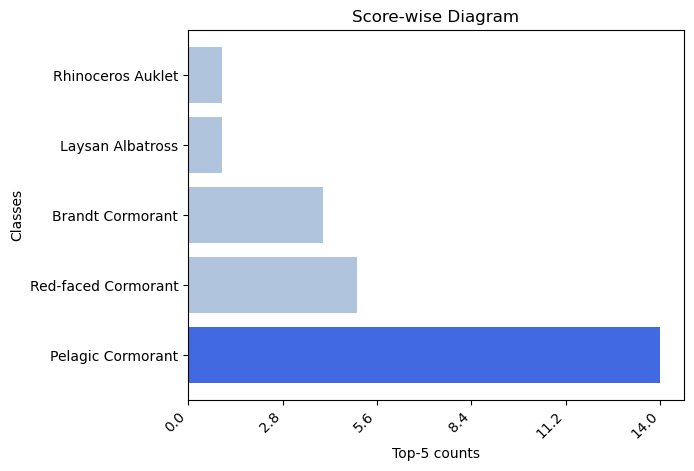

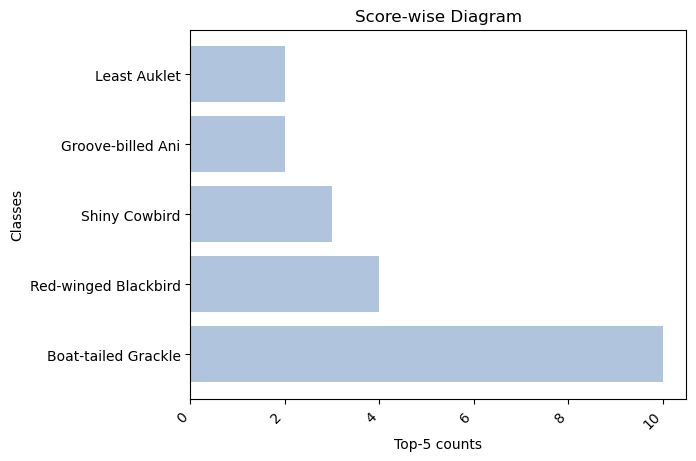

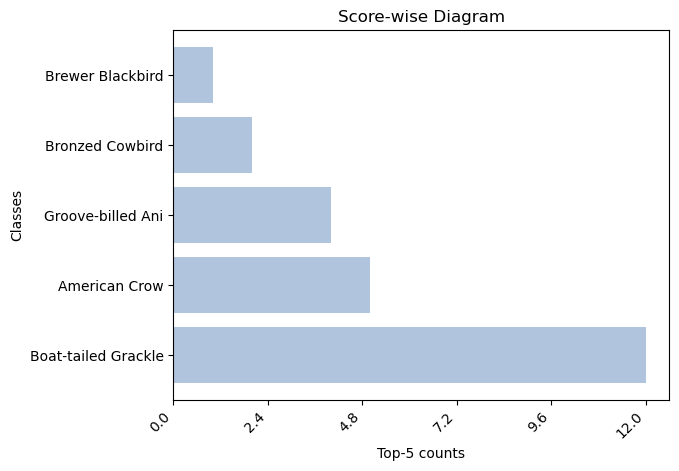

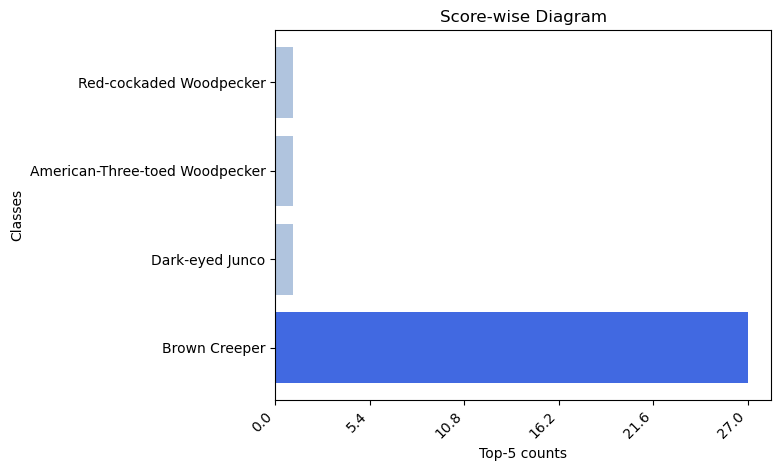

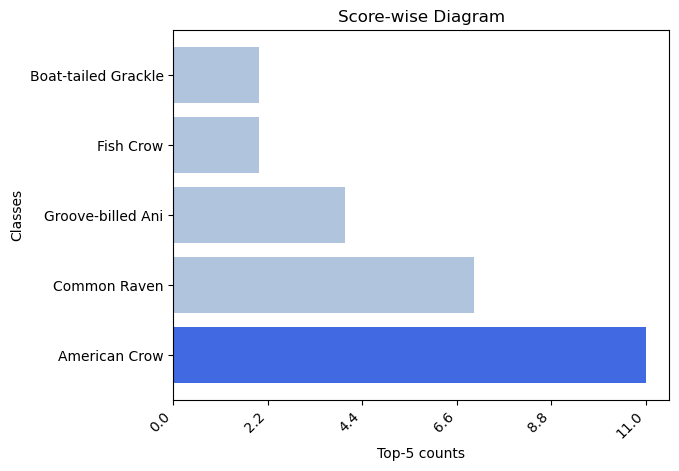

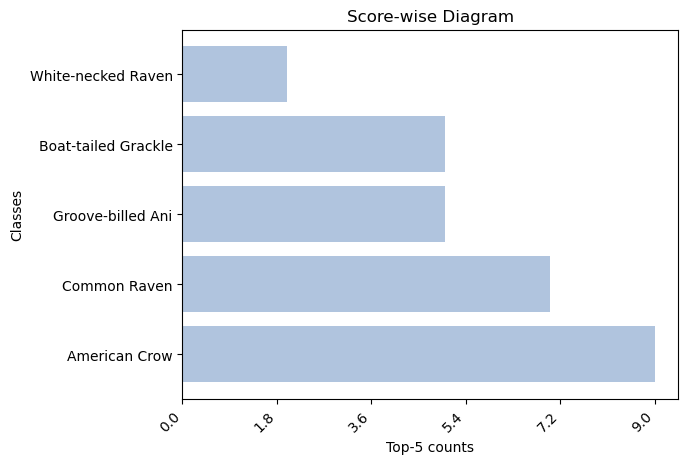

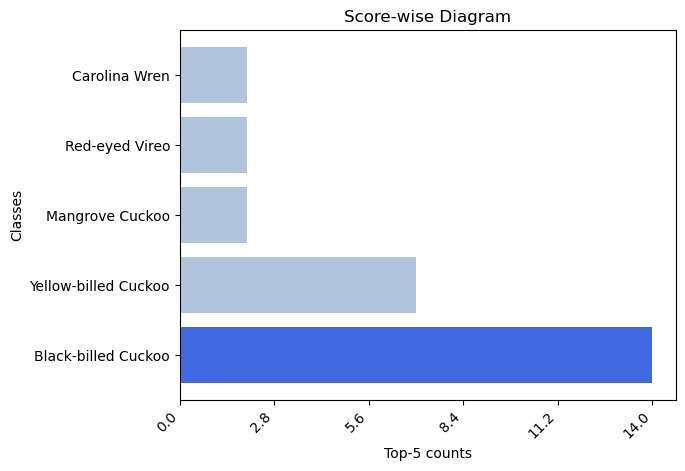

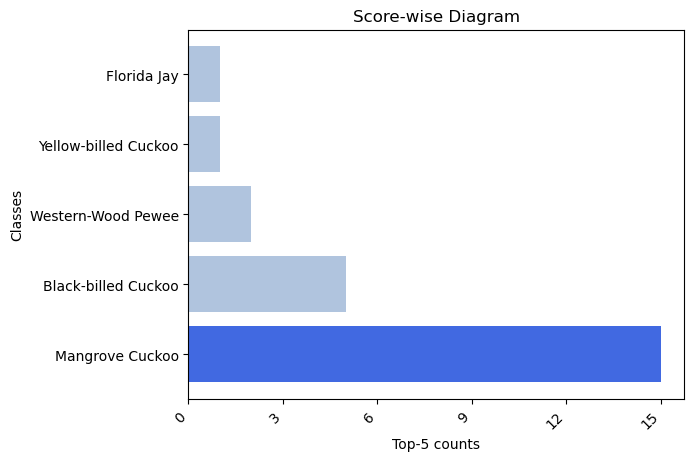

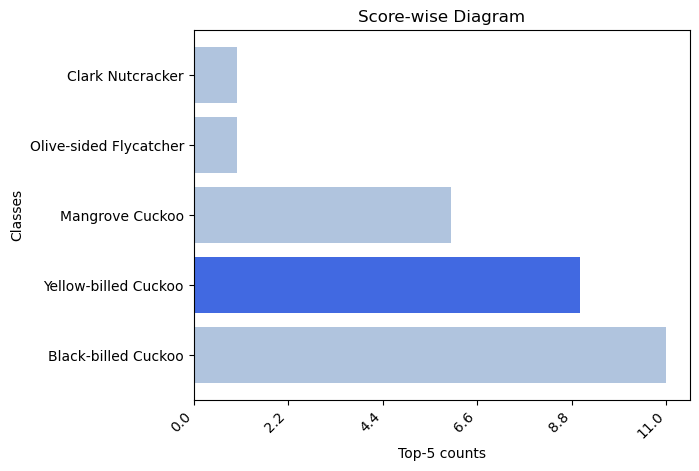

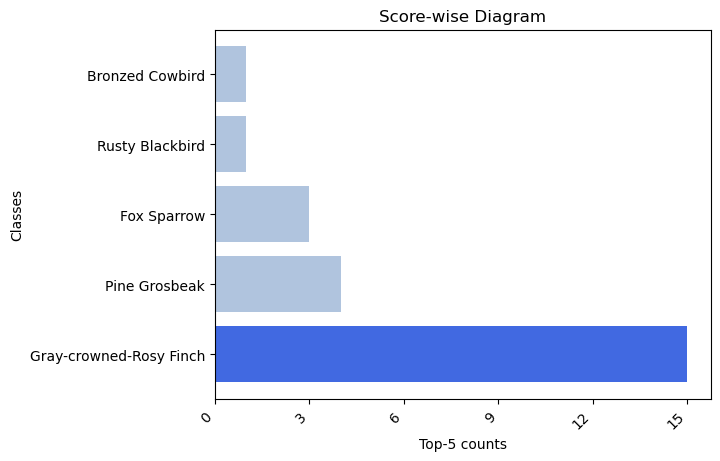

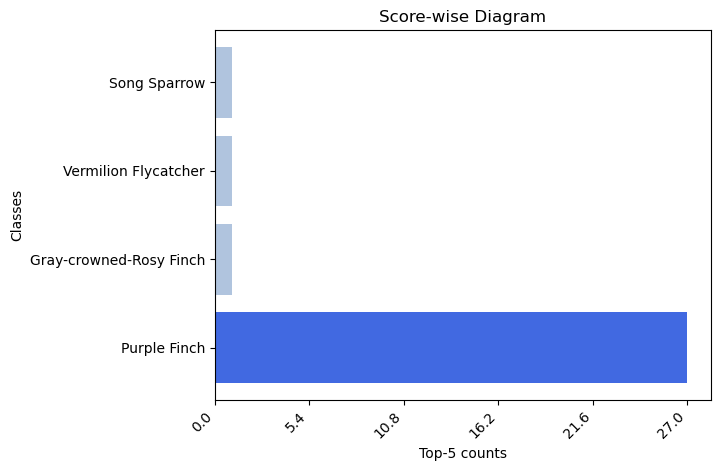

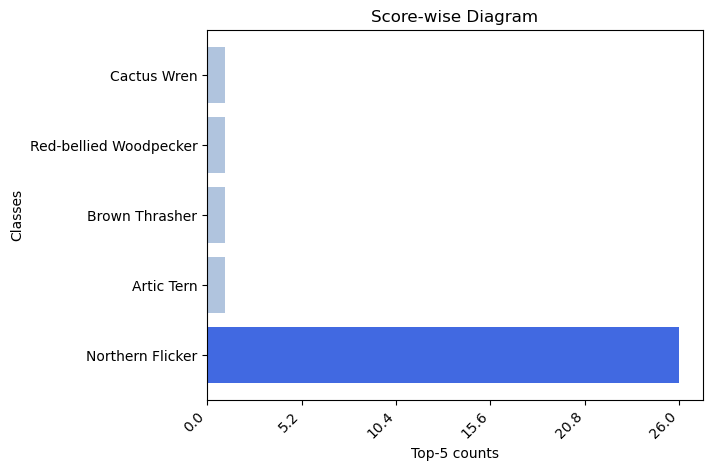

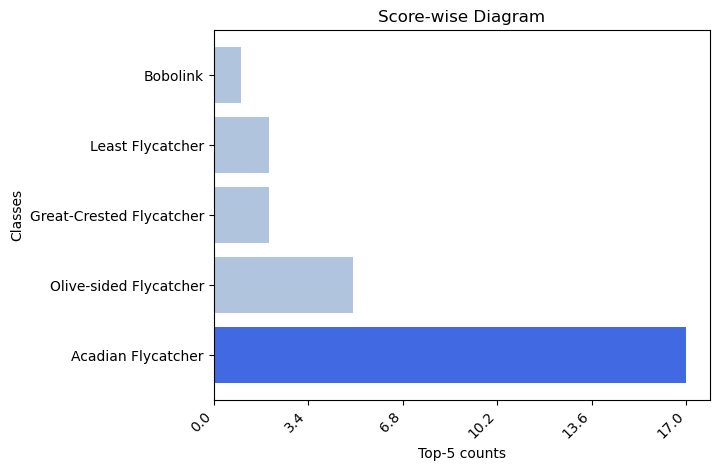

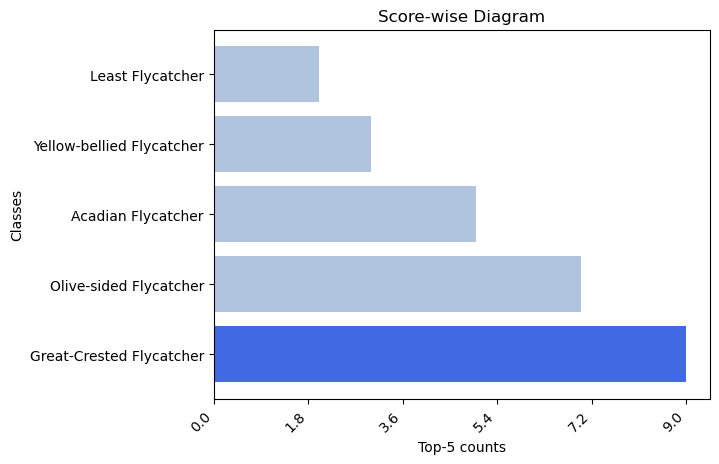

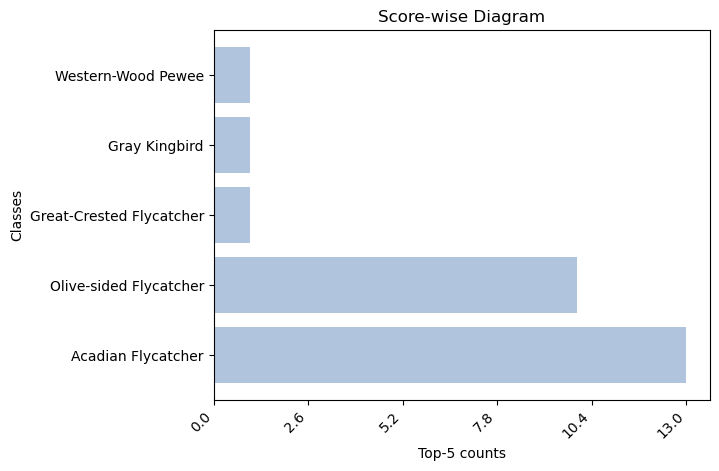

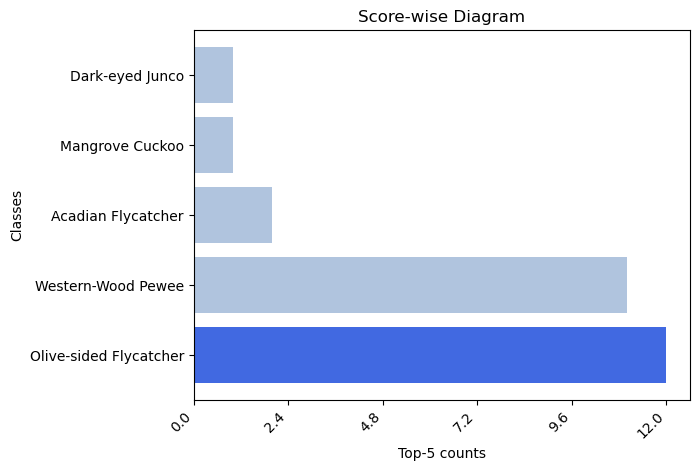

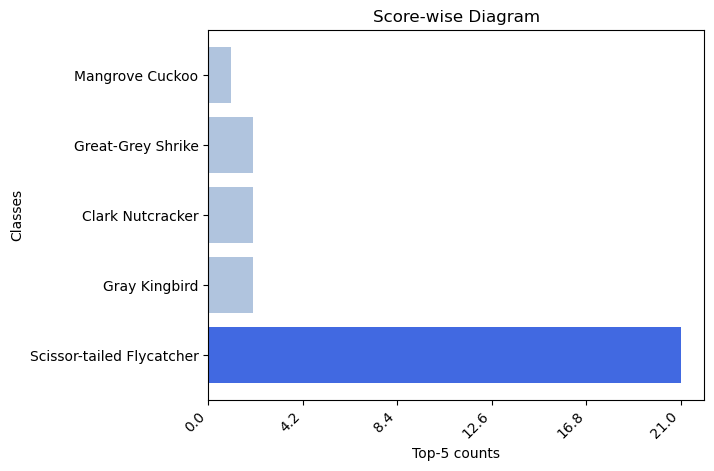

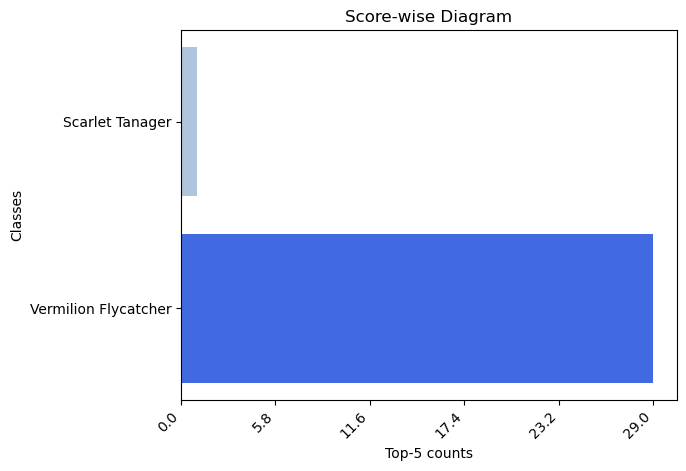

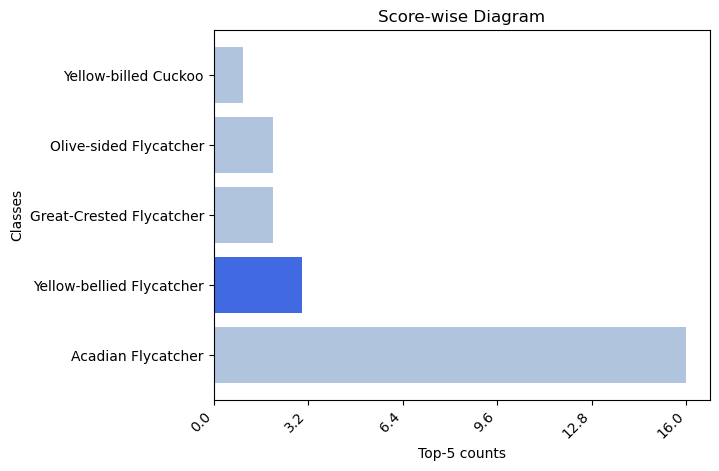

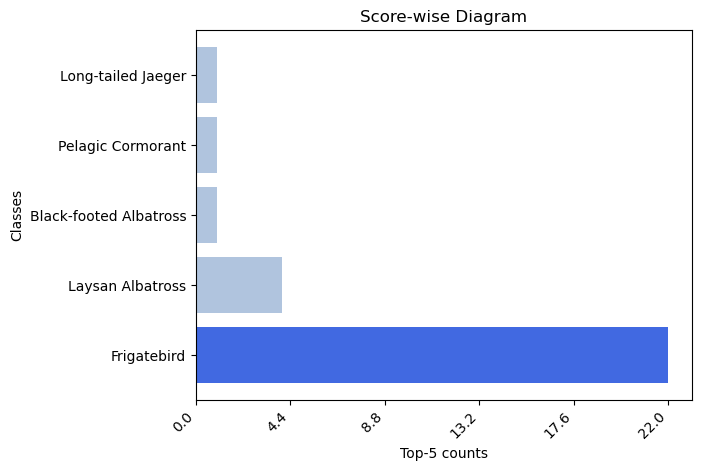

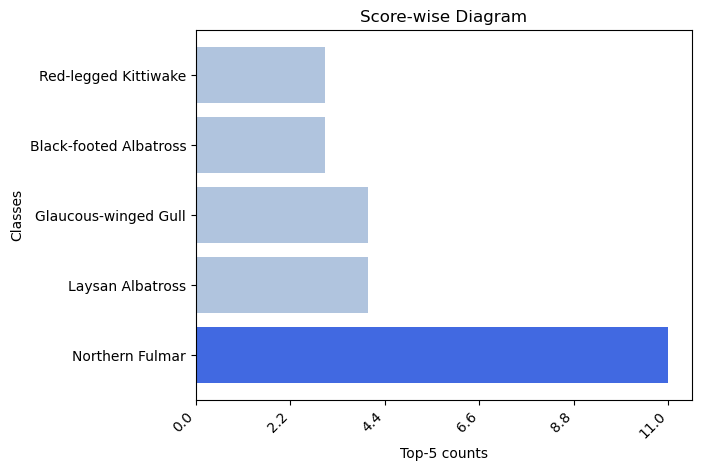

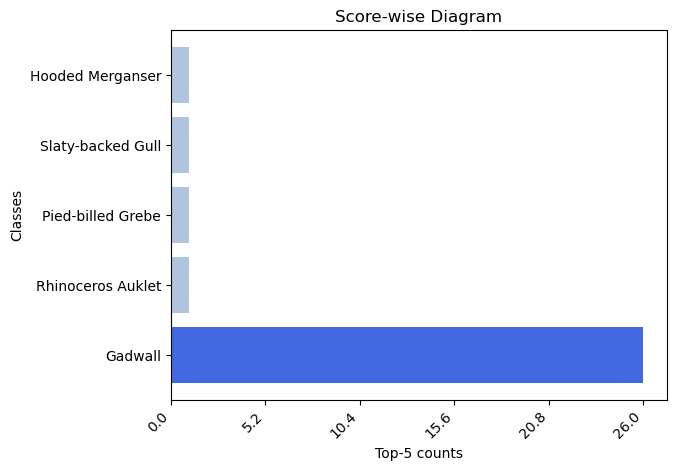

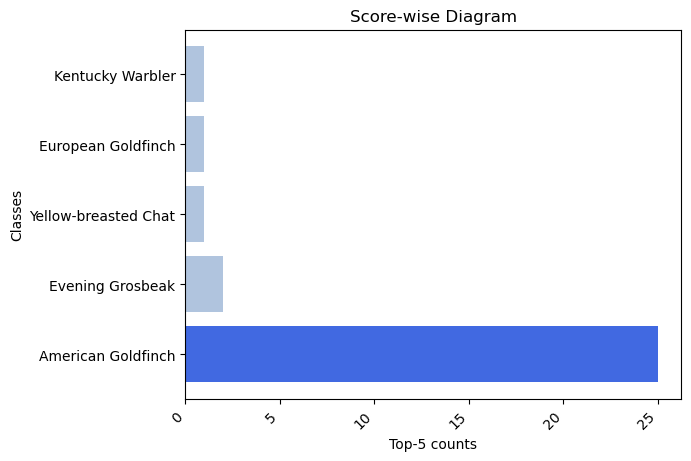

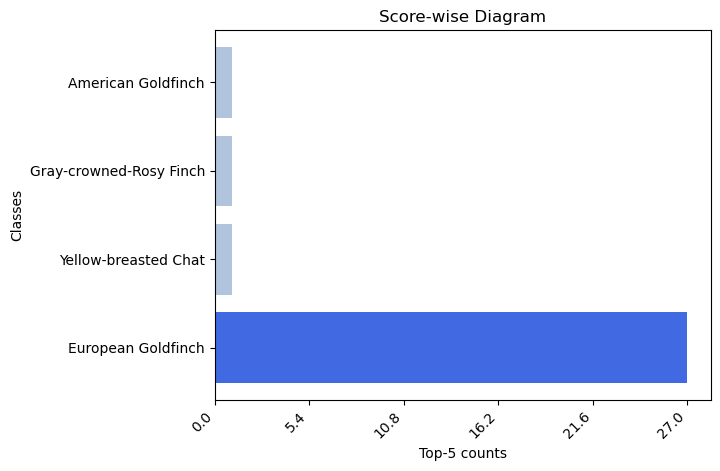

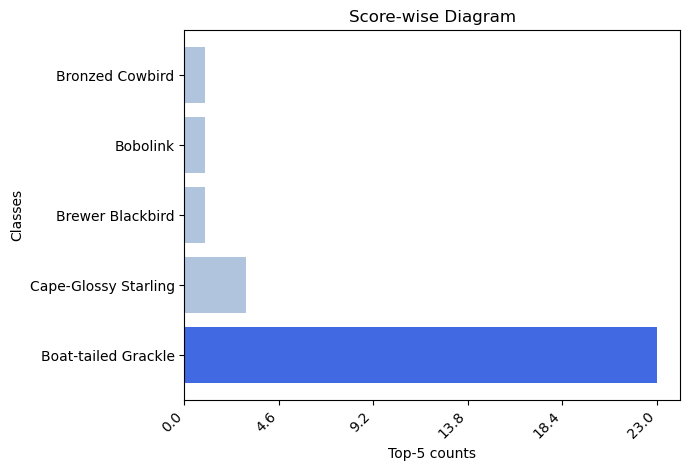

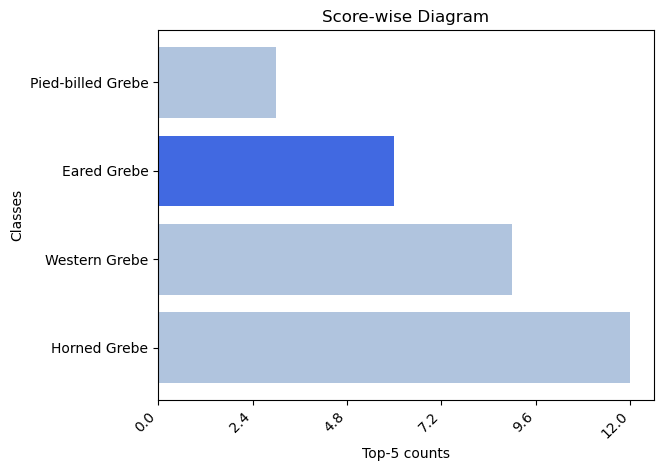

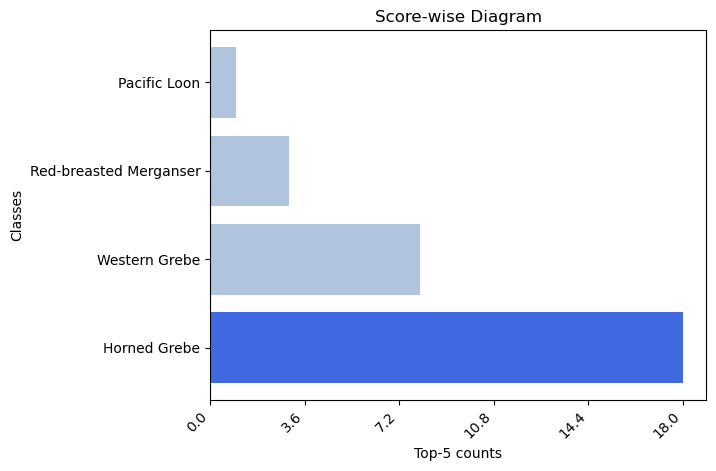

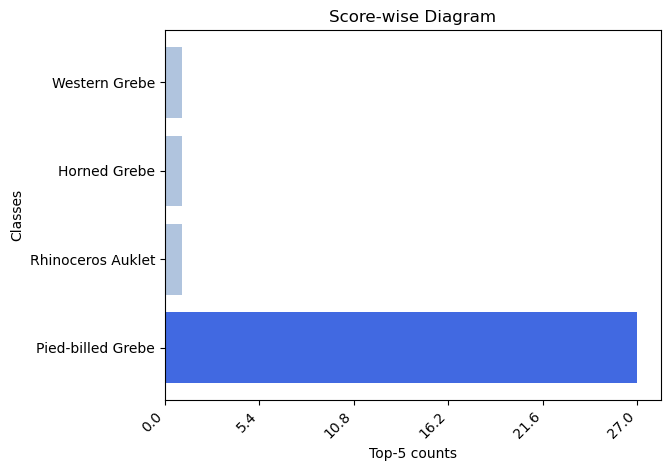

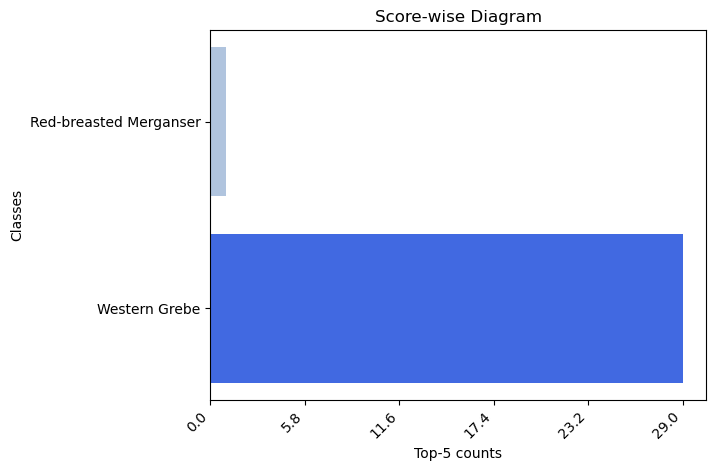

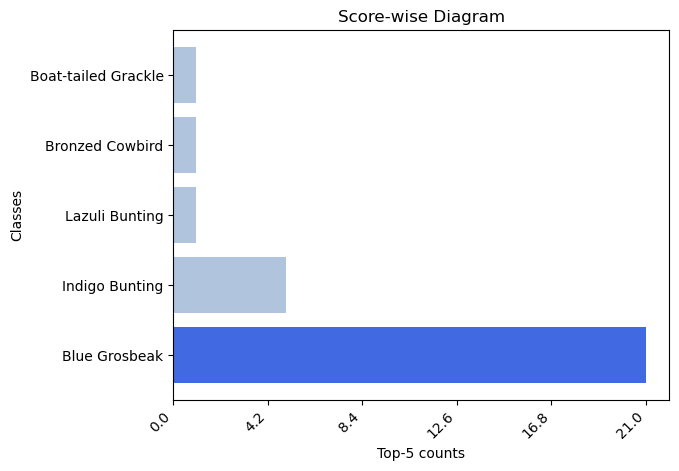

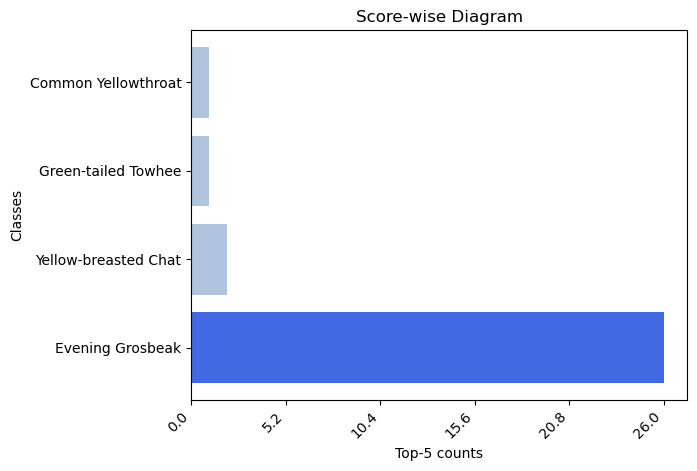

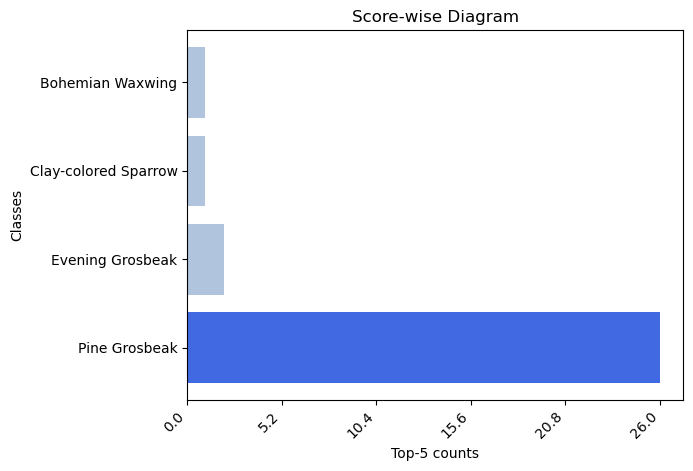

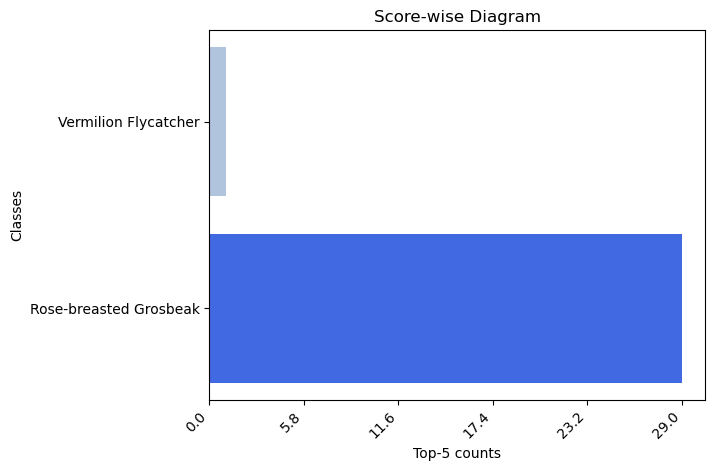

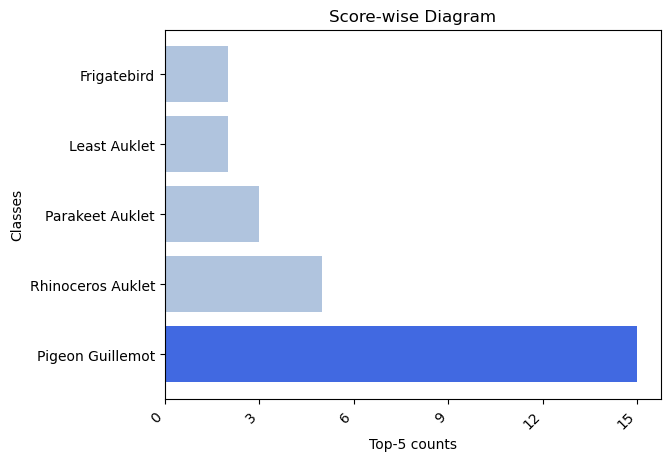

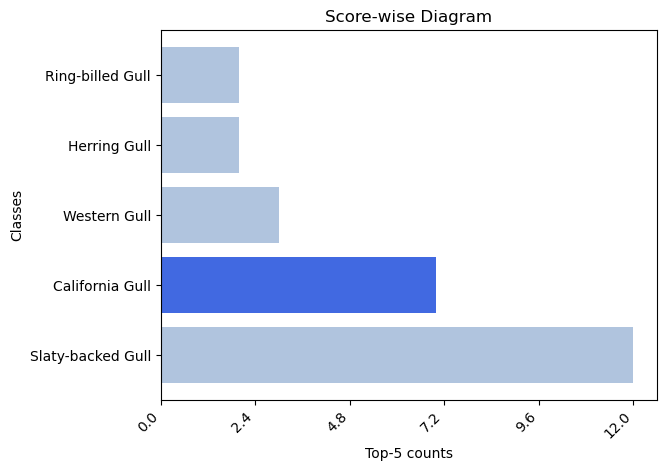

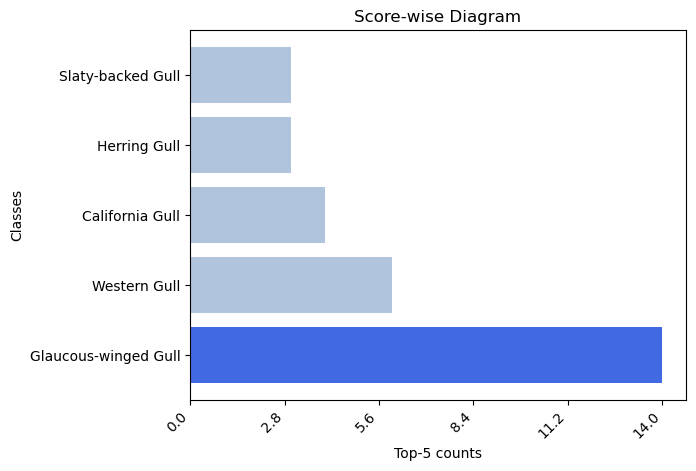

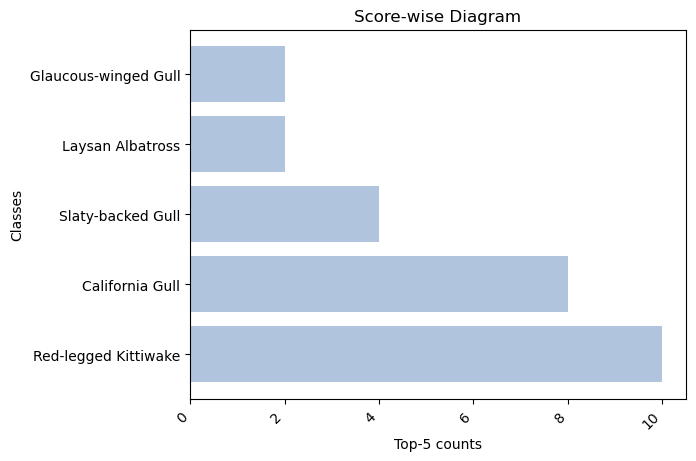

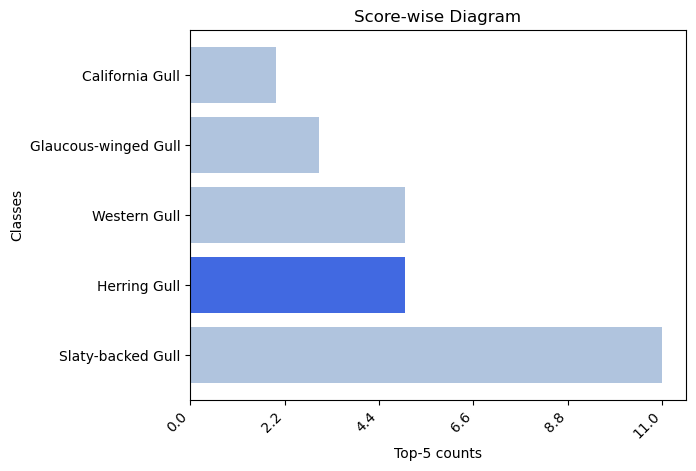

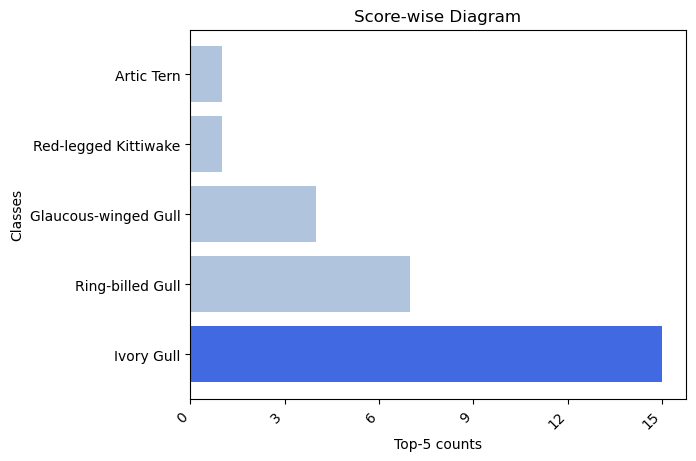

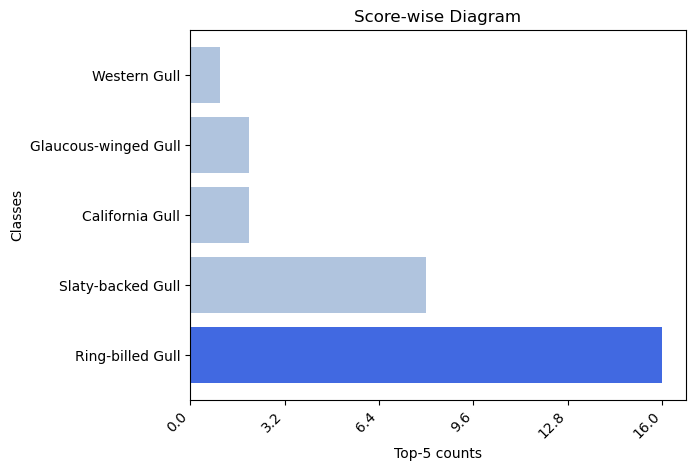

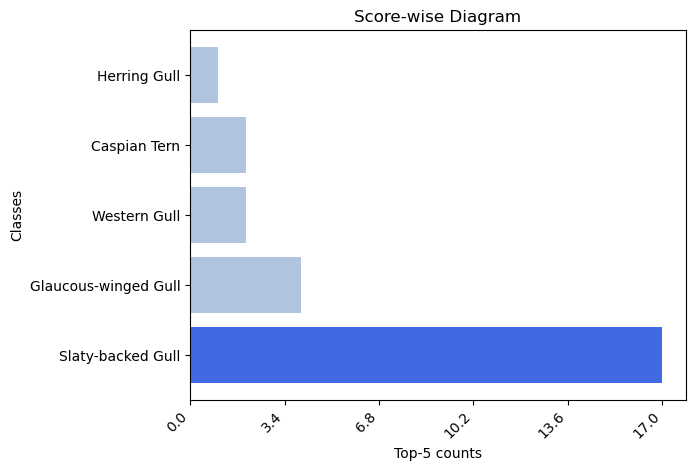

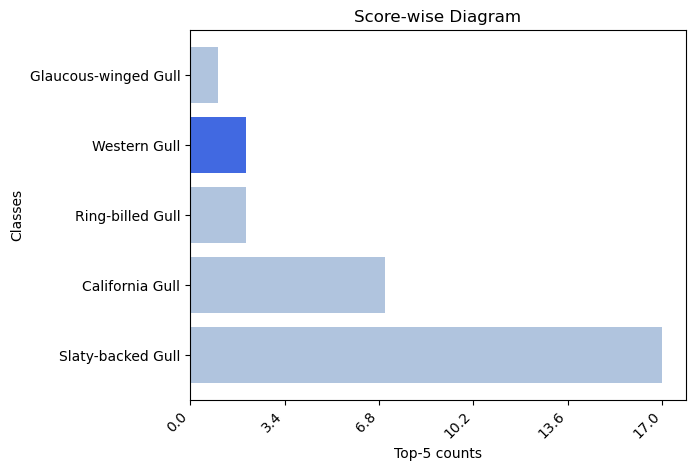

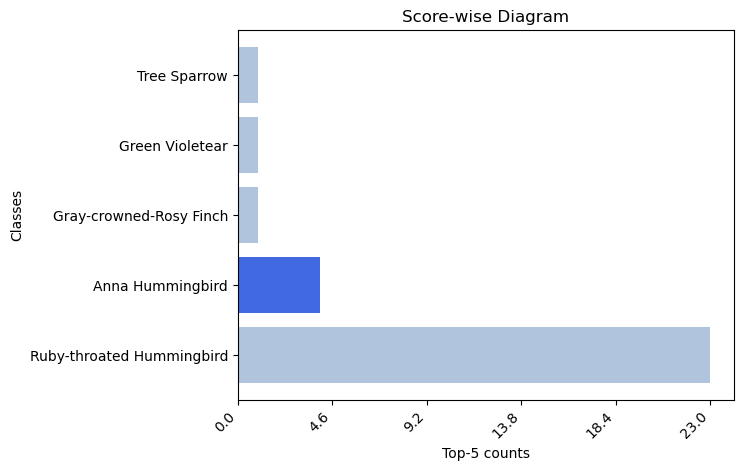

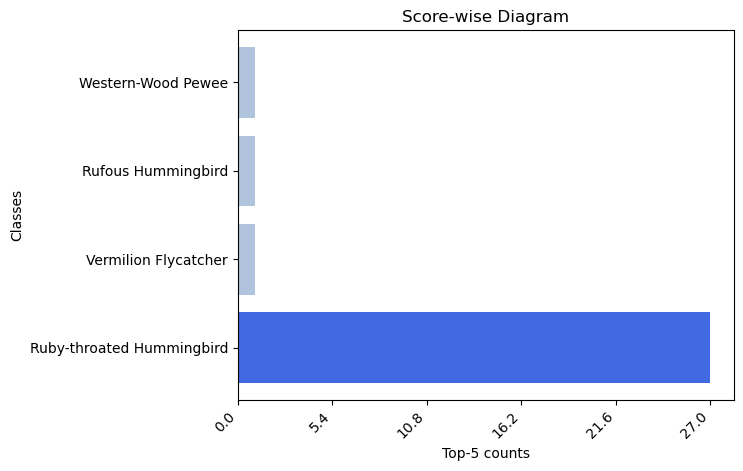

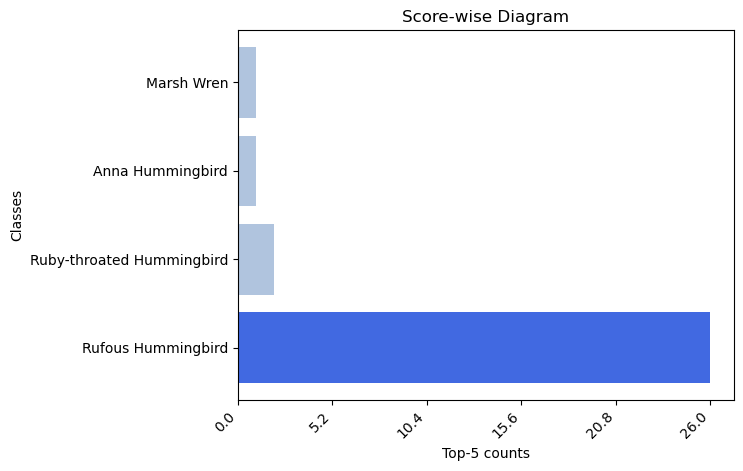

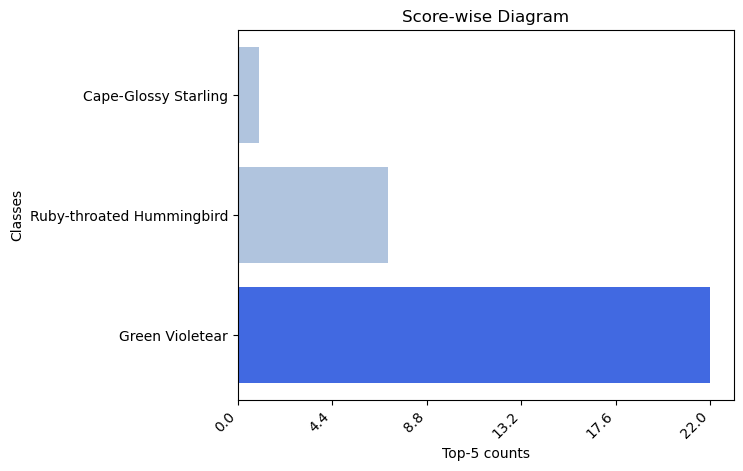

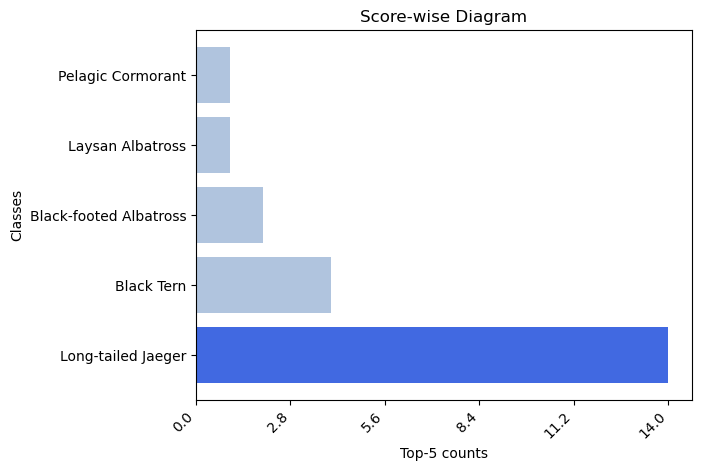

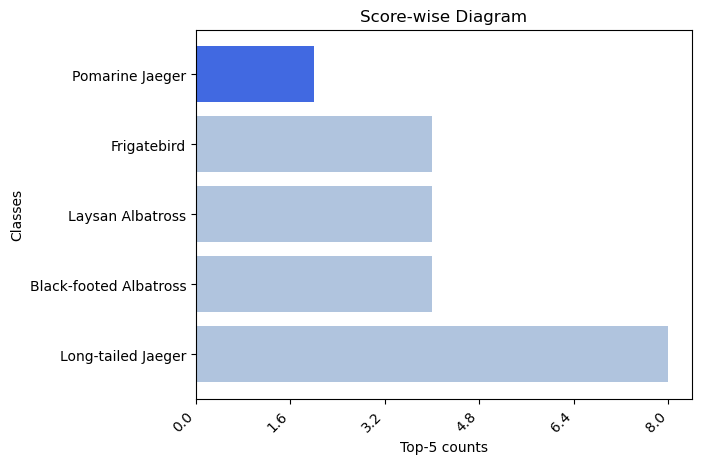

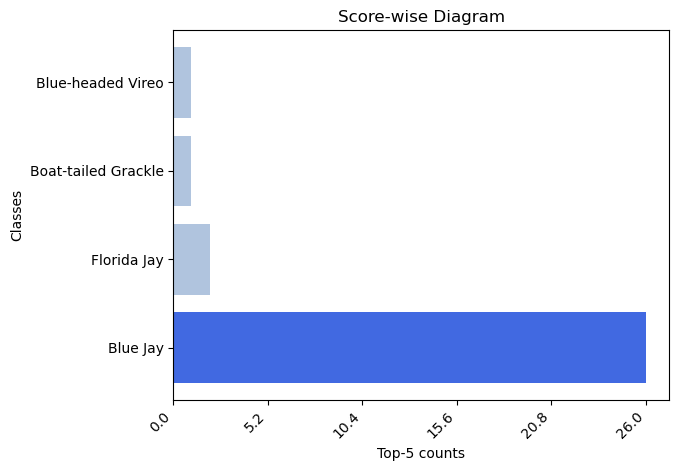

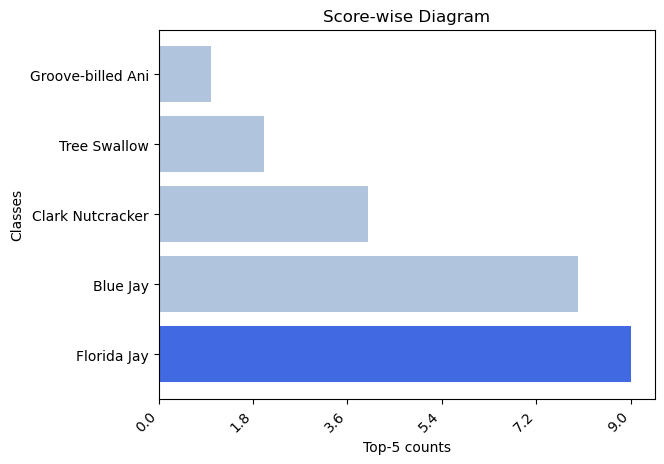

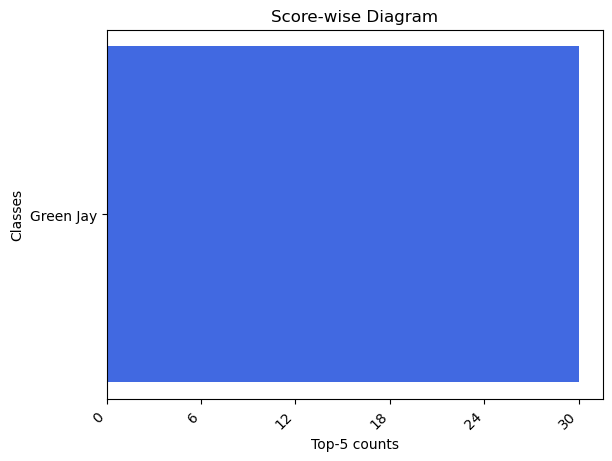

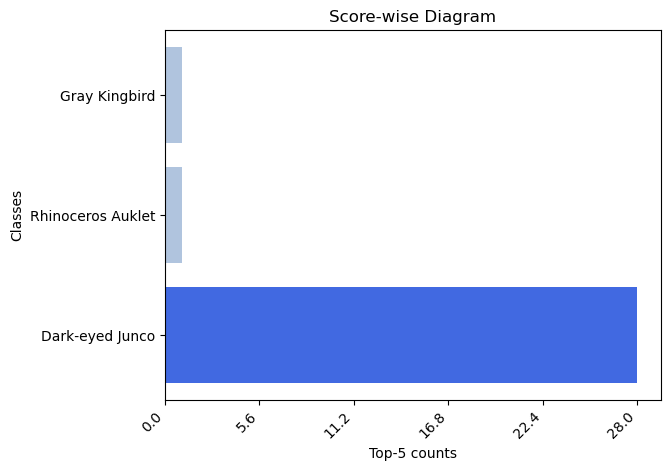

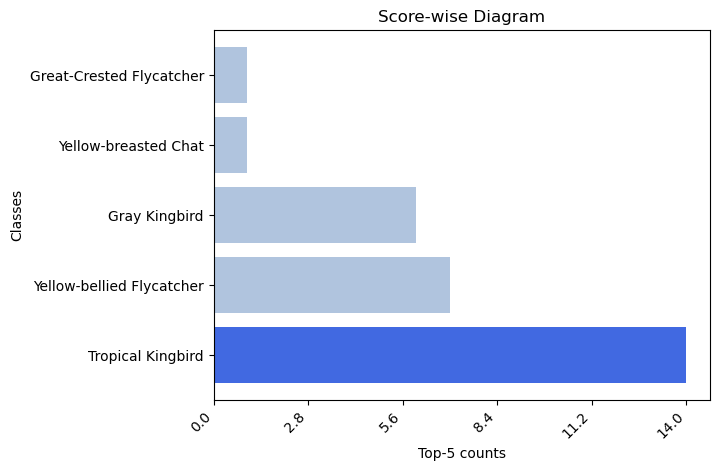

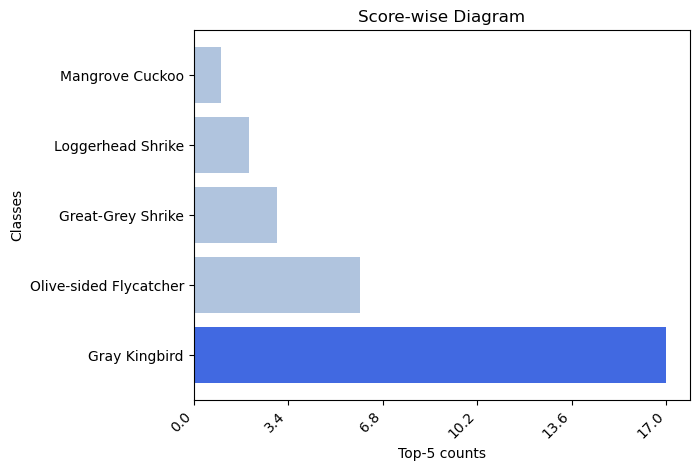

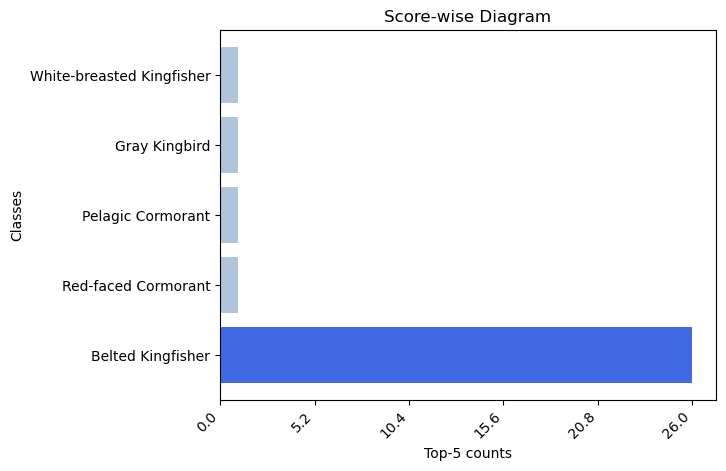

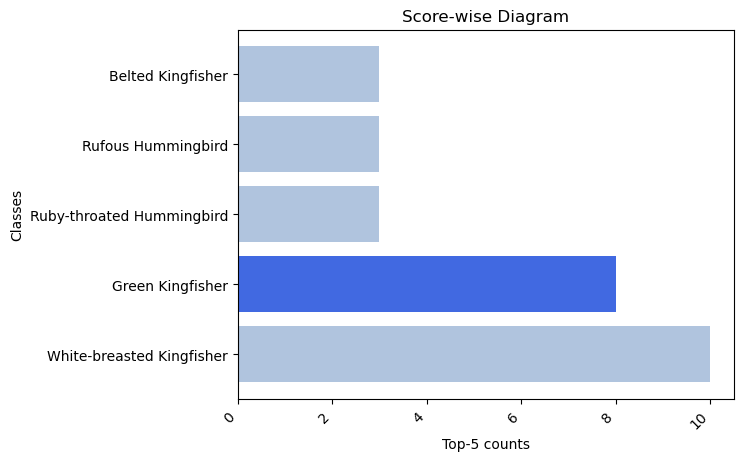

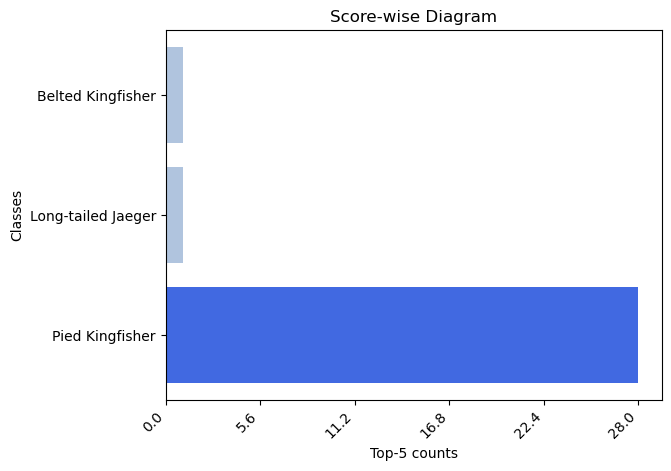

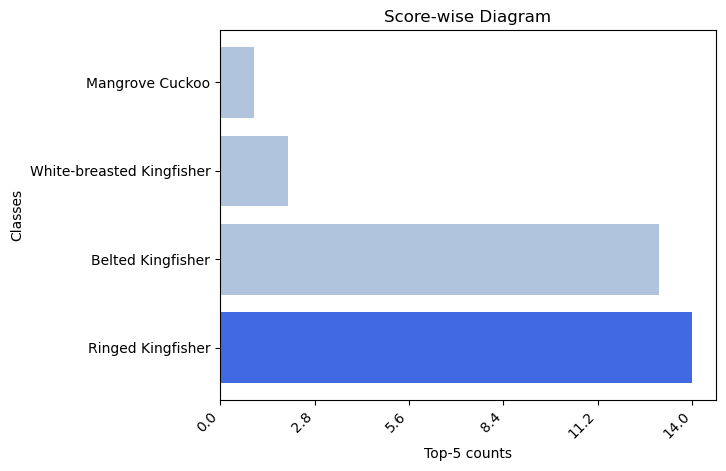

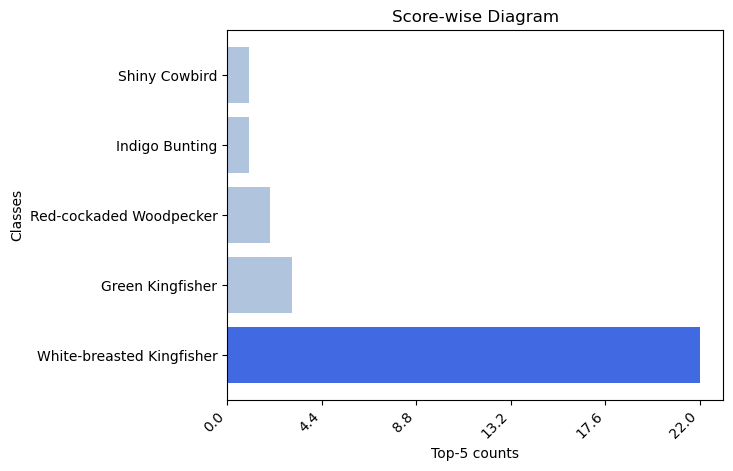

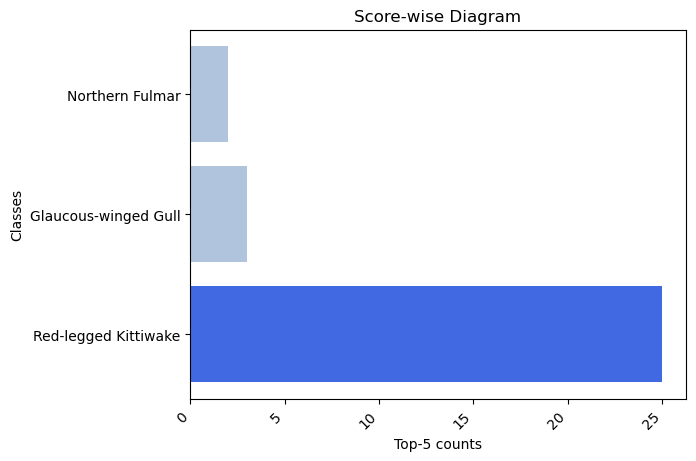

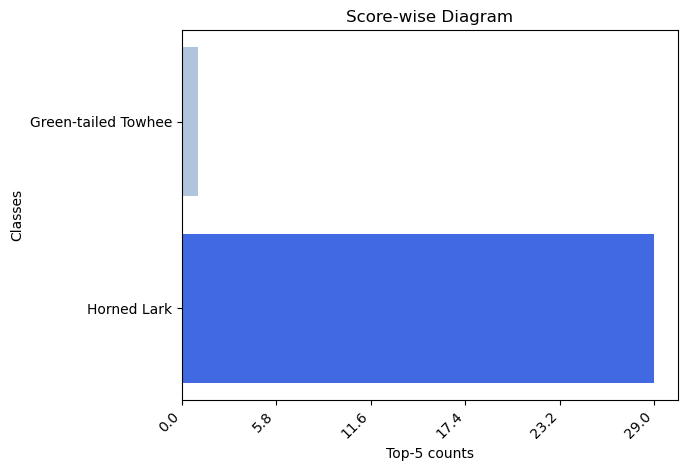

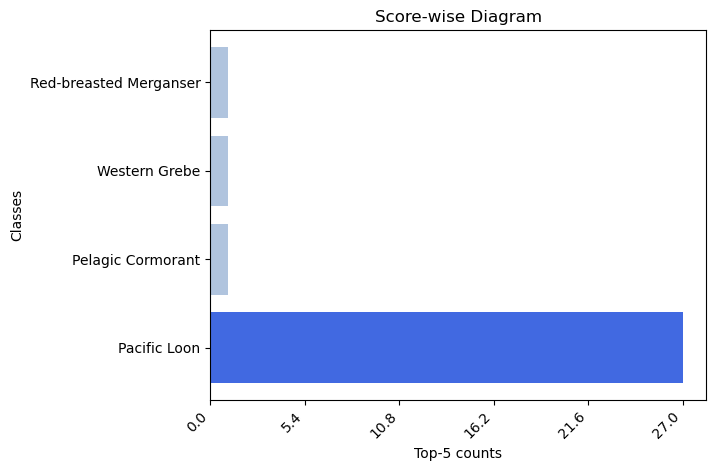

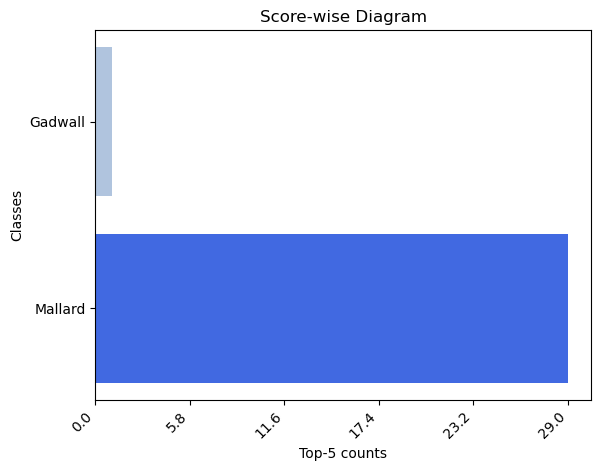

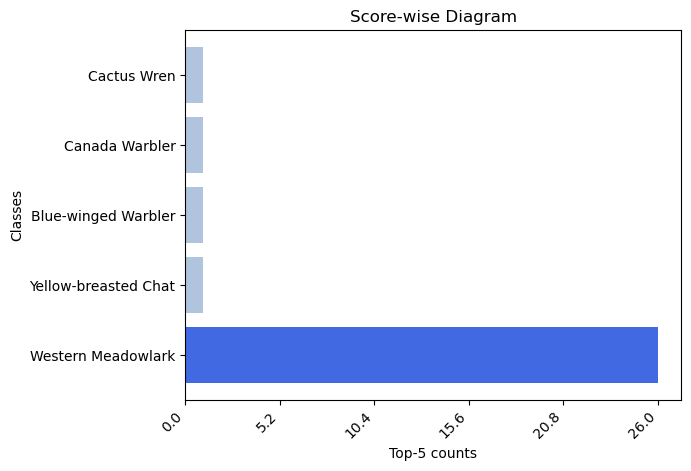

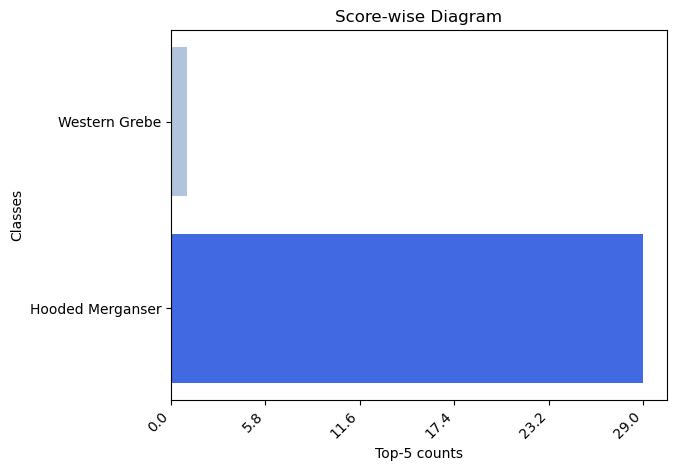

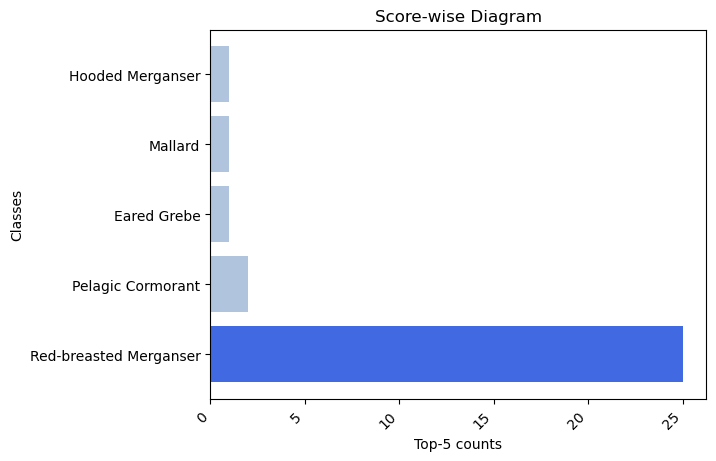

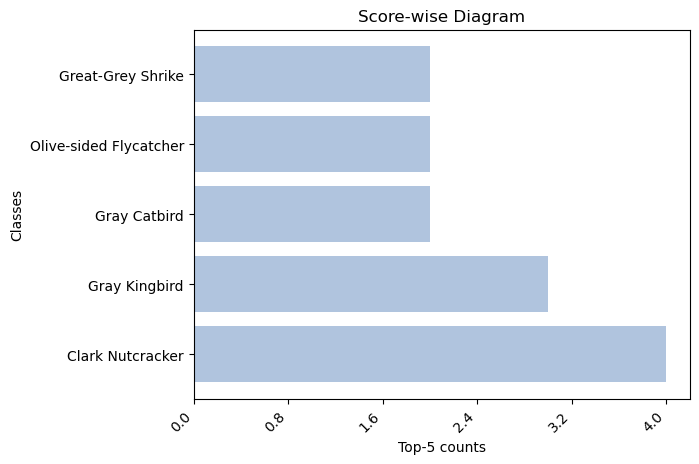

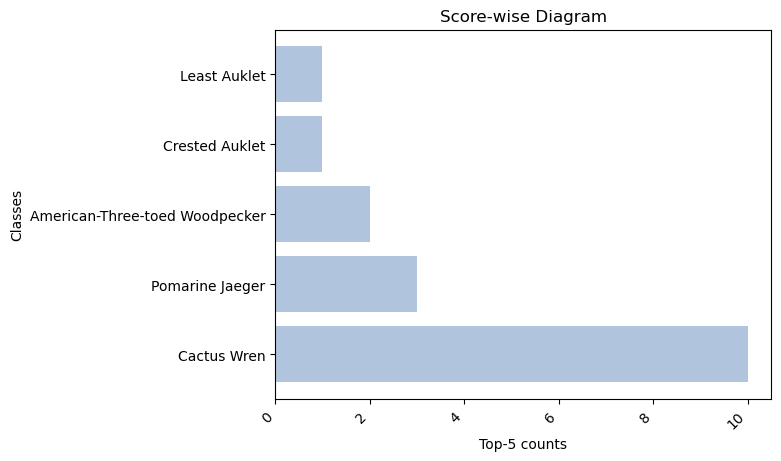

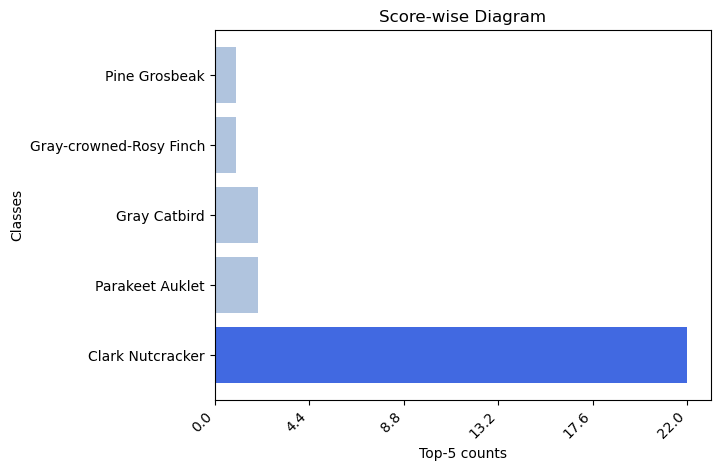

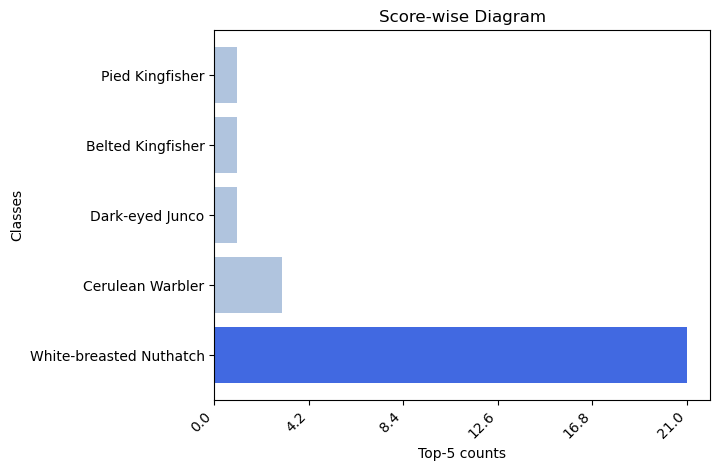

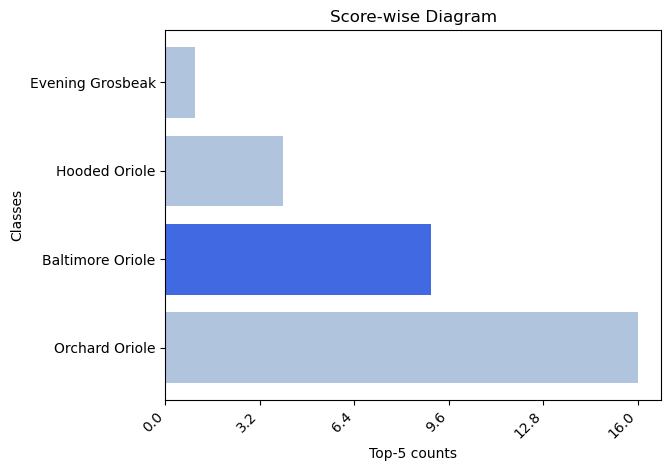

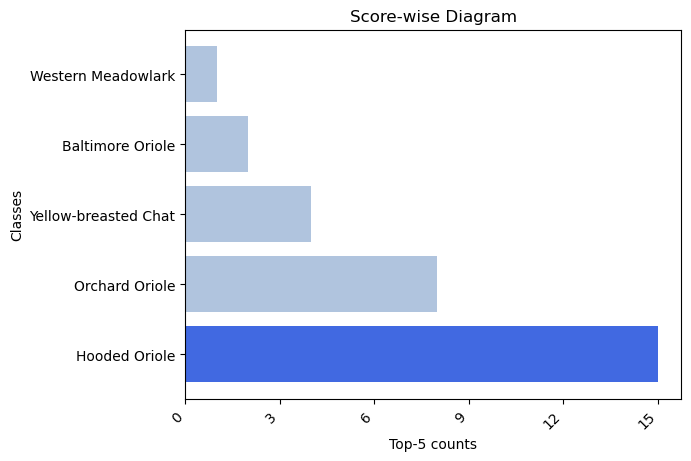

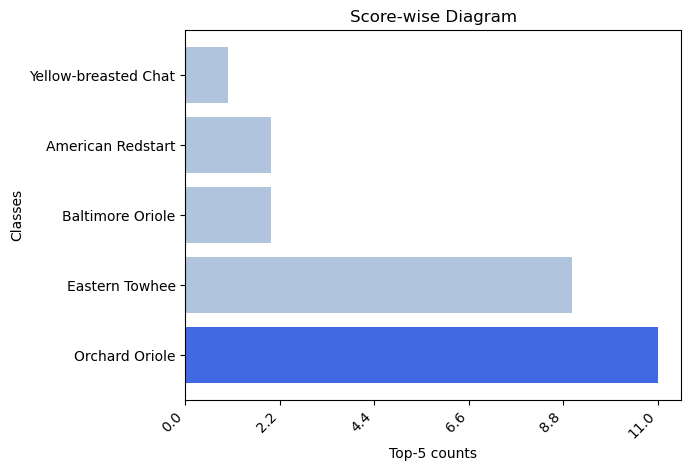

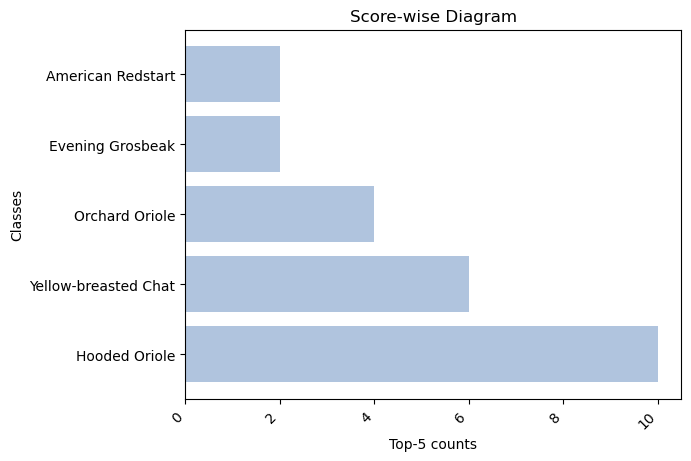

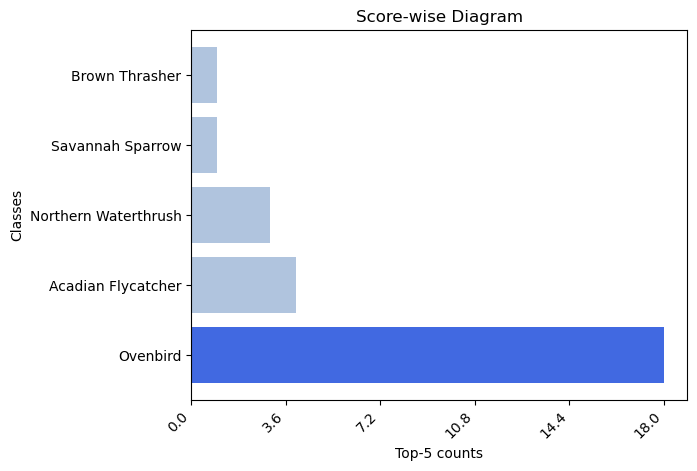

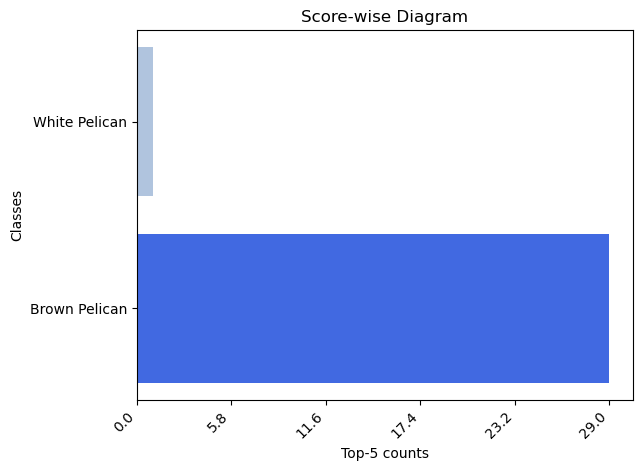

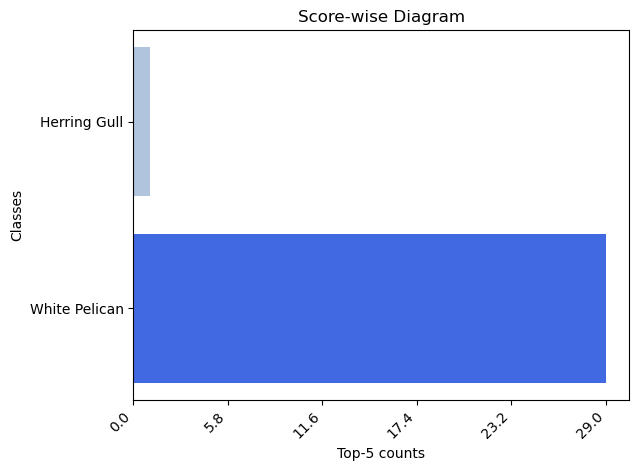

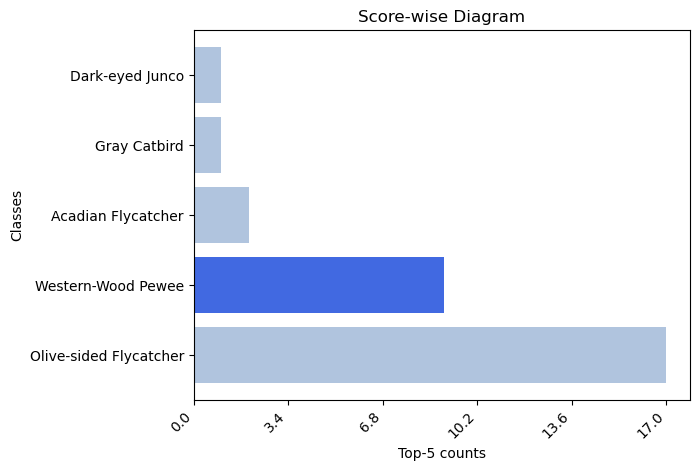

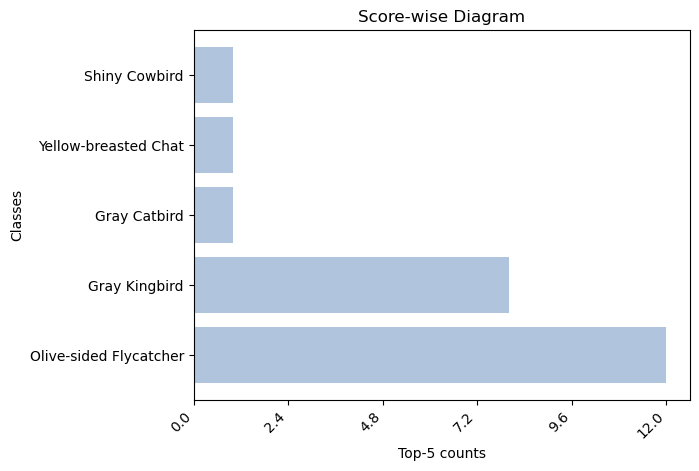

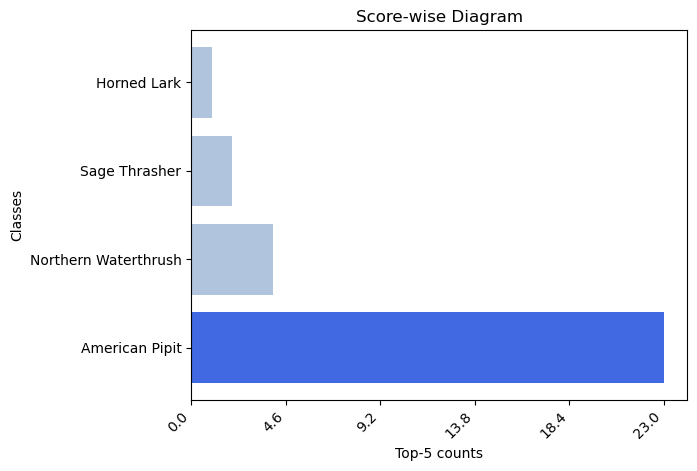

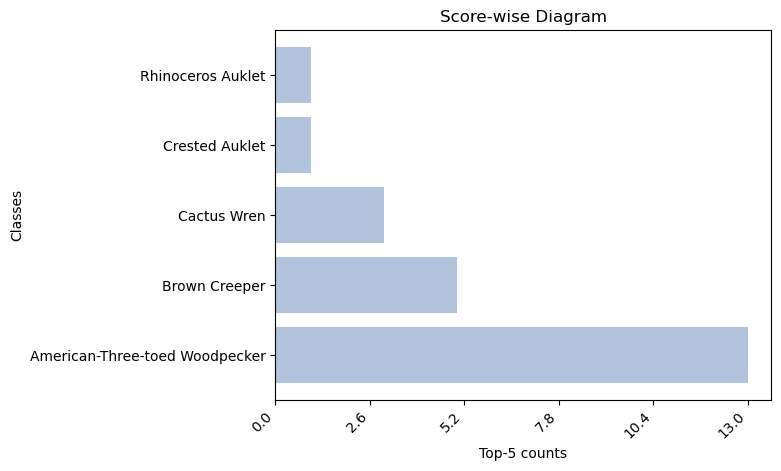

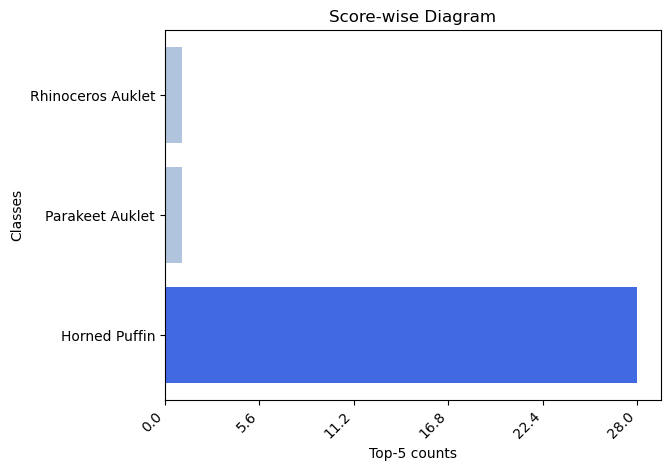

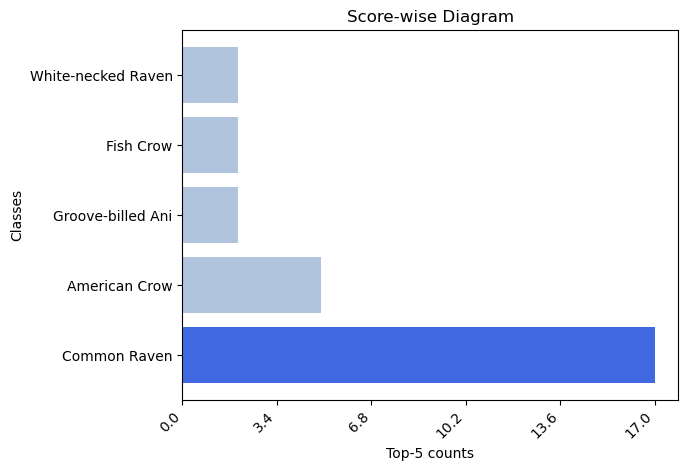

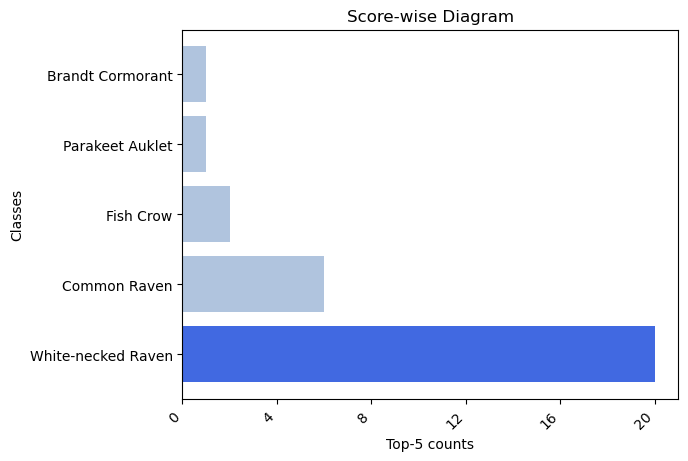

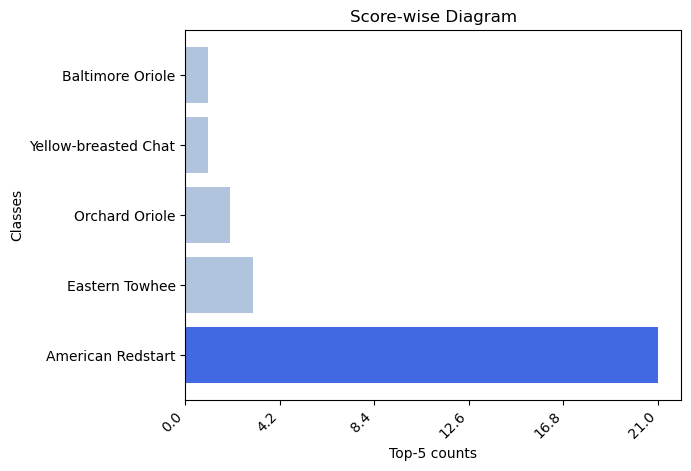

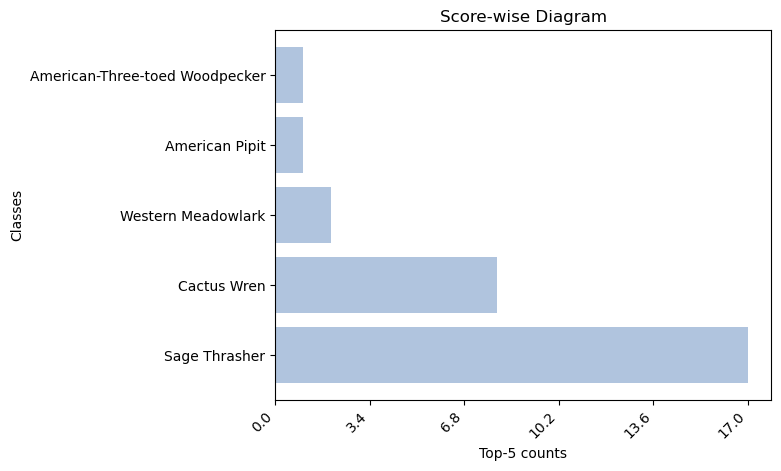

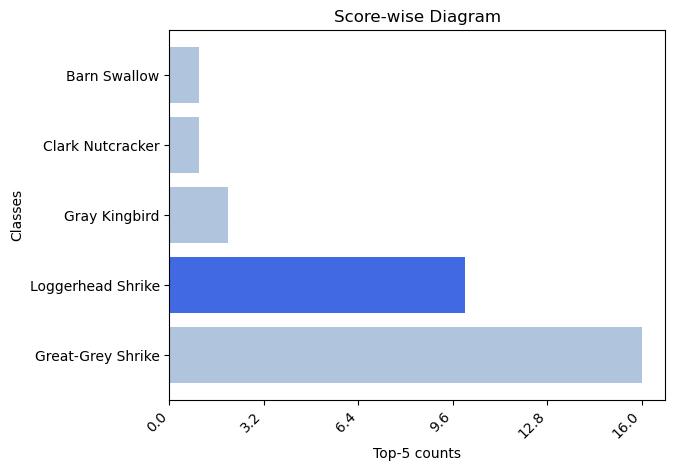

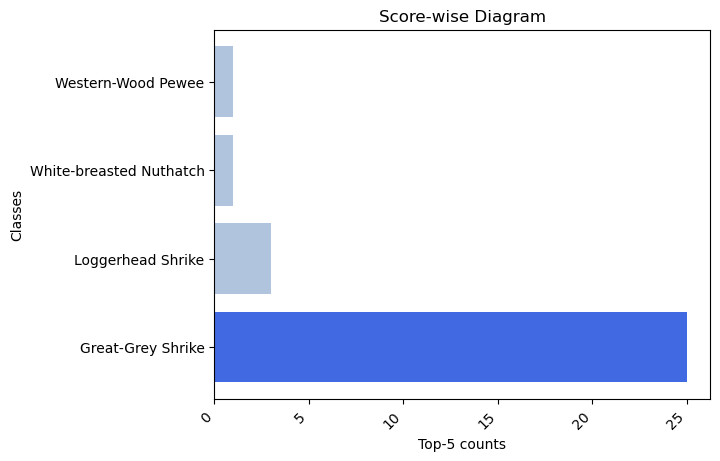

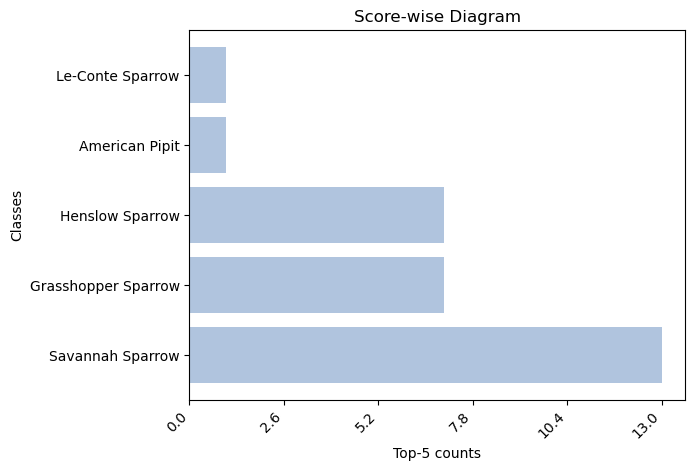

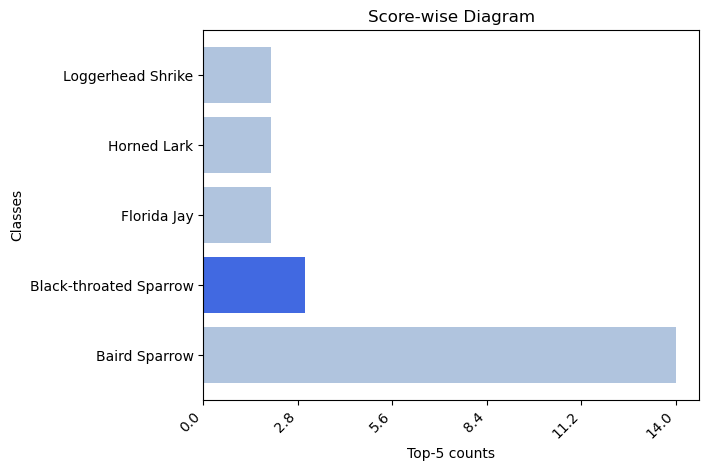

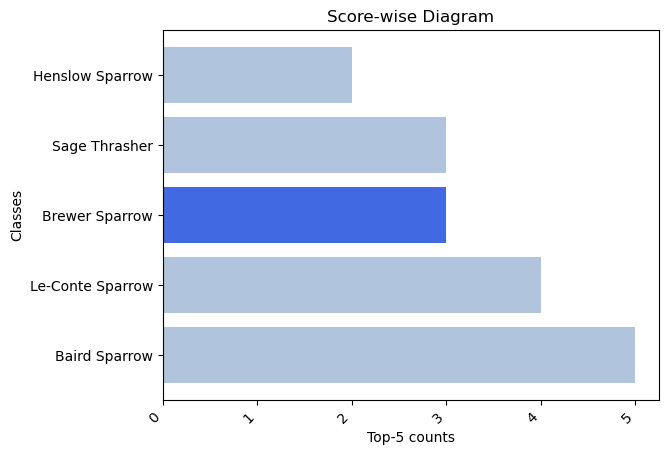

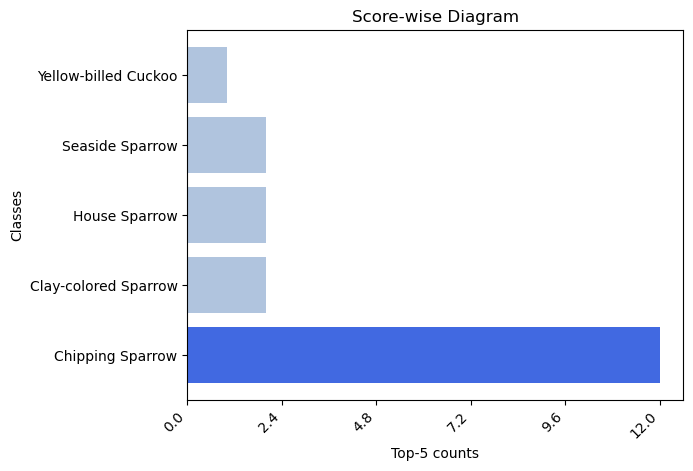

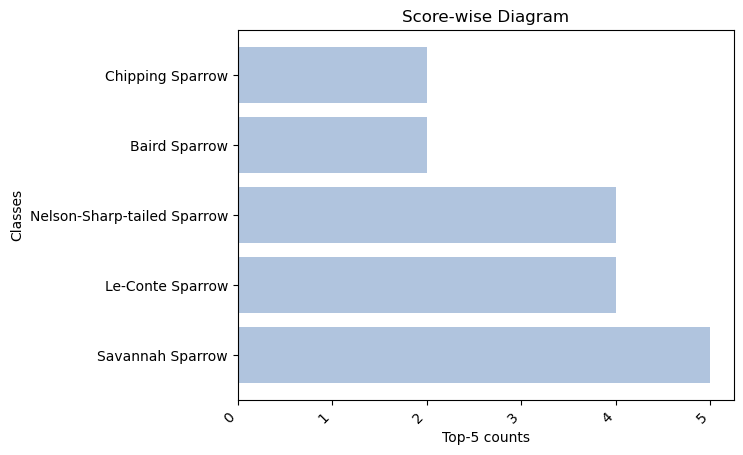

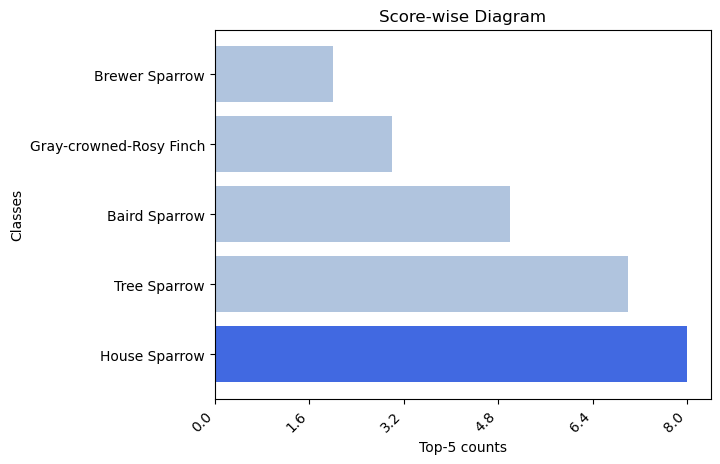

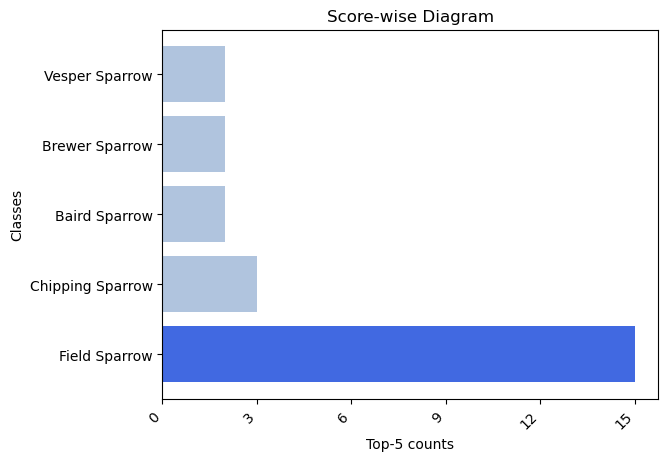

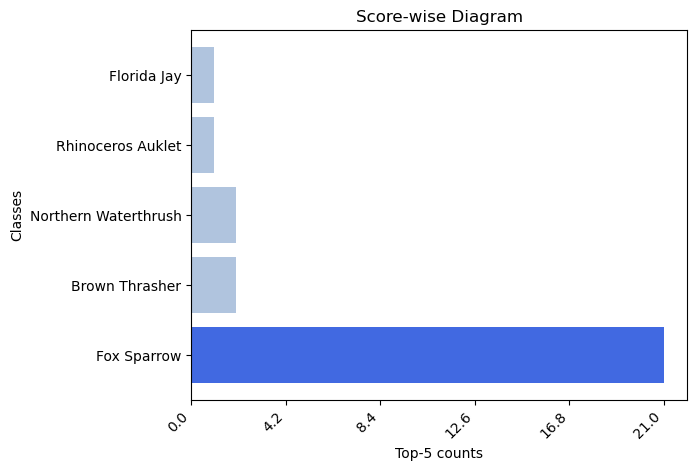

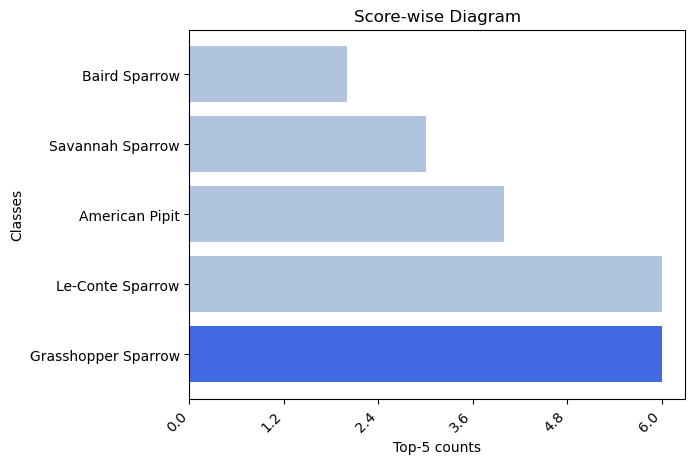

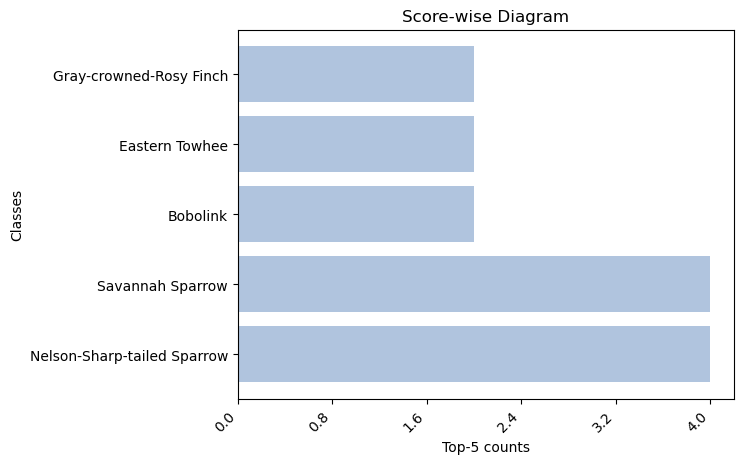

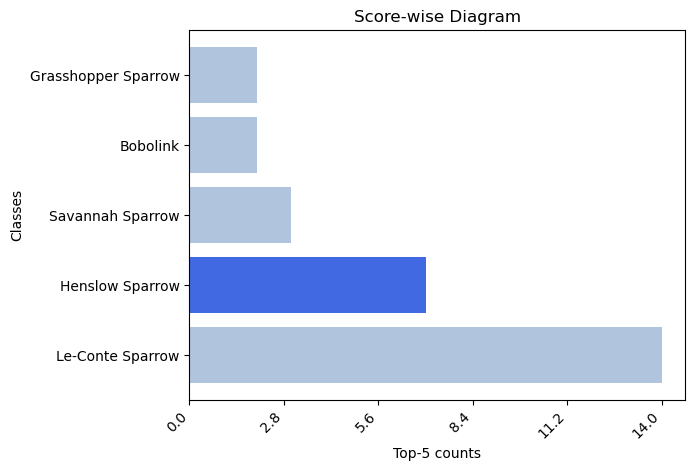

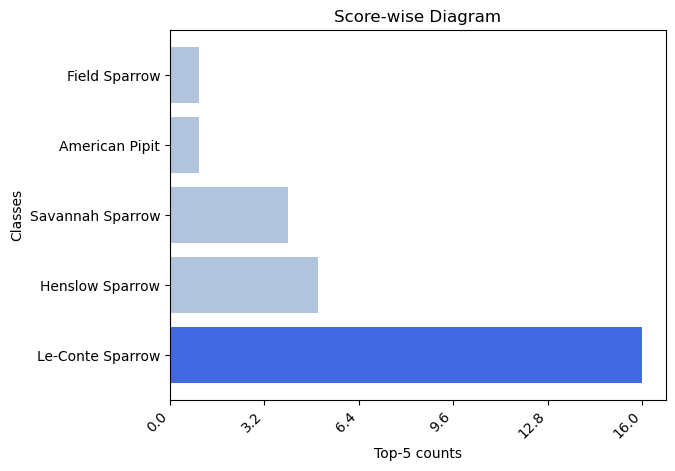

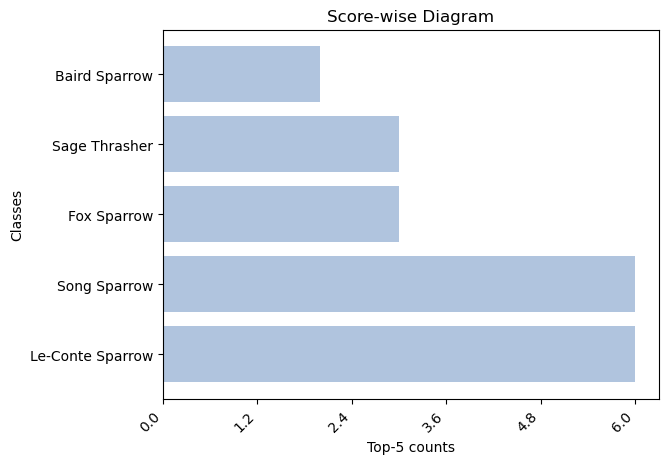

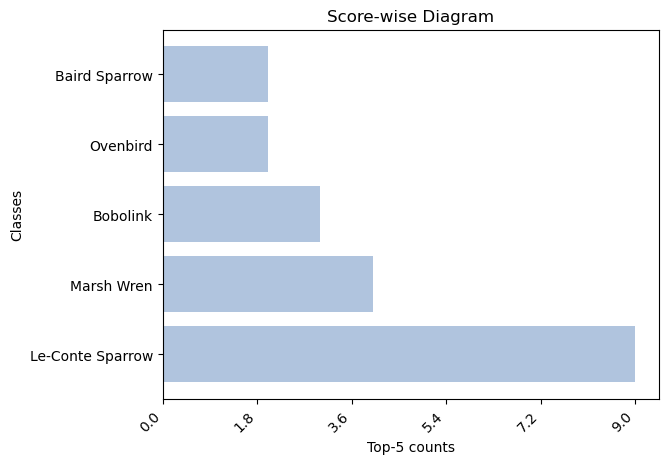

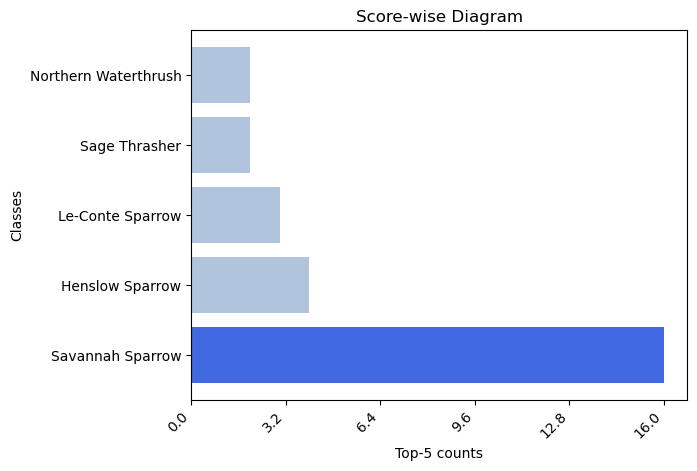

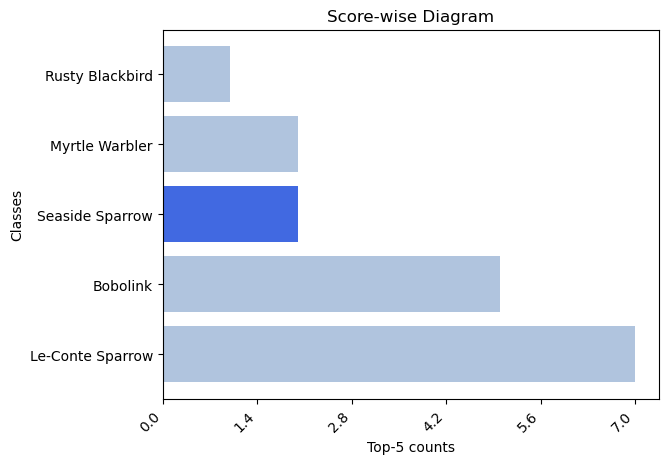

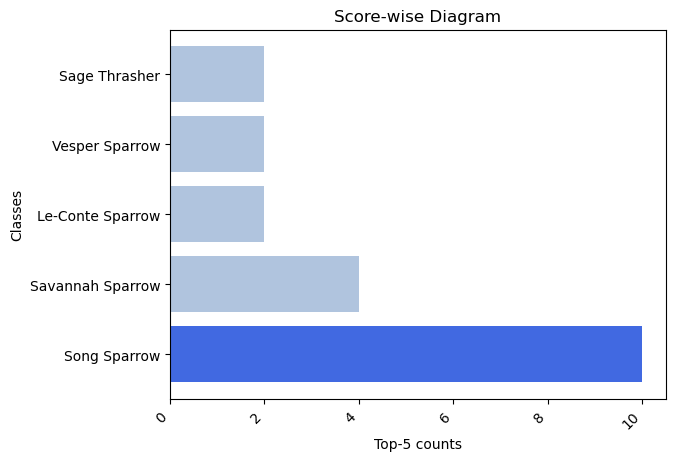

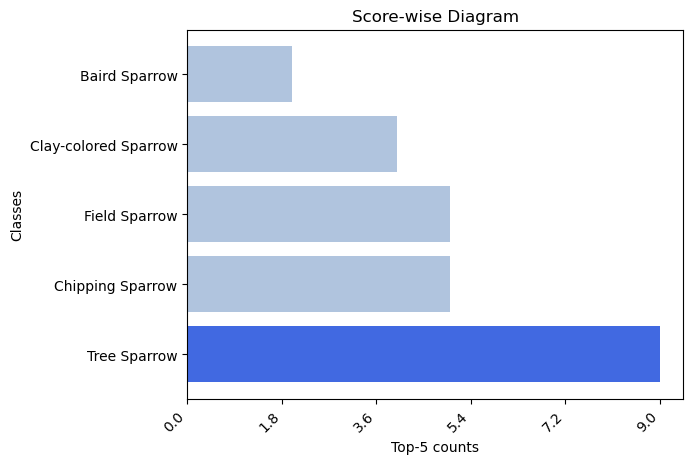

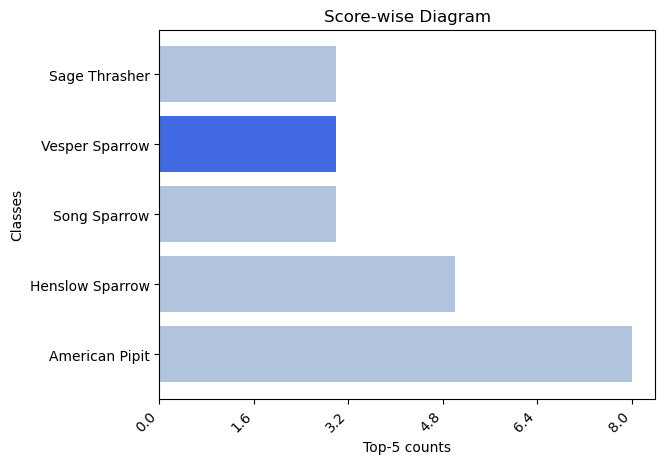

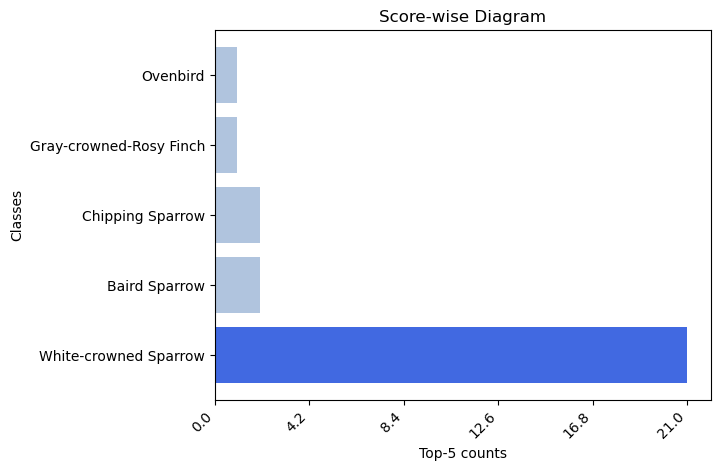

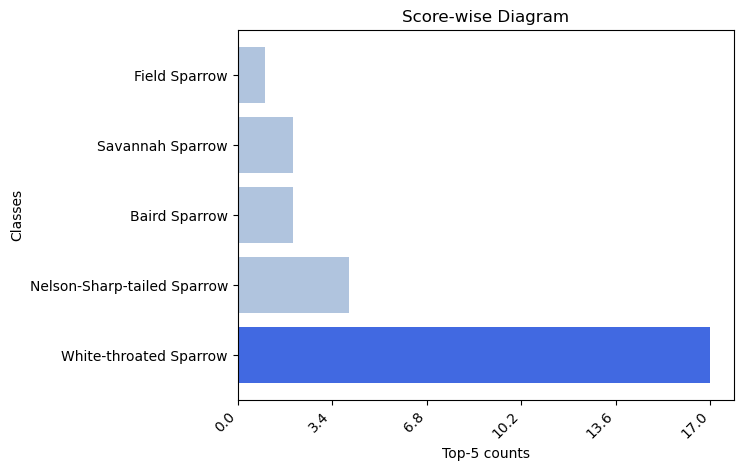

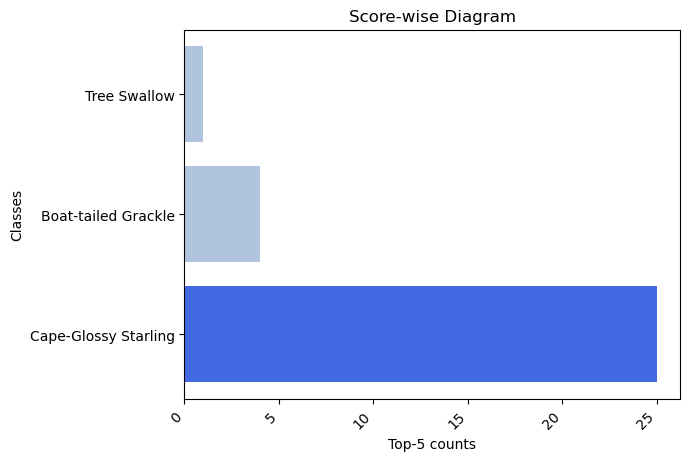

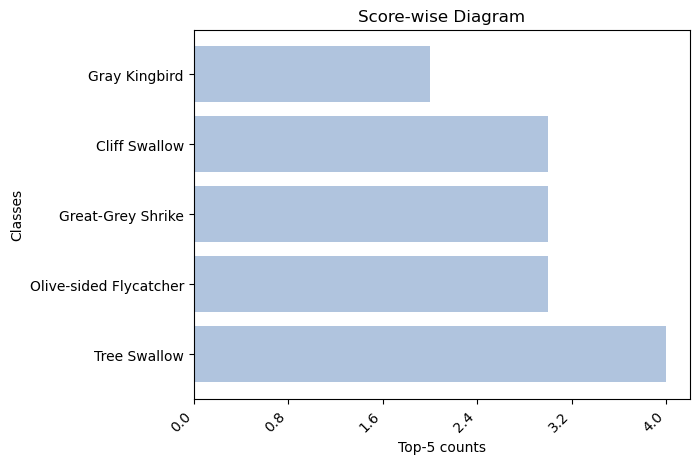

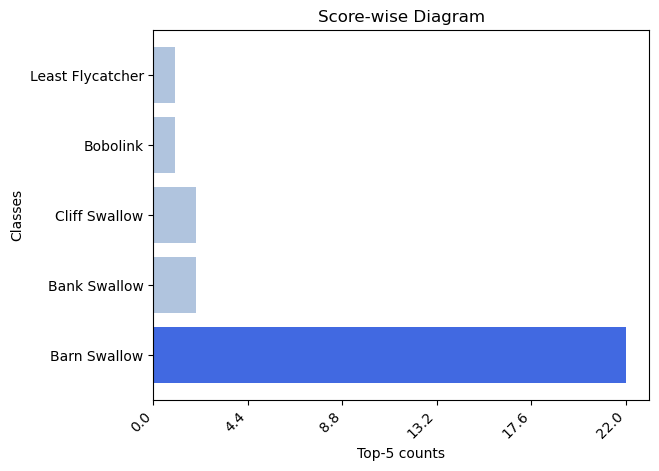

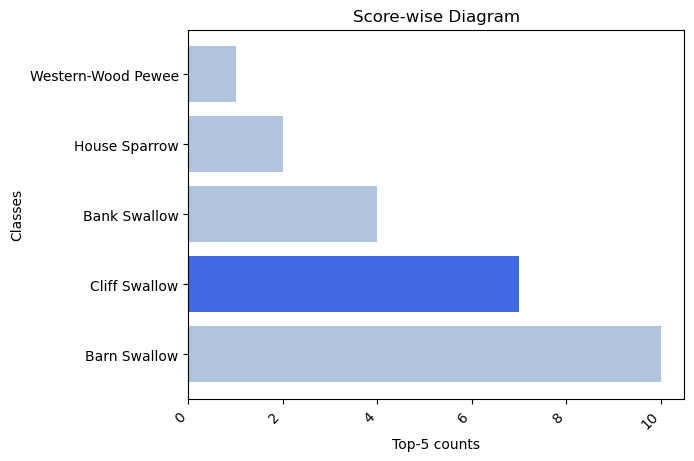

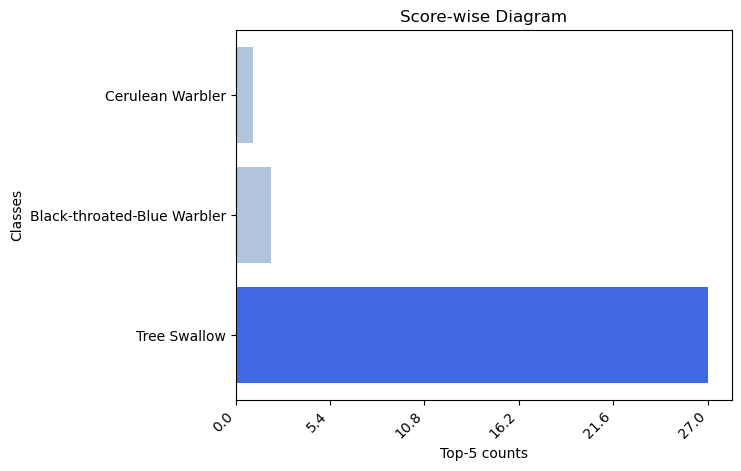

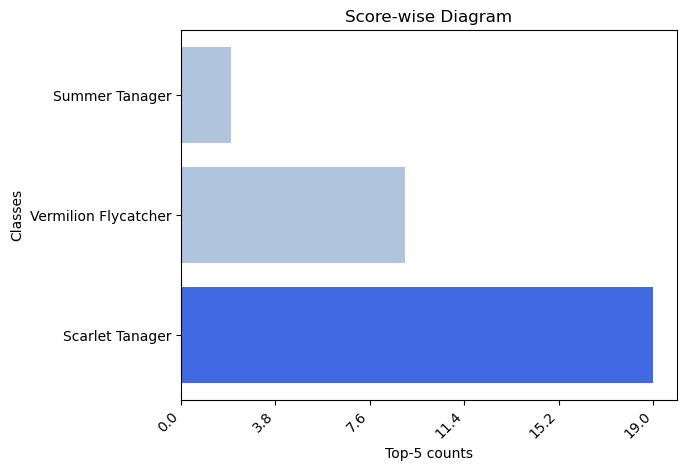

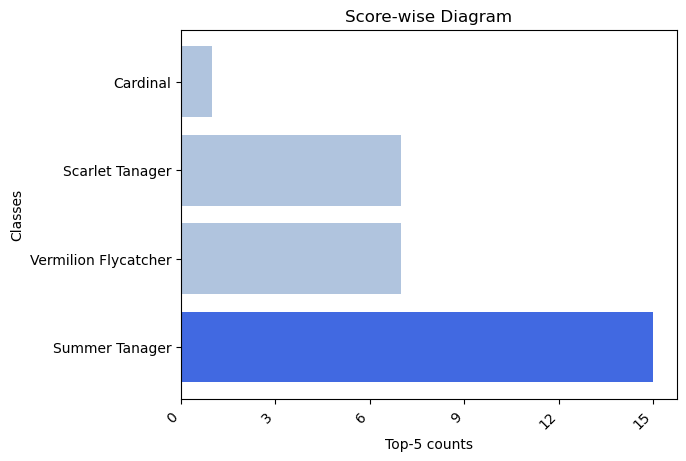

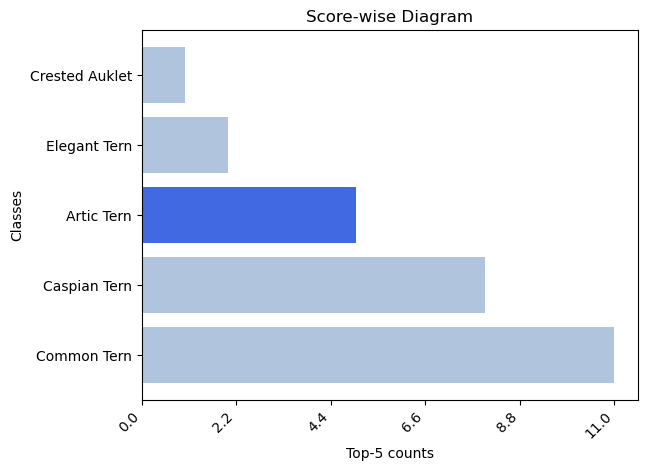

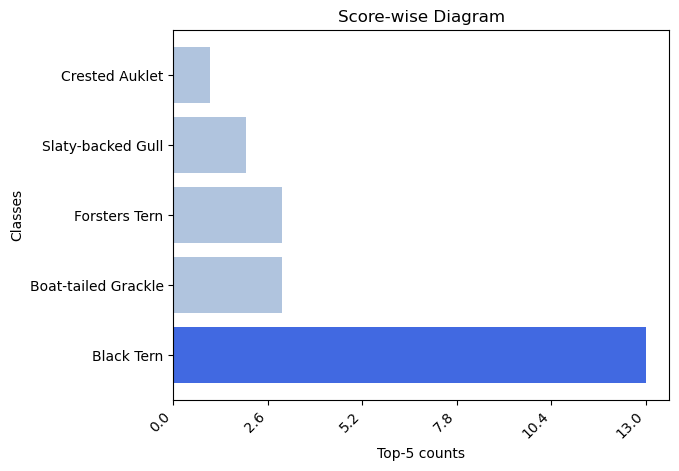

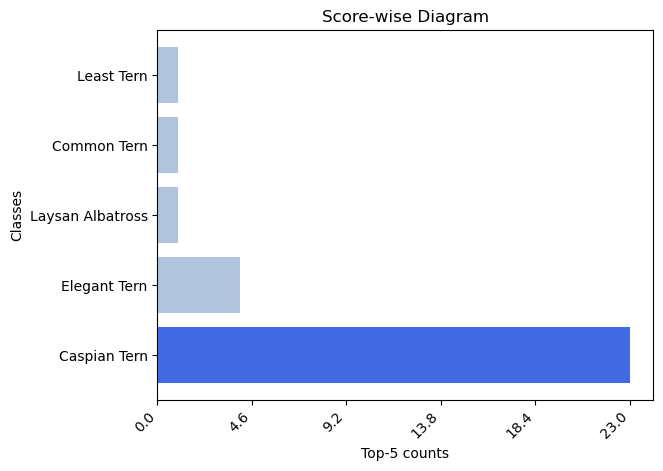

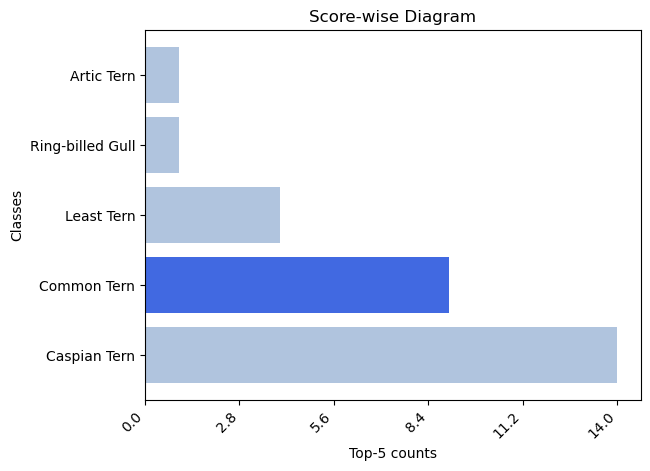

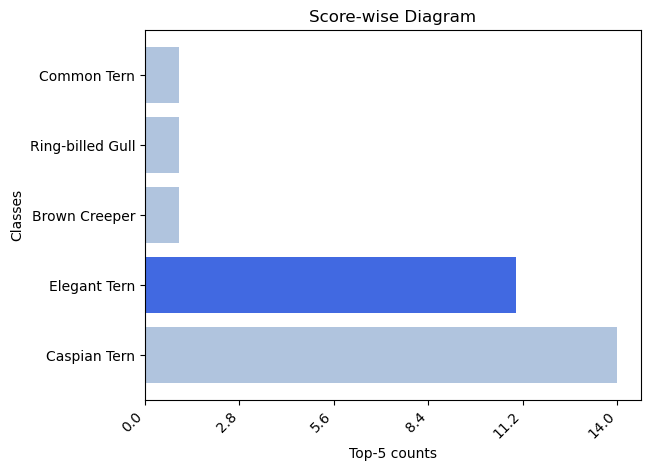

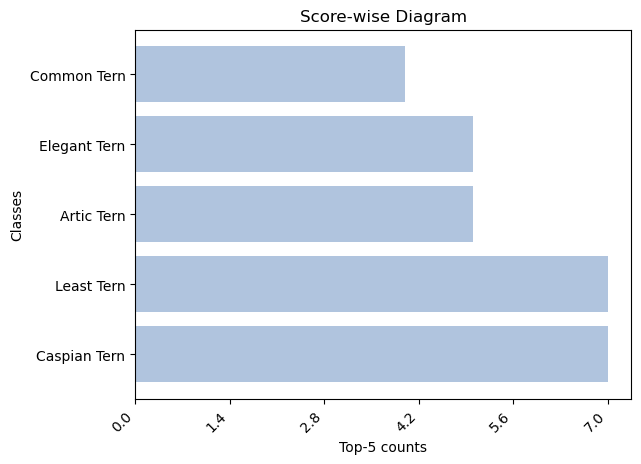

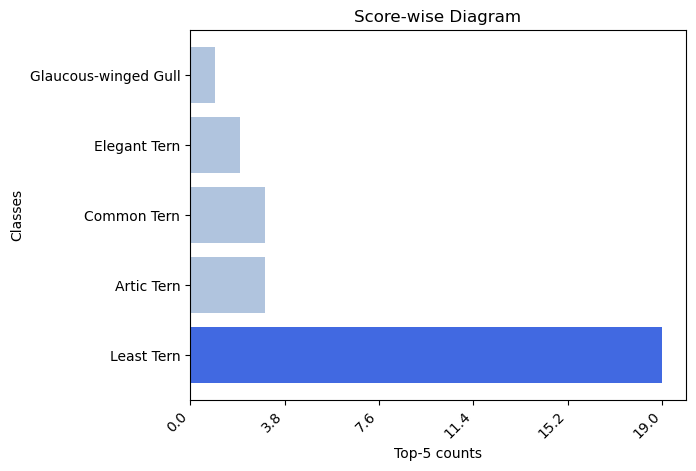

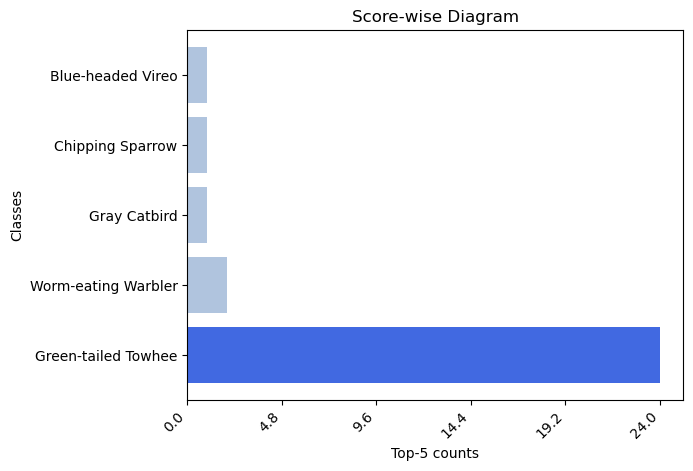

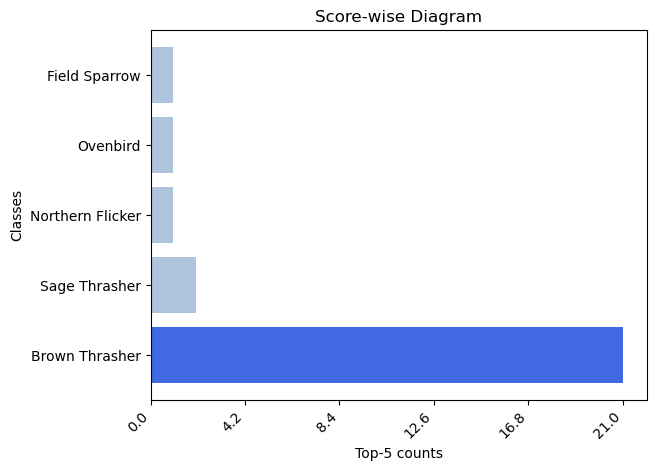

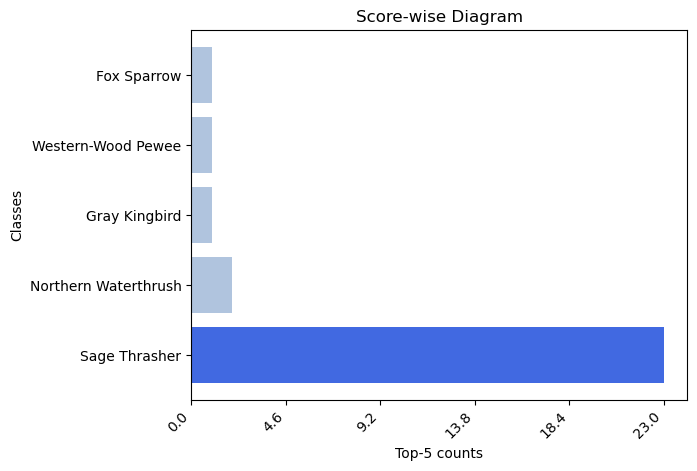

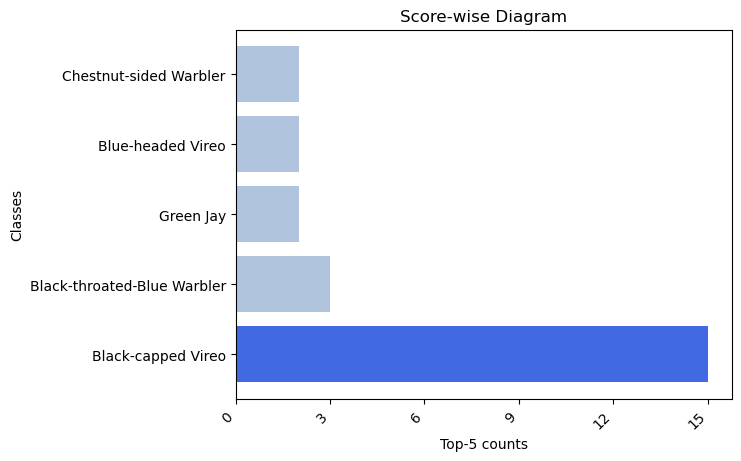

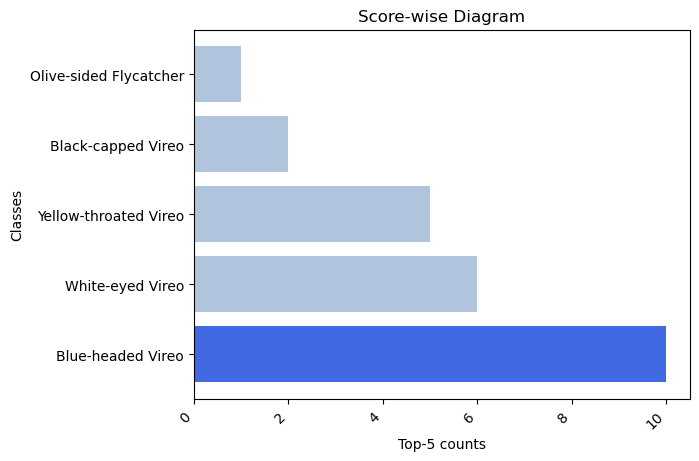

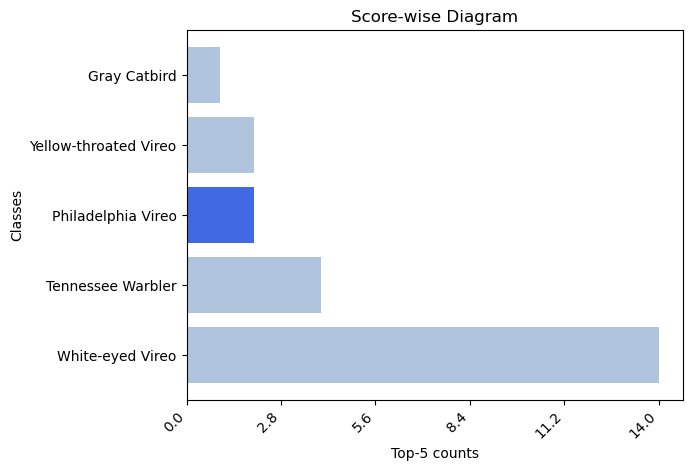

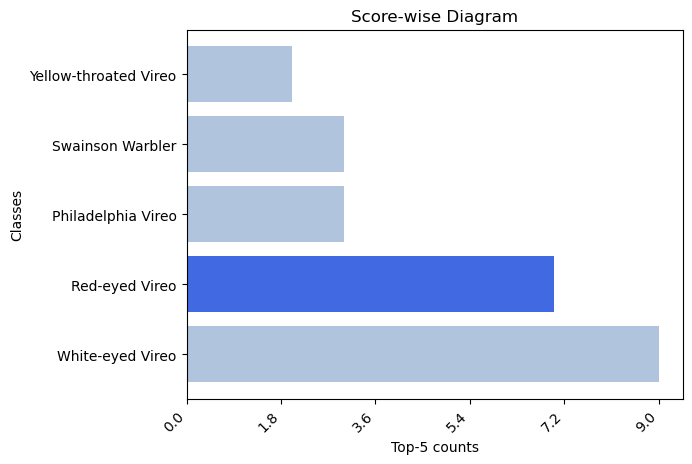

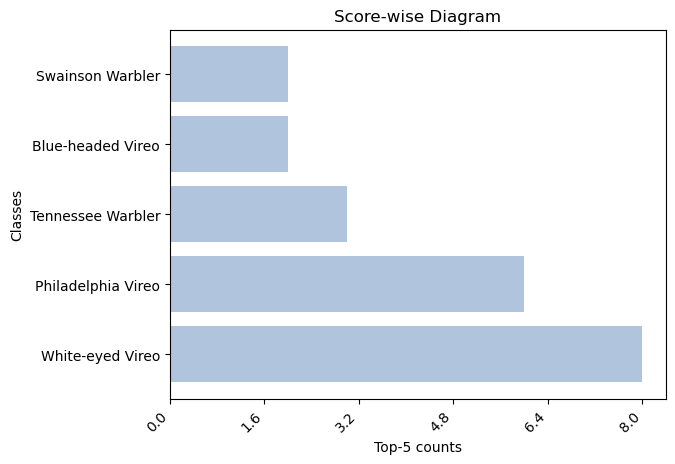

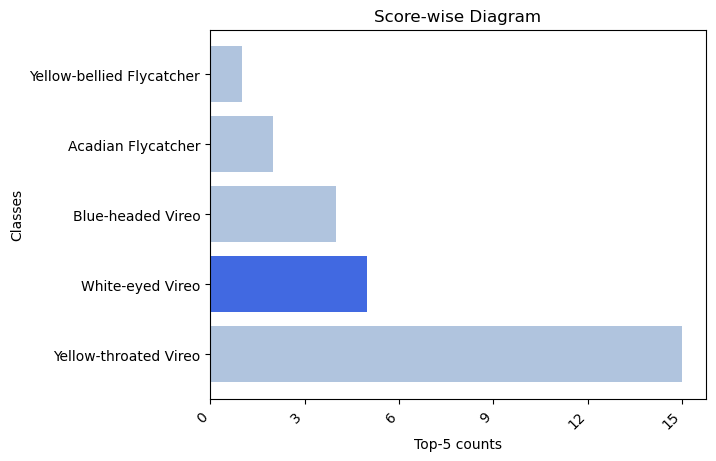

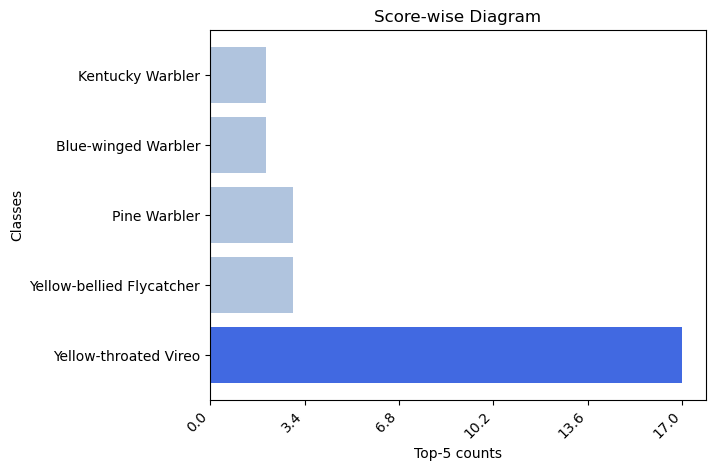

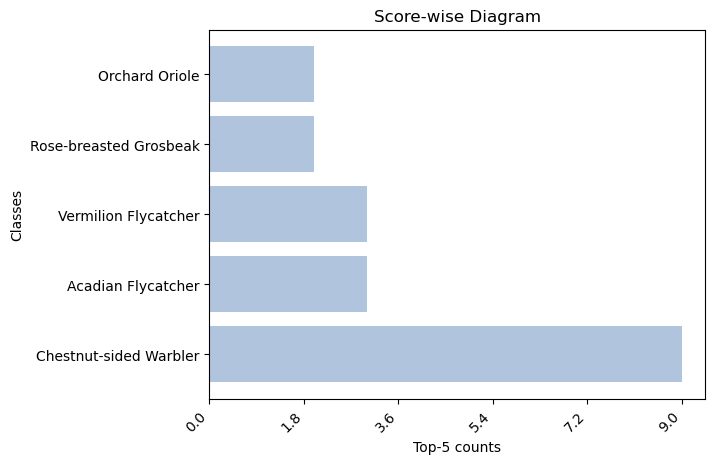

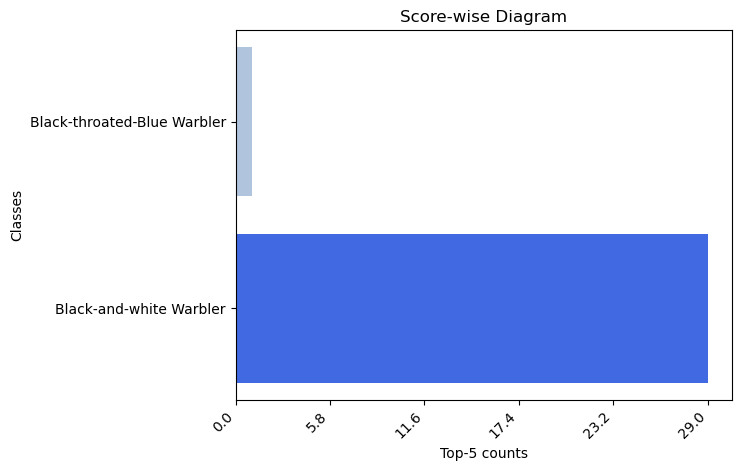

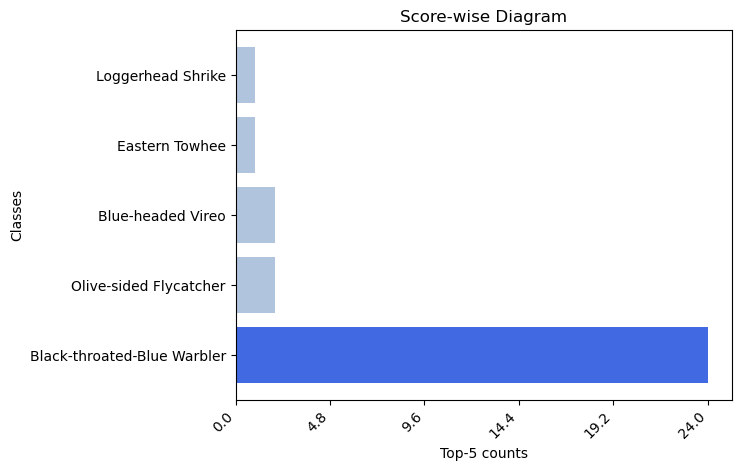

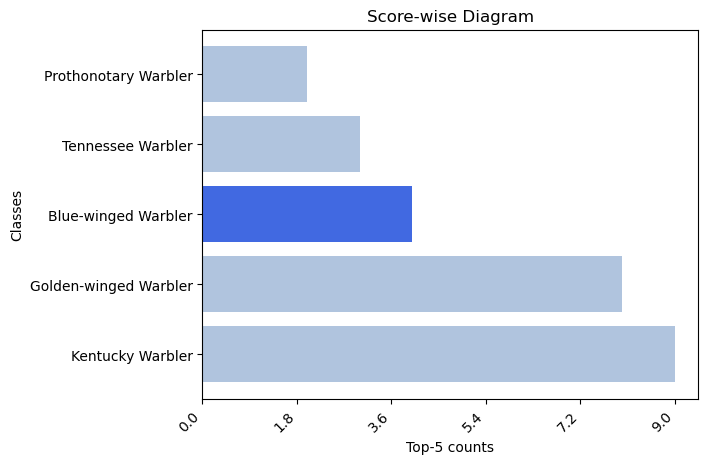

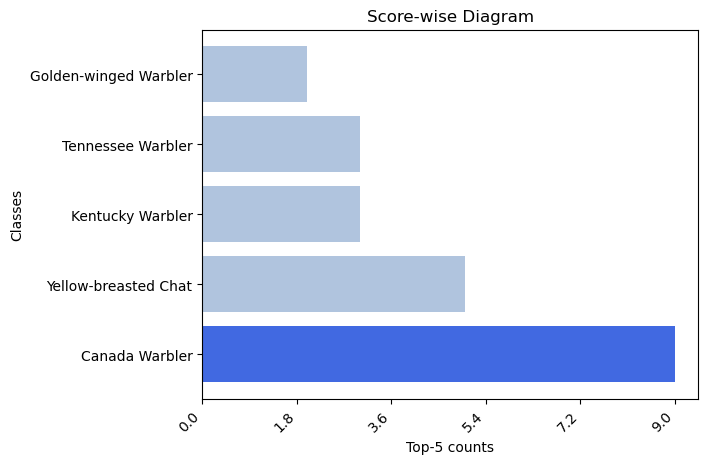

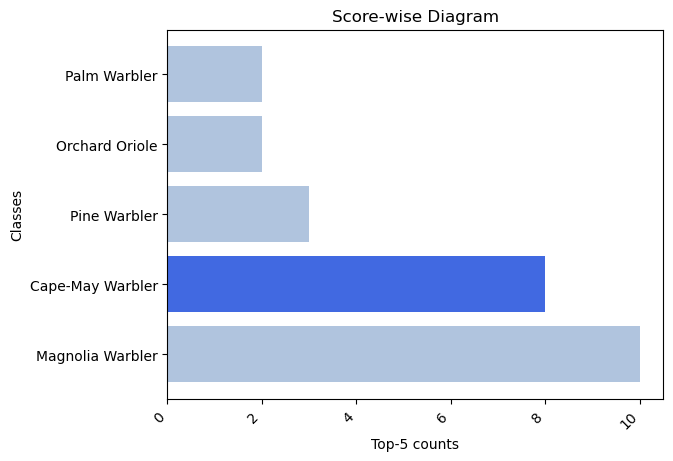

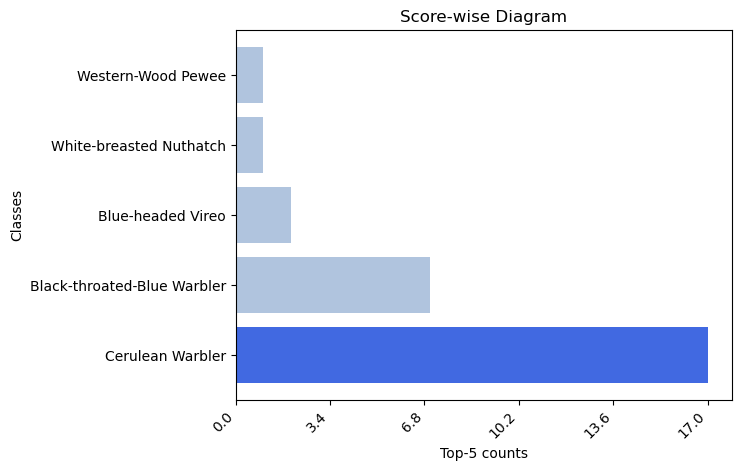

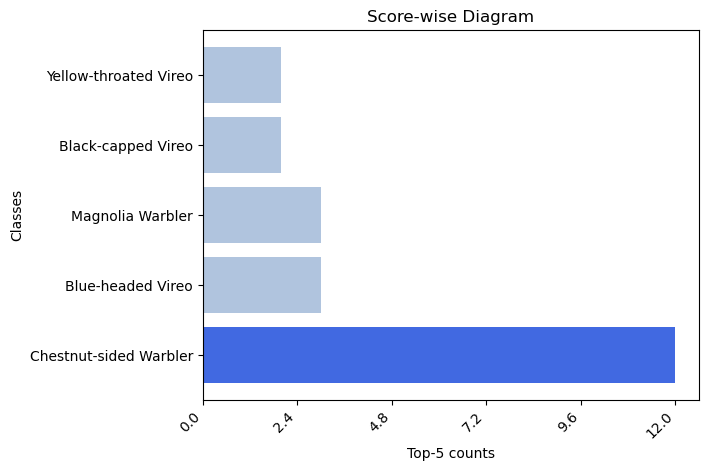

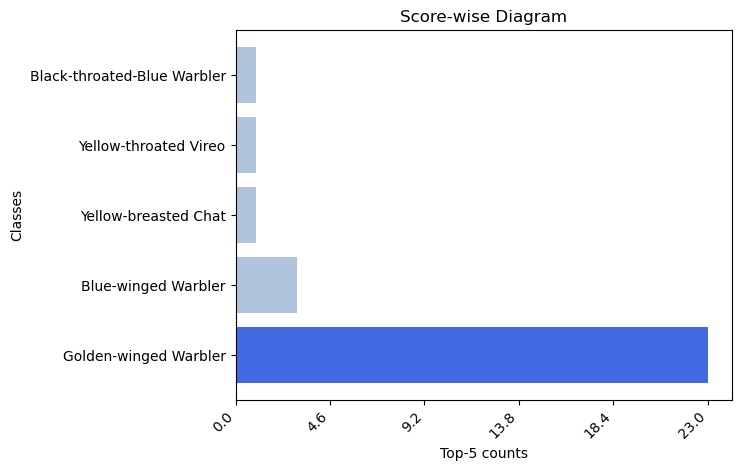

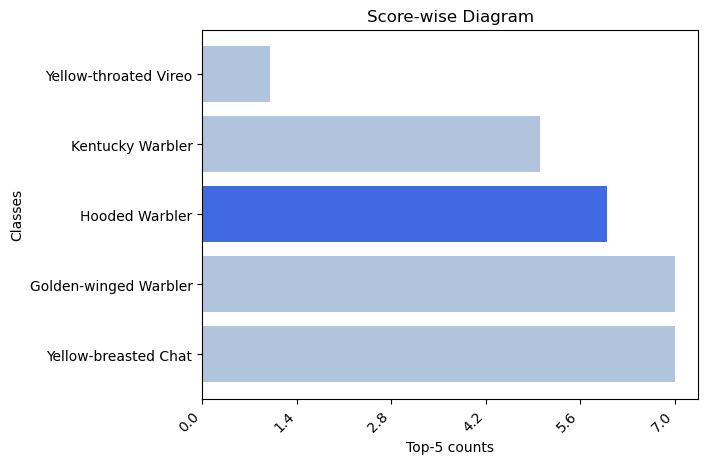

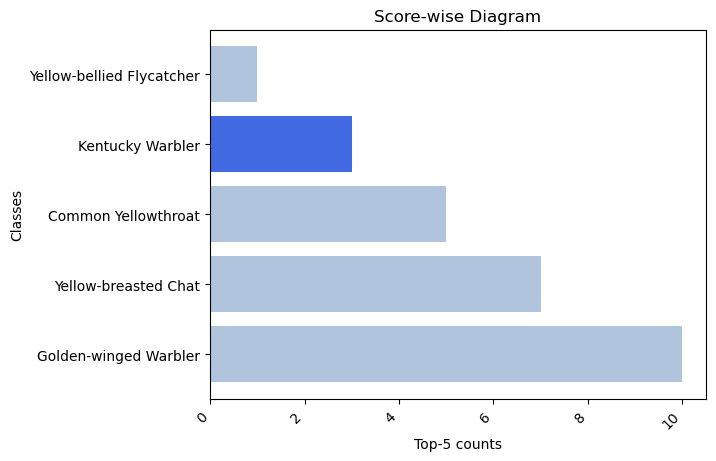

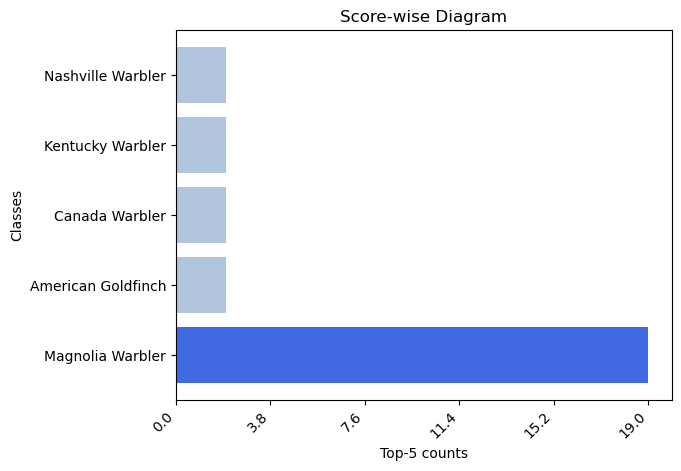

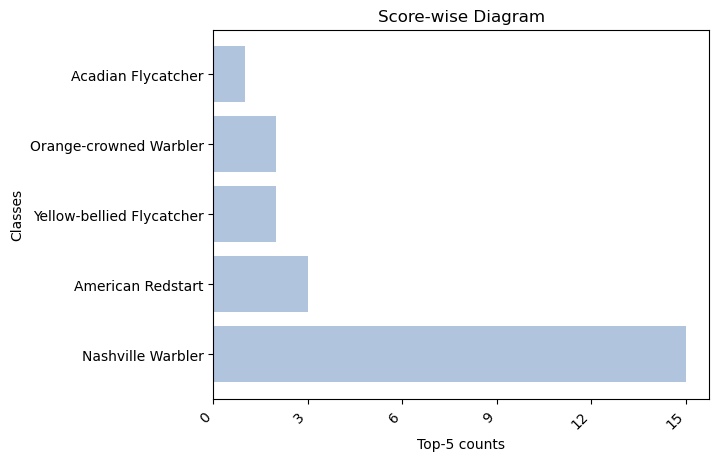

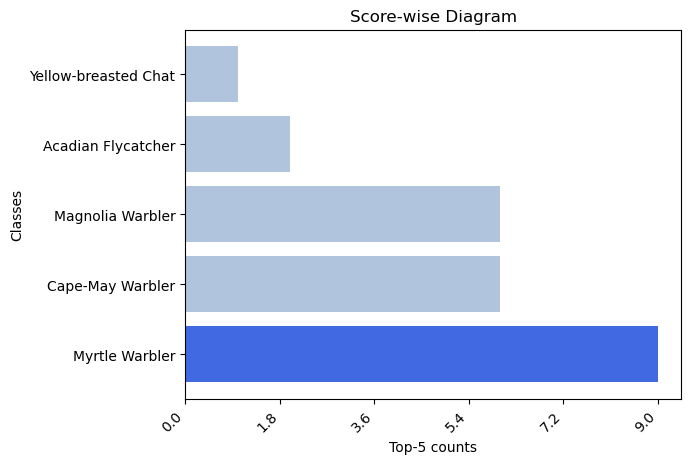

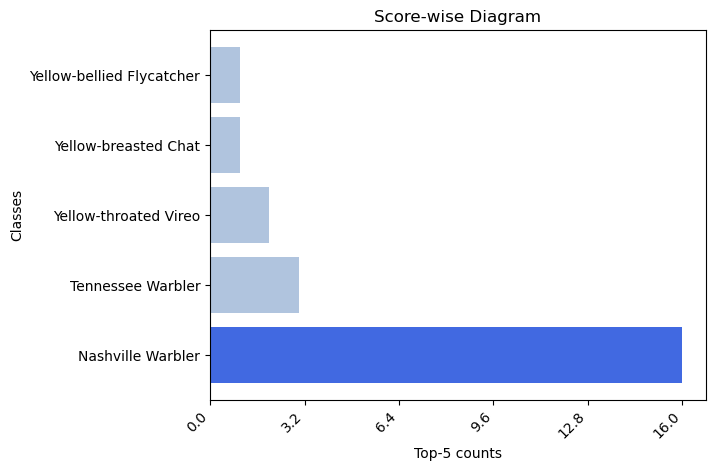

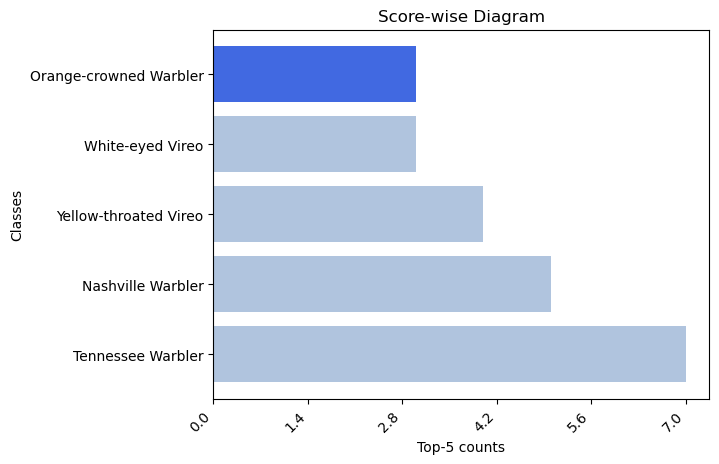

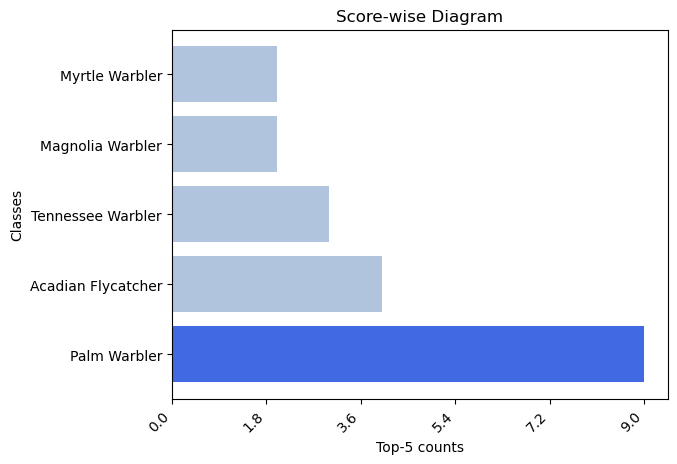

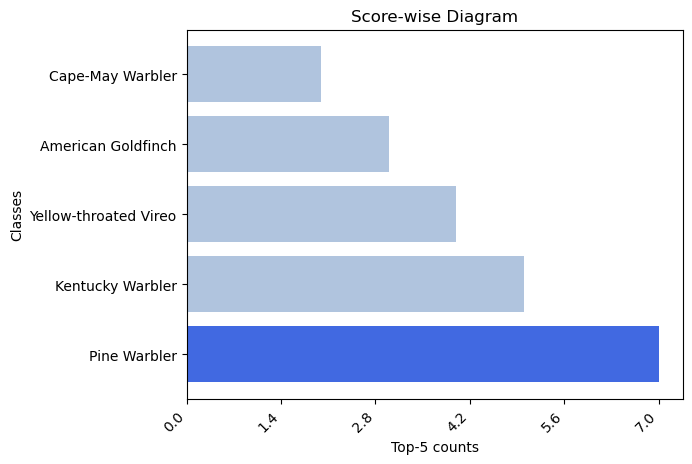

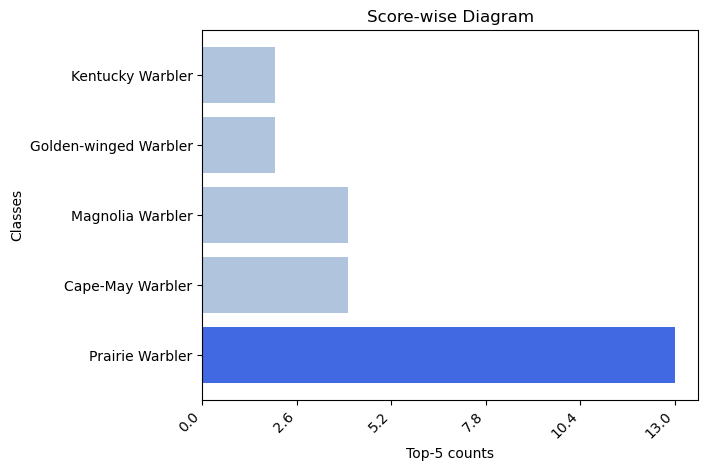

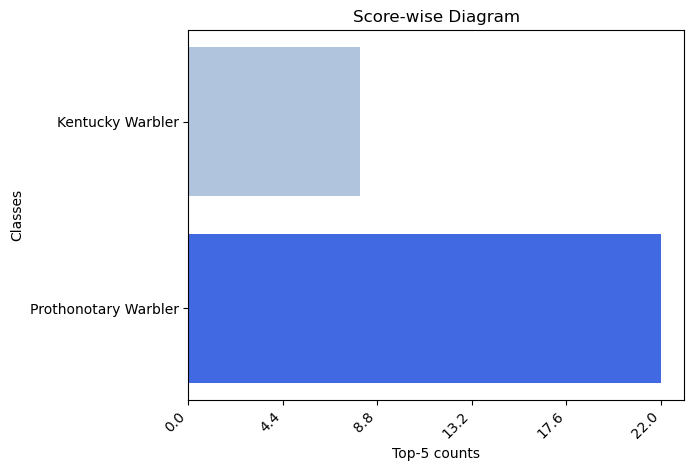

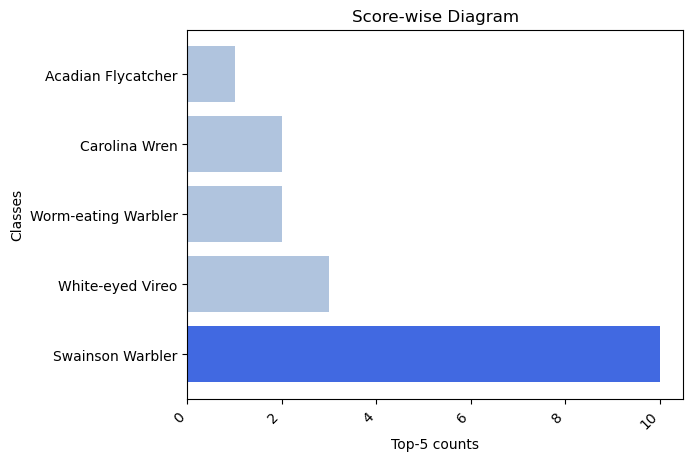

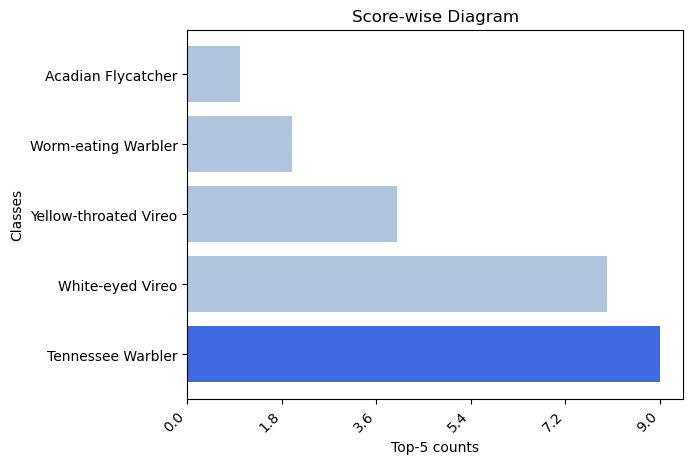

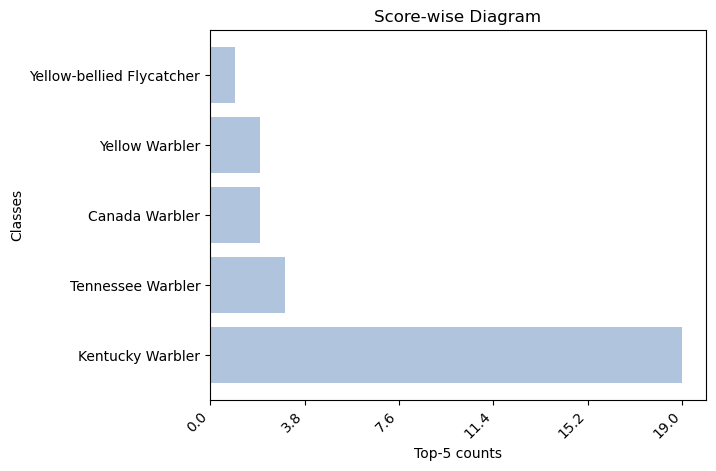

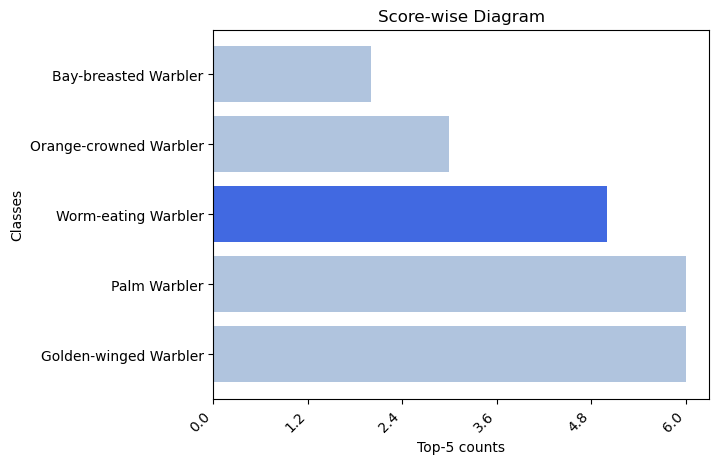

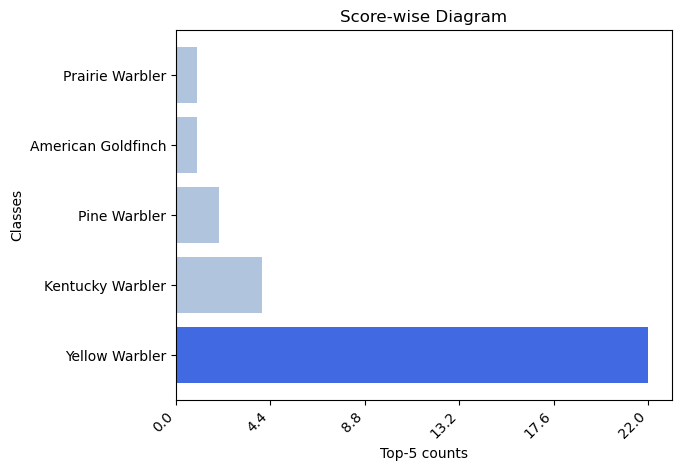

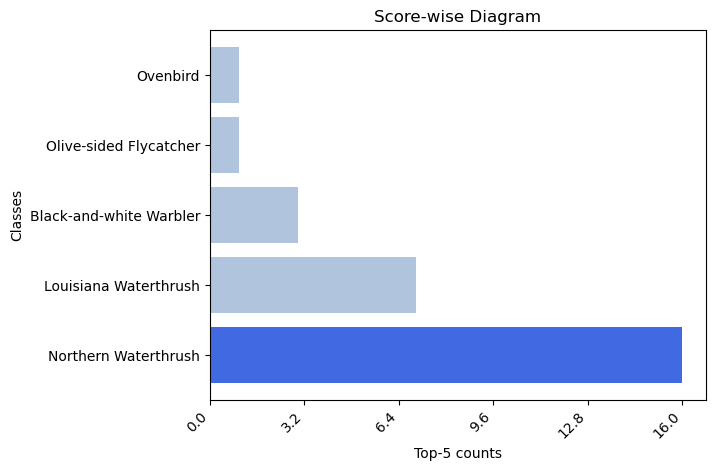

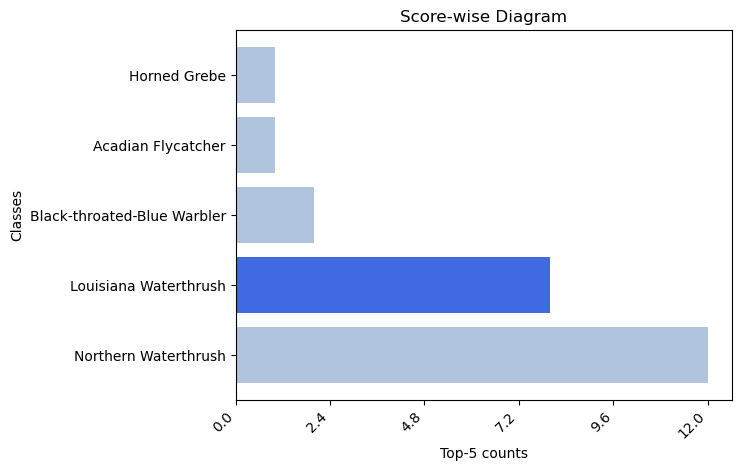

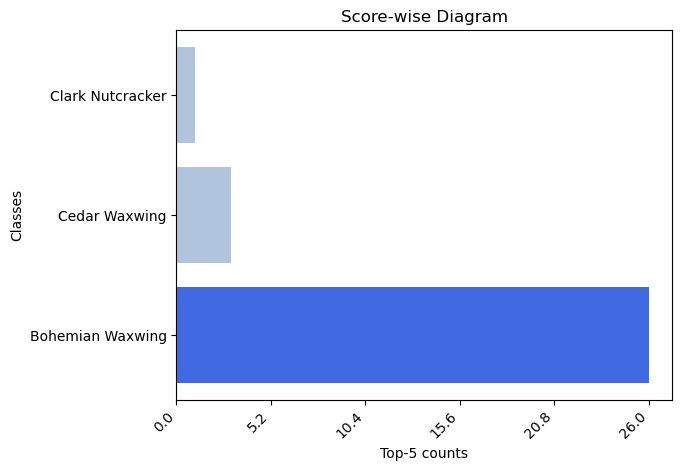

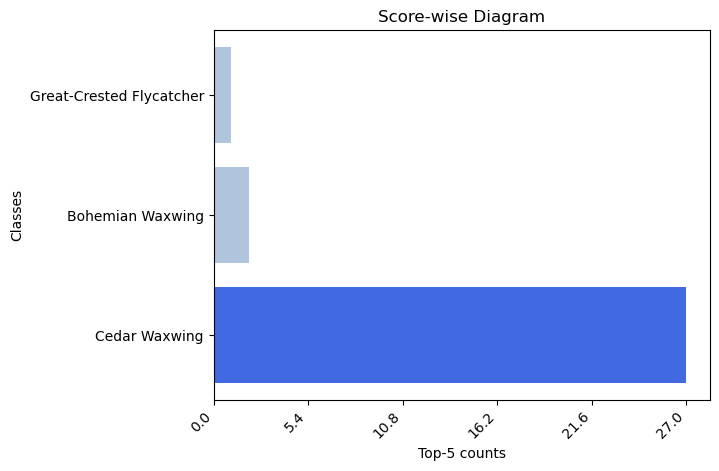

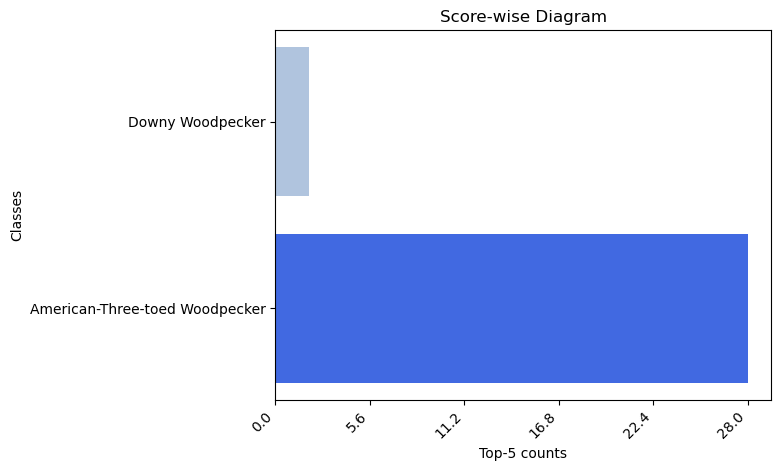

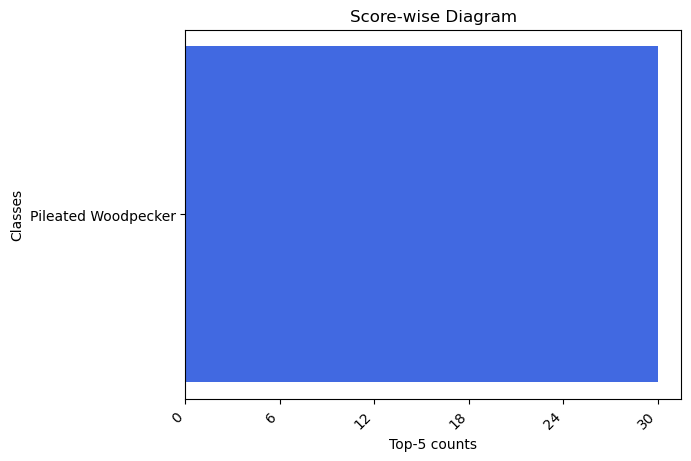

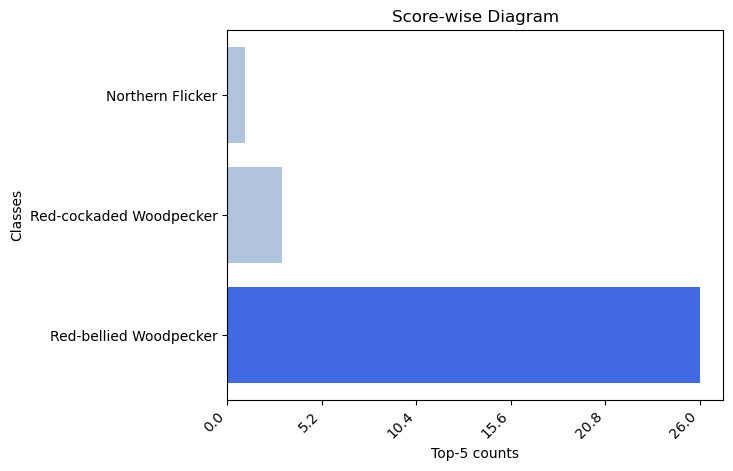

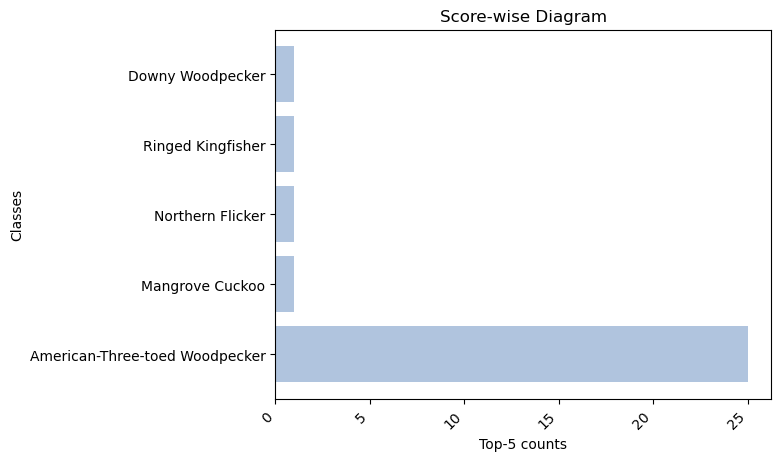

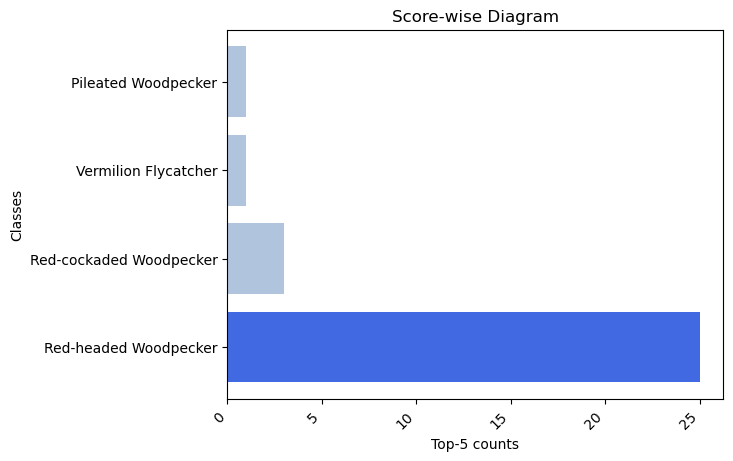

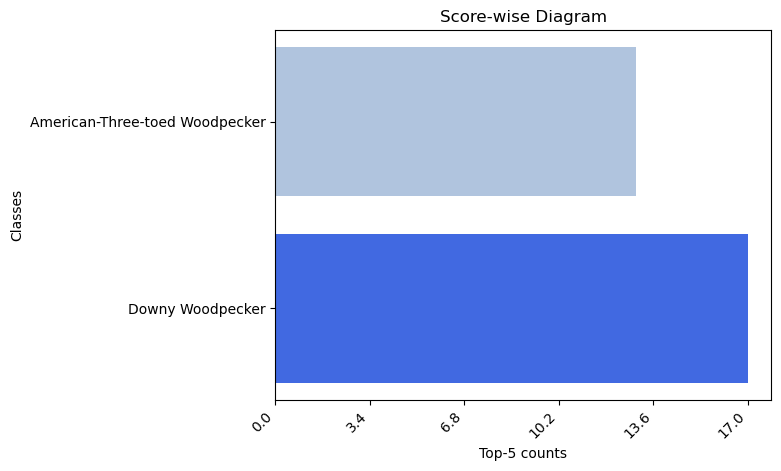

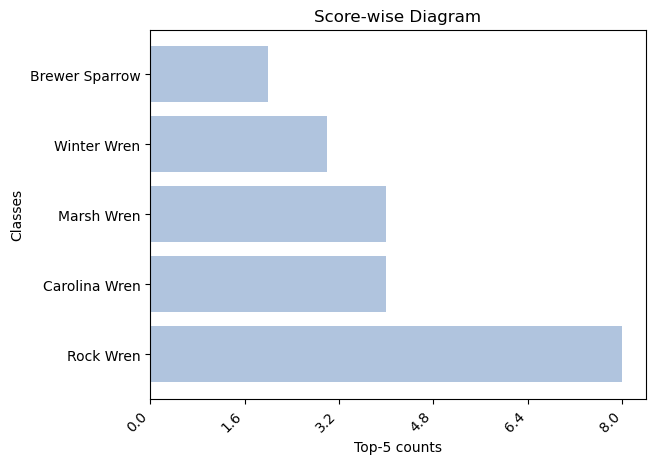

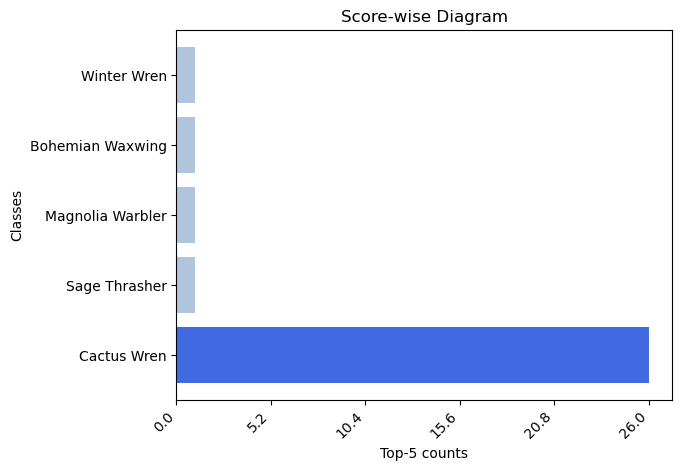

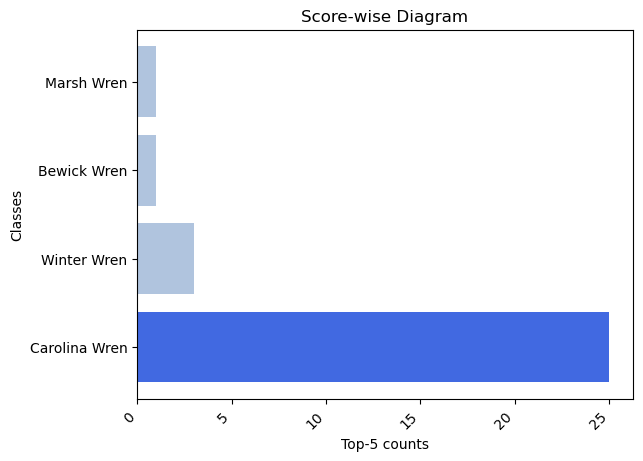

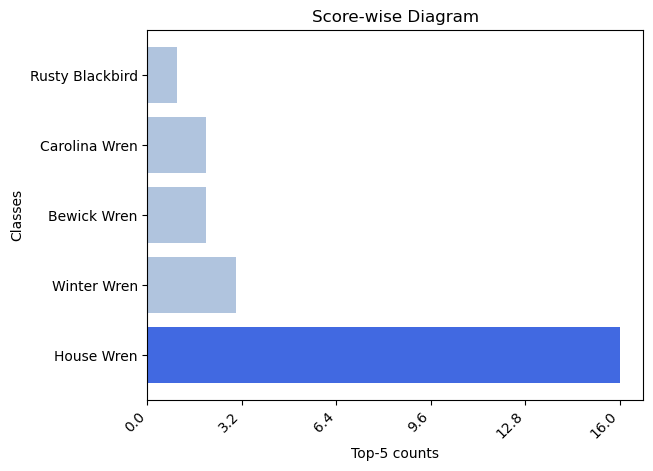

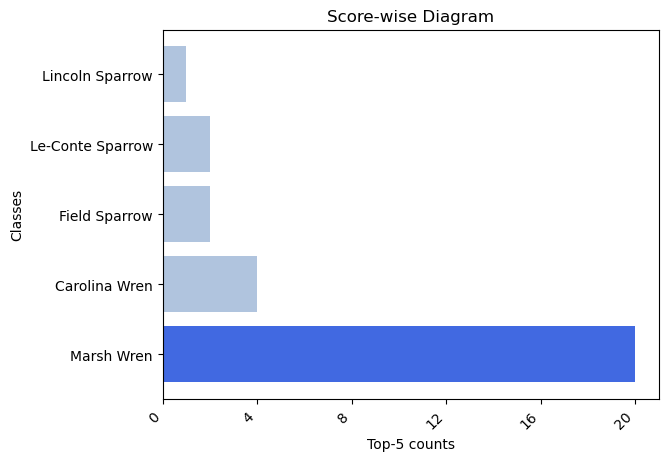

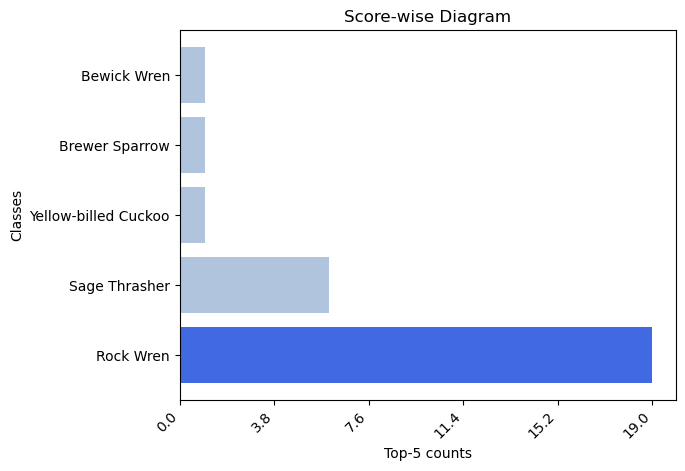

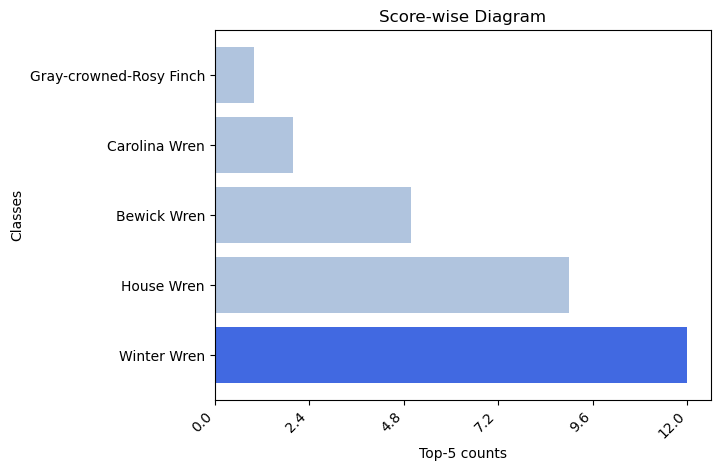

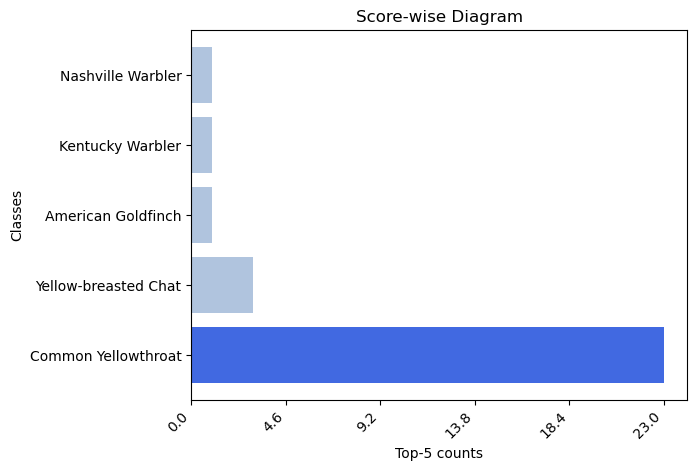

In [54]:
with open('top1.txt', 'r') as file:
    top = json.load(file)

for class_ in top.keys():
    greater_than_zero = []
    for top_item in top[class_]:
        if top_item[1] > 0:
            greater_than_zero.append(top_item)
    top[class_] = greater_than_zero
    create_graph(class_, top[class_][:min(len(greater_than_zero), 5)])

In [64]:
top[class_][0:5]

# [['Common Yellowthroat', 27],
#  ['Tennessee Warbler', 2],
#  ['Hooded Warbler', 1],
#  ['Black-footed Albatross', 0],
#  ['Laysan Albatross', 0]]

[['Common Yellowthroat', 23],
 ['Yellow-breasted Chat', 3],
 ['American Goldfinch', 1],
 ['Kentucky Warbler', 1],
 ['Nashville Warbler', 1]]

# Generate attributes functions

In [65]:
def logs():
    logging.basicConfig(
        level=logging.DEBUG,            # Set the minimum log level to DEBUG
        filename='gpt_3_my_cub.log',        # Specify the log file name
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    logger = logging.getLogger(__name__)
    return logger


In [66]:
def get_completion(prompt, logger, model="gpt-3.5-turbo", temperature=0., max_tokens=300):
    messages = [{'role':'system', 'content':"""
    Use this as an example to generate you answers for user's query. Give the answer in a JSON format just like given in the example

    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?
       A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-


        {
            "tiger": [
                     "has orange coats with vertical 'black' stripes",
                     "are generally larger and robust",
                     "often have a more rounded face with prominent cheekbones",
                     "ears are usually smaller and rounded",
                     "tails are long and have a characteristic 'white spot' at the tip",
                     "are found in a variety of habitats, including dense forests and grasslands"
                     ],

            "lion": [
                    "typically have a tawny or 'beige coat', and their fur is often smoother and they have a mane",
                    "has a more compact and muscular build",
                    "lions may have a more squared-off face",
                    "ears are large and often have a more pointed shape",
                    "tails are shorter, ending in a tuft of hair",
                    "habitats are savannas and open woodlands"
                    ]
        }
        ```
    Remember not to use the first class name in the response of second class and vice-a-versa. For example here, in the answer for tiger do not use lion and in answer for lion do not use the word tiger.
"""},
    {"role": "user", "content": prompt}]
    
    try:
        logger.debug(f'Input: {messages}')
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        logger.debug(f'Output: {response}')
    except Exception as e:
        logger.error(f'error: {str(e)}')
        raise e
    return response.choices[0].message["content"]

# Create Attributes of Pairs from Top-1 Distribution

In [67]:
def generate_attributes(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
    print(prompt)
    response = get_completion(prompt, logger)
#     response = get_completion_dummy(prompt)
    answer = response
    print(response)
    
    return answer

In [68]:
def generate_attributes_dummy(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
#     print(prompt)
    return """aasdasd
    asfasfasfdas
    {
    "Laysan Albatross": [
    "have a white head and neck with a dark eye patch",
    "have a black upperwing with a white trailing edge",
    "underside is mostly white with dark edges on the underwing",
    "have a pink bill with a dark tip",
    "are generally medium-sized with a wingspan of around 6 feet",
    "nest in the Northwestern Hawaiian Islands"
    ],

    "Sooty Albatross": [
        "have a dark plumage overall, including the head and neck",
        "have a uniformly dark upperwing without a distinct pattern",
        "underside is dark, often with paler edges on the underwing",
        "have a dark bill without significant markings",
        "are larger in size with a wingspan of around 7 feet",
        "nest on sub-Antarctic islands and some isolated islands in the Southern Ocean"
    ]
    }sfsdfsdfsdf"""

In [69]:
def process_response(response):
    try:
        json_response = response
        json.loads(json_response)
    except Exception as e:
        lines = response.split('\n')
        json_response = ''
        for index, line in enumerate(lines):
            if line.find('{') != -1:
                json_response = line[line.find('{'):] + "\n"
                index += 1
                while index < len(lines) and lines[index].find('}') == -1:
                    json_response += lines[index]
                    index += 1
                if index < len(lines) and lines[index].find('}') != -1:
                    json_response += lines[index][:lines[index].find('}')+1]
                    break
                else:
                    html_string = f'<font color="red">{str(response)}</font>'
                    display(HTML(html_string))
    return json.loads(json_response)

In [70]:
def convert_to_json(diff_dict):
    dict_ = diff_dict.copy()
    for key in dict_.keys():
        dict_[key] = list(dict_[key])
    return json.dumps(dict_, indent=4)

In [71]:
diff_dict = dict()
already_seen = set()
total_pairs = 0

In [72]:
for class_ in tqdm(top.keys()):
    if class_ not in diff_dict:
        diff_dict[class_] = set()
    number_of_pairs = 0
    for top_class, count in top[class_][0:6]:
        if top_class not in diff_dict:
            diff_dict[top_class] = set()
        if class_ == top_class or (class_, top_class) in already_seen or number_of_pairs >=5 or count < 1:
            continue
        response = generate_attributes(class_, top_class)
        try:
            json_response = process_response(response)
            keys = list(json_response.keys())
            fixed_json_response = dict()
            fixed_json_response[class_] = json_response[keys[0]]
            fixed_json_response[top_class] = json_response[keys[1]]
        except:
            print("Could not process the input, continue...")
            continue
            
        if class_ in diff_dict:
            diff_dict[class_] |= set(fixed_json_response[class_])
        if top_class in diff_dict:
            diff_dict[top_class] |= set(fixed_json_response[top_class])
            
        already_seen.add((class_, top_class))
        already_seen.add((top_class, class_))
        number_of_pairs += 1
        total_pairs += 1
        
        descriptor_json = convert_to_json(diff_dict)
        with open(f'descriptors_cub_top1.json', 'w') as file:
            file.write(descriptor_json)
    

  0%|                                                                                                                         | 0/200 [00:00<?, ?it/s]


    Q: What are useful features for distinguishing a Black-footed Albatross from Laysan Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Black-footed Albatross and a Laysan Albatross in a photo
    
{
    "Black-footed Albatross": [
        "has a dark brown or blackish body with a white head and neck",
        "wings are long and narrow",
        "has a yellow bill with a dark tip",
        "feet are black",
        "has a wingspan of about 6 feet"
    ],
    "Laysan Albatross": [
        "has a white body with a black back and wings",
        "wings are broad and rounded",
        "has a pink bill with a dark tip",
        "feet are pink",
        "has a wingspan of about 7 feet"
    ]
}

    Q: What are useful features for distinguishing a Black-footed Albatross from Northern Fulmar in a photo?
    A: There are several useful visual features to tell the difference between a Black-footed Albatross and a Northern Fulmar in a photo

  0%|▌                                                                                                                | 1/200 [00:13<46:22, 13.98s/it]

{
    "Black-footed Albatross": [
        "has a black body with white underparts",
        "has a large wingspan and a long, narrow beak",
        "has dark feathers on the upper side of the wings",
        "has a distinctive black patch around the eyes",
        "is usually found in open ocean habitats"
    ],
    "Pigeon Guillemot": [
        "has a black body with white wing patches",
        "has a shorter wingspan and a shorter, thicker beak",
        "has white feathers on the upper side of the wings",
        "has bright red feet and legs",
        "is usually found in coastal habitats"
    ]
}

    Q: What are useful features for distinguishing a Laysan Albatross from Sooty Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Laysan Albatross and a Sooty Albatross in a photo
    
{
    "Laysan Albatross": [
        "has a white head and neck",
        "has a dark gray back and wings",
        "has a yellow bill with a dark tip"

  1%|█▏                                                                                                               | 2/200 [00:26<43:03, 13.05s/it]

{
    "Laysan Albatross": [
        "has a white body with black wings and a black tail",
        "has a large wingspan, measuring up to 6.5 feet",
        "has a long, slender bill",
        "has webbed feet for swimming and diving",
        "is typically found near coastal areas and open ocean"
    ],
    "Long-tailed Jaeger": [
        "has a dark brown body with a lighter brown head and neck",
        "has long, pointed wings",
        "has a short, hooked bill",
        "has a long, forked tail",
        "is typically found in Arctic and subarctic regions"
    ]
}

    Q: What are useful features for distinguishing a Sooty Albatross from Long-tailed Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Sooty Albatross and a Long-tailed Jaeger in a photo
    
{
    "Sooty Albatross": [
        "has a dark brown or blackish plumage",
        "has a large wingspan and a long, slender body",
        "has a hooked bill",
        "has a whit

  2%|█▋                                                                                                               | 3/200 [00:37<39:18, 11.97s/it]

{
    "Sooty Albatross": [
        "has a dark brown or black plumage",
        "has a large wingspan, typically around 7 feet",
        "has a long, slender body",
        "has a hooked bill",
        "has a white patch on the underwing",
        "is typically found in open ocean habitats"
    ],
    "Glaucous-winged Gull": [
        "has a gray or white plumage",
        "has a wingspan of around 4 to 5 feet",
        "has a bulky body",
        "has a straight bill",
        "has gray wings with white tips",
        "is typically found in coastal habitats"
    ]
}

    Q: What are useful features for distinguishing a Groove-billed Ani from American Crow in a photo?
    A: There are several useful visual features to tell the difference between a Groove-billed Ani and a American Crow in a photo
    
{
    "Groove-billed Ani": [
        "has a long, curved bill with distinct grooves",
        "has a black body with a gray head and neck",
        "has a long tail with white tips",
     

  2%|██▎                                                                                                              | 4/200 [00:54<45:55, 14.06s/it]

{
    "Groove-billed Ani": [
        "has a black body with a long, curved bill",
        "has a distinctive groove on the upper mandible of its bill",
        "has a white patch on the wings",
        "has a long tail with white tips",
        "often seen in small groups or pairs"
    ],
    "Shiny Cowbird": [
        "has a black body with a shorter, straight bill",
        "does not have a groove on its bill",
        "does not have a white patch on the wings",
        "has a shorter tail without white tips",
        "often seen in larger flocks or mixed-species groups"
    ]
}

    Q: What are useful features for distinguishing a Crested Auklet from Rhinoceros Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Crested Auklet and a Rhinoceros Auklet in a photo
    
{
    "Crested Auklet": [
        "has a distinctive crest on its head that resembles a horn",
        "has a black body with white patches on the face and neck",
        "

  2%|██▊                                                                                                              | 5/200 [01:10<48:23, 14.89s/it]

{
    "Crested Auklet": [
        "has a distinctive crest on the top of its head",
        "has a black body with white patches on the face and neck",
        "has bright orange legs and feet",
        "has a long, thin bill with a curved tip",
        "is larger in size compared to the Least Auklet",
        "is often found in coastal areas and rocky cliffs"
    ],
    "Least Auklet": [
        "has a plain black body without any distinctive markings",
        "has a short, stubby bill",
        "has dark gray legs and feet",
        "is smaller in size compared to the Crested Auklet",
        "is often found in open ocean and sea ice habitats"
    ]
}

    Q: What are useful features for distinguishing a Least Auklet from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Least Auklet and a Parakeet Auklet in a photo
    
{
    "Least Auklet": [
        "has a small size, measuring about 15-17 cm in length",
        "has a da

  3%|███▍                                                                                                             | 6/200 [01:27<50:08, 15.51s/it]

{
    "Least Auklet": [
        "has a small size, measuring about 15-20 cm in length",
        "has a dark gray or black plumage",
        "has a short, stubby bill",
        "has a white patch on the underwing",
        "has a rounded head and body shape",
        "is typically found in marine environments, such as coastal areas and offshore islands"
    ],
    "Pied Kingfisher": [
        "has a medium to large size, measuring about 17-23 cm in length",
        "has a black and white plumage",
        "has a long, pointed bill",
        "has a black band across the breast",
        "has a sleek and streamlined body shape",
        "is typically found near freshwater habitats, such as rivers, lakes, and ponds"
    ]
}

    Q: What are useful features for distinguishing a Parakeet Auklet from Rhinoceros Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Parakeet Auklet and a Rhinoceros Auklet in a photo
    
{
    "Parakeet Auklet": [
 

  4%|███▉                                                                                                             | 7/200 [01:43<50:19, 15.65s/it]

{
    "Parakeet Auklet": [
        "has a black head and neck",
        "has a white body",
        "has a small, pointed bill",
        "has a short tail",
        "has a distinctive white patch on the wings"
    ],
    "Dark-eyed Junco": [
        "has a gray or brown body",
        "has a white belly",
        "has a medium-sized, conical bill",
        "has a long tail",
        "has dark markings on the wings"
    ]
}

    Q: What are useful features for distinguishing a Rhinoceros Auklet from Gadwall in a photo?
    A: There are several useful visual features to tell the difference between a Rhinoceros Auklet and a Gadwall in a photo
    
{
    "Rhinoceros Auklet": [
        "has a black body with a white belly",
        "has a distinctive horn-like projection on its bill",
        "has a short, stout body with a stocky neck",
        "has a small, rounded head",
        "has short wings and a short, square tail",
        "is typically found in marine environments, such as coasta

  4%|████▌                                                                                                            | 8/200 [01:55<46:27, 14.52s/it]

{
    "Rhinoceros Auklet": [
        "has a black body with a white belly",
        "has a distinctive horn-like projection on its bill during breeding season",
        "has a short, stout bill",
        "has a stocky body shape",
        "has a white patch on its face that extends from the eye to the bill"
    ],
    "Horned Grebe": [
        "has a black and white body with a reddish neck and head during breeding season",
        "has a slender bill",
        "has a sleek and streamlined body shape",
        "has a black cap on its head that extends to the eyes",
        "has a white patch on its face that extends from the eye to the bill"
    ]
}

    Q: What are useful features for distinguishing a Brewer Blackbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Brewer Blackbird and a Boat-tailed Grackle in a photo
    
{
    "Brewer Blackbird": [
        "has a black plumage with a glossy sheen",
        "males 

  4%|█████                                                                                                            | 9/200 [02:14<51:12, 16.09s/it]

{
    "Brewer Blackbird": [
        "has a glossy black plumage",
        "males have bright yellow eyes",
        "females have dark brown eyes",
        "has a long and slender bill",
        "has a slightly iridescent sheen on its feathers"
    ],
    "Rusty Blackbird": [
        "has a dark brown to black plumage",
        "males have yellow eyes",
        "females have dark brown eyes",
        "has a shorter and thicker bill",
        "has a rusty or reddish-brown coloration on its feathers"
    ]
}

    Q: What are useful features for distinguishing a Red-winged Blackbird from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Red-winged Blackbird and a Parakeet Auklet in a photo
    
{
    "Red-winged Blackbird": [
        "has a black body with red and yellow shoulder patches",
        "males have a distinctive red and yellow epaulet on their wings",
        "females have a more subdued coloration with brown streaks on 

  5%|█████▌                                                                                                          | 10/200 [02:36<56:36, 17.88s/it]

{
    "Red-winged Blackbird": [
        "has a black body with a red patch on the shoulder",
        "males have a distinctive red and yellow shoulder patch",
        "females have a smaller, more subdued shoulder patch",
        "has a conical bill",
        "has a slender body shape",
        "often seen perched on cattails or other tall vegetation near water"
    ],
    "Pileated Woodpecker": [
        "has a black body with a white stripe down the neck",
        "has a prominent red crest on the head",
        "has a large, chisel-like bill",
        "has a stocky body shape",
        "often seen foraging on tree trunks for insects",
        "may leave distinctive rectangular-shaped holes in trees"
    ]
}

    Q: What are useful features for distinguishing a Rusty Blackbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Rusty Blackbird and a Boat-tailed Grackle in a photo
    
{
    "Rusty Blackbird": [
       

  6%|██████▏                                                                                                         | 11/200 [02:54<55:40, 17.68s/it]

{
    "Rusty Blackbird": [
        "has a glossy black plumage",
        "has a yellow eye",
        "has a long, pointed bill",
        "has a slightly larger size compared to Myrtle Warbler",
        "often seen in wetland habitats"
    ],
    "Myrtle Warbler": [
        "has a yellow throat and breast",
        "has a gray back and wings",
        "has a white belly",
        "has a white eye-ring",
        "has a shorter, thinner bill",
        "often seen in forested habitats"
    ]
}

    Q: What are useful features for distinguishing a Yellow-headed Blackbird from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-headed Blackbird and a Yellow-breasted Chat in a photo
    
{
    "Yellow-headed Blackbird": [
        "has a black body with a bright yellow head",
        "has a long, pointed bill",
        "has a white wing patch that is visible in flight",
        "often seen in marshy areas or near water",
    

  6%|██████▋                                                                                                         | 12/200 [03:02<46:23, 14.80s/it]

{
    "Yellow-headed Blackbird": [
        "has a black body with a bright yellow head",
        "has a long, pointed bill",
        "has a white wing patch that is visible in flight",
        "has a shorter tail compared to the Hooded Oriole",
        "is larger in size compared to the Hooded Oriole",
        "is commonly found in wetland habitats"
    ],
    "Hooded Oriole": [
        "has a black body with a bright yellow hood",
        "has a slightly curved bill",
        "has a black bib on the chest",
        "has a longer tail compared to the Yellow-headed Blackbird",
        "is smaller in size compared to the Yellow-headed Blackbird",
        "is commonly found in open woodlands and gardens"
    ]
}

    Q: What are useful features for distinguishing a Bobolink from Yellow-headed Blackbird in a photo?
    A: There are several useful visual features to tell the difference between a Bobolink and a Yellow-headed Blackbird in a photo
    
{
    "Bobolink": [
        "has a black 

  6%|███████▎                                                                                                        | 13/200 [03:10<39:54, 12.81s/it]

{
    "Bobolink": [
        "Bobolinks have a black and white plumage with a yellowish patch on the back of their head",
        "They have a stout body with a short tail",
        "Their bill is short and pointed",
        "Bobolinks have a distinctive song that is often heard during their breeding season"
    ],
    "Bewick Wren": [
        "Bewick Wrens have a brownish plumage with darker streaks on their back",
        "They have a slender body with a long tail that is often held upright",
        "Their bill is thin and slightly curved",
        "Bewick Wrens have a melodious song that is often heard throughout the year"
    ]
}

    Q: What are useful features for distinguishing a Indigo Bunting from Lazuli Bunting in a photo?
    A: There are several useful visual features to tell the difference between a Indigo Bunting and a Lazuli Bunting in a photo
    
{
    "Indigo Bunting": [
        "has bright blue plumage",
        "has a small, conical bill",
        "has a black face 

  7%|███████▊                                                                                                        | 14/200 [03:20<37:06, 11.97s/it]

{
    "Indigo Bunting": [
        "has bright blue plumage",
        "has a small, conical beak",
        "has a slender body shape",
        "often found in North America",
        "has a distinctive black mask around the eyes"
    ],
    "Cape-Glossy Starling": [
        "has iridescent black plumage",
        "has a longer, curved beak",
        "has a more robust body shape",
        "often found in Africa",
        "has a glossy sheen to its feathers"
    ]
}

    Q: What are useful features for distinguishing a Lazuli Bunting from Cerulean Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Lazuli Bunting and a Cerulean Warbler in a photo
    
{
    "Lazuli Bunting": [
        "has bright blue plumage on the head, back, and wings",
        "has a white belly and chest",
        "has a black face mask that extends from the eye to the throat",
        "has a short, conical bill",
        "has a long, notched tail",
        "is typica

  8%|████████▍                                                                                                       | 15/200 [03:33<37:30, 12.17s/it]

{
    "Lazuli Bunting": [
        "has bright blue plumage on the head, back, and wings",
        "has a white belly and breast",
        "has a small, conical bill",
        "has a slender body shape",
        "often perches on branches or wires",
        "habitat includes open woodlands and brushy areas"
    ],
    "Belted Kingfisher": [
        "has a blue-gray plumage on the head, back, and wings",
        "has a white belly with a blue-gray breast band",
        "has a large, dagger-like bill",
        "has a stocky body shape",
        "often perches near water bodies, such as rivers or lakes",
        "habitat includes freshwater habitats with fish-rich waters"
    ]
}

    Q: What are useful features for distinguishing a Painted Bunting from American Goldfinch in a photo?
    A: There are several useful visual features to tell the difference between a Painted Bunting and a American Goldfinch in a photo
    
{
    "Painted Bunting": [
        "has a bright blue head and back",
 

  8%|████████▉                                                                                                       | 16/200 [03:45<37:04, 12.09s/it]

{
    "Painted Bunting": [
        "has a vibrant blue head and bright red breast",
        "wings are greenish with blue and yellow patches",
        "back and tail feathers are green",
        "bill is short and conical",
        "habitat is typically brushy areas and woodland edges"
    ],
    "Yellow-throated Vireo": [
        "has a yellow throat and breast",
        "wings are grayish-green with two white wing bars",
        "back and tail feathers are olive-green",
        "bill is slender and pointed",
        "habitat is usually deciduous and mixed forests"
    ]
}

    Q: What are useful features for distinguishing a Cardinal from Vermilion Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Cardinal and a Vermilion Flycatcher in a photo
    
{
    "Cardinal": [
        "has a bright red plumage",
        "has a distinctive crest on its head",
        "has a black face mask",
        "has a thick, cone-shaped bill",
        

  8%|█████████▌                                                                                                      | 17/200 [04:03<42:33, 13.96s/it]

{
    "Cardinal": [
        "has a bright red plumage",
        "has a distinctive crest on its head",
        "has a black face mask",
        "has a thick, cone-shaped bill",
        "has a long tail",
        "is larger in size compared to the Gray-crowned-Rosy Finch"
    ],
    "Gray-crowned-Rosy Finch": [
        "has a gray plumage with rosy pink on its head and breast",
        "has a small crest on its head",
        "has a pale face",
        "has a slender, pointed bill",
        "has a short tail",
        "is smaller in size compared to the Cardinal"
    ]
}

    Q: What are useful features for distinguishing a Spotted Catbird from Green Jay in a photo?
    A: There are several useful visual features to tell the difference between a Spotted Catbird and a Green Jay in a photo
    
{
    "Spotted Catbird": [
        "has a dark gray or black plumage with white spots on the chest and belly",
        "has a long tail and a slender body",
        "has a distinctive crest on the 

  9%|██████████                                                                                                      | 18/200 [04:27<51:56, 17.12s/it]

{
    "Spotted Catbird": [
        "has a dark gray or black head with a prominent white spot behind the eye",
        "has a gray body with black spots or streaks",
        "has a long tail with white tips on the outer feathers",
        "has a thick bill",
        "is larger in size compared to Wilson Warbler",
        "is typically found in dense forests or thickets"
    ],
    "Wilson Warbler": [
        "has a bright yellow body with a black cap on the head",
        "has a thin bill",
        "has a short tail",
        "has black streaks on the back and wings",
        "has white underparts",
        "is smaller in size compared to Spotted Catbird",
        "is typically found in open woodlands or shrubby areas"
    ]
}

    Q: What are useful features for distinguishing a Gray Catbird from Bronzed Cowbird in a photo?
    A: There are several useful visual features to tell the difference between a Gray Catbird and a Bronzed Cowbird in a photo
    
{
    "Gray Catbird": [
       

 10%|██████████▋                                                                                                     | 19/200 [04:43<50:11, 16.64s/it]

{
    "Gray Catbird": [
        "has a gray body with a black cap on its head",
        "has a long, slender bill",
        "has a long, rounded tail",
        "has a black patch under its tail",
        "has a plain gray breast and belly"
    ],
    "American Redstart": [
        "has a black body with bright orange patches on its sides, wings, and tail",
        "has a thin, pointed bill",
        "has a short, square tail",
        "has white patches on its wings",
        "has a black breast and belly"
    ]
}

    Q: What are useful features for distinguishing a Yellow-breasted Chat from Yellow-bellied Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-breasted Chat and a Yellow-bellied Flycatcher in a photo
    
{
    "Yellow-breasted Chat": [
        "has a yellow breast with a white belly",
        "has a long tail and a large bill",
        "often has a gray or olive-green back",
        "may have a black mask around 

 10%|███████████▏                                                                                                    | 20/200 [05:00<50:45, 16.92s/it]

{
    "Yellow-breasted Chat": [
        "has a yellow breast and belly",
        "has a grayish-brown back and wings",
        "has a long tail",
        "has a white eye-ring",
        "has a black bill",
        "has a distinctive white patch on the side of the neck"
    ],
    "Nashville Warbler": [
        "has a yellow throat and breast",
        "has a grayish-green back and wings",
        "has a short tail",
        "has a white eye-ring",
        "has a thin pointed bill",
        "has a distinctive gray hood on the head"
    ]
}

    Q: What are useful features for distinguishing a Eastern Towhee from American Redstart in a photo?
    A: There are several useful visual features to tell the difference between a Eastern Towhee and a American Redstart in a photo
    


 10%|███████████▊                                                                                                    | 21/200 [05:04<38:19, 12.85s/it]

{
    "Eastern Towhee": [
        "has a black head and upper body",
        "has a white belly",
        "has rufous-colored sides",
        "has white wing bars",
        "has a long tail",
        "has a red eye",
        "has a thick bill"
    ],
    "American Redstart": [
        "has a black head and upper body",
        "has a white belly",
        "has orange patches on the sides",
        "has white wing patches",
        "has a long tail",
        "has a white eye ring",
        "has a thin bill"
    ]
}

    Q: What are useful features for distinguishing a Chuck-will Widow from Cactus Wren in a photo?
    A: There are several useful visual features to tell the difference between a Chuck-will Widow and a Cactus Wren in a photo
    
{
    "Chuck-will Widow": [
        "has a mottled brown and gray plumage",
        "has a long, slender body with a rounded head",
        "has a large mouth with a wide gape",
        "has a short tail with white spots",
        "has a distinctiv

 11%|████████████▎                                                                                                   | 22/200 [05:22<43:18, 14.60s/it]

{
    "Chuck-will Widow": [
        "has a mottled brown and black plumage",
        "has a long and slender body",
        "has a large head with a wide mouth",
        "has a distinct white patch on the throat",
        "has long wings and a short tail",
        "is typically found in wooded areas and forests"
    ],
    "Rusty Blackbird": [
        "has a glossy black plumage",
        "has a compact and stocky body",
        "has a small head with a pointed bill",
        "does not have any distinct markings on the throat",
        "has short wings and a long tail",
        "is typically found in wetlands and marshes"
    ]
}

    Q: What are useful features for distinguishing a Brandt Cormorant from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Brandt Cormorant and a Pelagic Cormorant in a photo
    
{
    "Brandt Cormorant": [
        "has a black body with a white patch on the thigh",
        "has a slender build w

 12%|████████████▉                                                                                                   | 23/200 [05:42<47:20, 16.05s/it]

{
    "Brandt Cormorant": [
        "has a black body with a white patch on the thigh",
        "has a long, slender neck",
        "has a hooked bill",
        "has a small, rounded head",
        "has a long, thin tail",
        "is usually found near coastal areas"
    ],
    "Pigeon Guillemot": [
        "has a black body with white wing patches",
        "has a short, stout neck",
        "has a straight bill",
        "has a larger, more angular head",
        "has a short, square tail",
        "is usually found near rocky shorelines"
    ]
}

    Q: What are useful features for distinguishing a Red-faced Cormorant from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Red-faced Cormorant and a Pelagic Cormorant in a photo
    
{
    "Red-faced Cormorant": [
        "has a red face and throat during breeding season",
        "has a black body with a white patch on the flank",
        "has a long, slender bill",
       

 12%|█████████████▍                                                                                                  | 24/200 [05:56<45:13, 15.42s/it]

{
    "Red-faced Cormorant": [
        "has a red face and throat",
        "has a black body with a white patch on the flank",
        "has a long, slender bill",
        "has a long neck and a slender body",
        "has webbed feet for swimming"
    ],
    "Pigeon Guillemot": [
        "has a black body with white wing patches",
        "has a black head and neck",
        "has a short, stout bill",
        "has a short neck and a compact body",
        "has webbed feet for swimming"
    ]
}

    Q: What are useful features for distinguishing a Pelagic Cormorant from Laysan Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Pelagic Cormorant and a Laysan Albatross in a photo
    
{
    "Pelagic Cormorant": [
        "has a dark brown or black plumage",
        "has a slender body with a long neck",
        "has a hooked bill",
        "has webbed feet for swimming",
        "is smaller in size compared to the Laysan Albatross",
   

 12%|██████████████                                                                                                  | 25/200 [06:08<41:58, 14.39s/it]

{
    "Pelagic Cormorant": [
        "has a dark black or brown plumage",
        "has a long, slender body with a long neck",
        "has a hooked bill",
        "has webbed feet for swimming",
        "often seen near coastal areas or bodies of water"
    ],
    "Yellow-headed Blackbird": [
        "has a black body with a bright yellow head and chest",
        "has a stocky build",
        "has a conical bill",
        "has perching feet",
        "often seen in marshes or wetland habitats"
    ]
}

    Q: What are useful features for distinguishing a Bronzed Cowbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Bronzed Cowbird and a Boat-tailed Grackle in a photo
    
{
    "Bronzed Cowbird": [
        "has a glossy black plumage",
        "males have a brownish-bronze iridescence on their head and upper body",
        "females have a more dull brown plumage",
        "has a long, slender bill",
        "has a

 13%|██████████████▌                                                                                                 | 26/200 [06:26<45:01, 15.52s/it]

{
    "Bronzed Cowbird": [
        "has a glossy black plumage with a brownish sheen",
        "males have a bright red eye and a thick, black bill",
        "females have a dark eye and a smaller bill",
        "has a long, pointed tail",
        "is larger in size compared to the Least Auklet",
        "is typically found in open habitats like grasslands and agricultural areas"
    ],
    "Least Auklet": [
        "has a dark gray plumage with a white belly",
        "has a short, stubby bill",
        "has a rounded body shape",
        "has short wings and a short tail",
        "is smaller in size compared to the Bronzed Cowbird",
        "is typically found in marine habitats like rocky cliffs and islands"
    ]
}

    Q: What are useful features for distinguishing a Shiny Cowbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Shiny Cowbird and a Boat-tailed Grackle in a photo
    
{
    "Shiny Cowbird": [
   

 14%|███████████████                                                                                                 | 27/200 [06:42<44:53, 15.57s/it]

{
    "Shiny Cowbird": [
        "has a shiny black plumage",
        "males have a bright red eye",
        "females have a brownish-gray plumage with streaks",
        "has a slender body shape",
        "has a long tail",
        "often seen in open habitats such as grasslands and agricultural fields"
    ],
    "Rusty Blackbird": [
        "has a dark brown to black plumage",
        "males have yellow eyes",
        "females have a lighter brown plumage with streaks",
        "has a stocky body shape",
        "has a shorter tail",
        "often seen in wetland habitats such as marshes and swamps"
    ]
}

    Q: What are useful features for distinguishing a Brown Creeper from Dark-eyed Junco in a photo?
    A: There are several useful visual features to tell the difference between a Brown Creeper and a Dark-eyed Junco in a photo
    
{
    "Brown Creeper": [
        "has a brown upper body with streaks",
        "has a white underbody",
        "has a long, curved bill",
       

 14%|███████████████▋                                                                                                | 28/200 [06:54<41:26, 14.46s/it]

{
    "Brown Creeper": [
        "has a brown and white mottled plumage",
        "has a long, slender body with a curved bill",
        "often seen climbing up tree trunks in a spiral pattern",
        "has a streaked brown back and a white underside",
        "has a thin, pointed tail that is often pressed against the tree trunk"
    ],
    "Red-cockaded Woodpecker": [
        "has a black and white plumage",
        "has a medium-sized body with a straight bill",
        "often seen clinging to the sides of trees",
        "has a black back with white horizontal stripes",
        "has a white cheek patch and a small red patch on the side of the head"
    ]
}

    Q: What are useful features for distinguishing a American Crow from Common Raven in a photo?
    A: There are several useful visual features to tell the difference between a American Crow and a Common Raven in a photo
    
{
    "American Crow": [
        "has a smaller size compared to the Common Raven",
        "has a mor

 14%|████████████████▏                                                                                               | 29/200 [07:07<40:26, 14.19s/it]

{
    "American Crow": [
        "has a black body with a glossy sheen",
        "has a smaller size compared to the White-necked Raven",
        "has a straight bill",
        "has a rounded tail",
        "has a distinctive cawing sound"
    ],
    "White-necked Raven": [
        "has a black body with a glossy sheen",
        "has a larger size compared to the American Crow",
        "has a curved bill",
        "has a wedge-shaped tail",
        "has a deep croaking sound"
    ]
}

    Q: What are useful features for distinguishing a Fish Crow from Common Raven in a photo?
    A: There are several useful visual features to tell the difference between a Fish Crow and a Common Raven in a photo
    
{
    "Fish Crow": [
        "has a smaller size compared to a Common Raven",
        "has a more slender body shape",
        "has a shorter and less robust bill",
        "has a glossy black plumage",
        "has a distinctive nasal call"
    ],
    "Common Raven": [
        "has a larg

 15%|████████████████▊                                                                                               | 30/200 [07:21<39:52, 14.07s/it]

{
    "Fish Crow": [
        "has a smaller size compared to the White-necked Raven",
        "has a dark black coloration all over its body",
        "has a shorter and less curved bill",
        "has a more rounded head shape",
        "has a less pronounced throat hackle",
        "has a less prominent neck feathers"
    ],
    "White-necked Raven": [
        "has a larger size compared to the Fish Crow",
        "has a black coloration with a white neck collar",
        "has a longer and more curved bill",
        "has a more elongated head shape",
        "has a more pronounced throat hackle",
        "has more prominent neck feathers"
    ]
}

    Q: What are useful features for distinguishing a Black-billed Cuckoo from Yellow-billed Cuckoo in a photo?
    A: There are several useful visual features to tell the difference between a Black-billed Cuckoo and a Yellow-billed Cuckoo in a photo
    
{
    "Black-billed Cuckoo": [
        "has a black bill",
        "has a brownish-gray

 16%|█████████████████▎                                                                                              | 31/200 [07:40<43:32, 15.46s/it]

{
    "Black-billed Cuckoo": [
        "has a slender body with a long tail",
        "has a black bill",
        "has a brownish-gray plumage",
        "has a white belly with dark barring",
        "has a distinct white patch on the underside of the tail"
    ],
    "Olive-sided Flycatcher": [
        "has a stocky body with a short tail",
        "has a dark bill",
        "has a dark brown plumage",
        "has a white throat and belly",
        "has white patches on the sides of the breast"
    ]
}

    Q: What are useful features for distinguishing a Mangrove Cuckoo from Western-Wood Pewee in a photo?
    A: There are several useful visual features to tell the difference between a Mangrove Cuckoo and a Western-Wood Pewee in a photo
    
{
    "Mangrove Cuckoo": [
        "has a brownish-gray overall coloration",
        "has a long, curved bill",
        "has a white throat and chest",
        "has a distinctive black mask around the eyes",
        "has a long tail with white ti

 16%|█████████████████▉                                                                                              | 32/200 [07:56<44:16, 15.81s/it]

{
    "Mangrove Cuckoo": [
        "has a brownish-gray plumage with a long, curved bill",
        "has a distinctive white eyering",
        "has a long tail with white tips on the outer feathers",
        "often found in mangrove forests and coastal areas"
    ],
    "Tropical Kingbird": [
        "has a bright yellow plumage with a gray head and back",
        "has a short, straight bill",
        "has a relatively short tail",
        "often found in open habitats such as gardens, fields, and forest edges"
    ]
}

    Q: What are useful features for distinguishing a Yellow-billed Cuckoo from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-billed Cuckoo and a Olive-sided Flycatcher in a photo
    
{
    "Yellow-billed Cuckoo": [
        "has a long, slender body with a long tail",
        "has a yellow bill that is curved downward",
        "has a brownish-gray plumage with a white belly",
        "has a dis

 16%|██████████████████▍                                                                                             | 33/200 [08:11<43:06, 15.49s/it]

{
    "Yellow-billed Cuckoo": [
        "has a long, slender body with a long tail",
        "has a yellow bill that is curved downward",
        "has a grayish-brown back and wings",
        "has a white belly with dark barring",
        "has a distinctive black mask around the eyes",
        "has a reddish-brown undertail",
        "is larger in size compared to the Black-capped Vireo"
    ],
    "Black-capped Vireo": [
        "has a small, compact body with a short tail",
        "has a black cap on the head",
        "has a white face and underparts",
        "has grayish-olive upperparts",
        "has two white wing bars",
        "has a black bill",
        "is smaller in size compared to the Yellow-billed Cuckoo"
    ]
}

    Q: What are useful features for distinguishing a Gray-crowned-Rosy Finch from Pine Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a Gray-crowned-Rosy Finch and a Pine Grosbeak in a photo
    
{
    "Gra

 17%|███████████████████                                                                                             | 34/200 [08:30<46:09, 16.68s/it]

{
    "Gray-crowned-Rosy Finch": [
        "has a gray crown and upperparts",
        "has a pinkish-red color on its breast and sides",
        "has a white belly",
        "has a short, conical beak",
        "has black wings with white wing bars",
        "has a short tail"
    ],
    "Evening Grosbeak": [
        "has a yellow body with black wings and tail",
        "has a large, conical beak",
        "has a black head with a bright yellow forehead",
        "has a white patch on its wings",
        "has a long, notched tail"
    ]
}

    Q: What are useful features for distinguishing a Purple Finch from Gray-crowned-Rosy Finch in a photo?
    A: There are several useful visual features to tell the difference between a Purple Finch and a Gray-crowned-Rosy Finch in a photo
    
{
    "Purple Finch": [
        "has a reddish or purple plumage on its head, breast, and back",
        "has a white or pale belly",
        "has a thick, conical beak",
        "has a streaked or mottled 

 18%|███████████████████▌                                                                                            | 35/200 [08:45<43:42, 15.90s/it]

{
    "Purple Finch": [
        "has a reddish-purple plumage on its head, breast, and back",
        "has a white belly and undertail coverts",
        "has a short, conical beak",
        "has a distinct facial pattern with a dark eyeline and a pale eyebrow",
        "has a slightly larger size compared to the Song Sparrow"
    ],
    "Song Sparrow": [
        "has a brown plumage with streaks on its back and sides",
        "has a white belly with dark streaks",
        "has a long, slender beak",
        "has a plain facial pattern with a dark eyeline and a pale eyebrow",
        "has a slightly smaller size compared to the Purple Finch"
    ]
}

    Q: What are useful features for distinguishing a Northern Flicker from Artic Tern in a photo?
    A: There are several useful visual features to tell the difference between a Northern Flicker and a Artic Tern in a photo
    
{
    "Northern Flicker": [
        "has a brown body with black bars on the back and wings",
        "has a whi

 18%|████████████████████▏                                                                                           | 36/200 [09:02<44:23, 16.24s/it]

{
    "Northern Flicker": [
        "has a brown body with black bars on the back and wings",
        "has a white rump patch that is visible in flight",
        "has a black crescent on the chest",
        "has a long, slightly curved bill",
        "has a red patch on the nape of the neck",
        "has a white belly with black spots"
    ],
    "Cactus Wren": [
        "has a brown body with white spots on the back and wings",
        "has a long, curved bill",
        "has a white eyebrow stripe",
        "has a black throat and chest",
        "has a long, graduated tail",
        "has a buff-colored belly"
    ]
}

    Q: What are useful features for distinguishing a Acadian Flycatcher from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Acadian Flycatcher and a Olive-sided Flycatcher in a photo
    
{
    "Acadian Flycatcher": [
        "has a greenish-olive upper body and a pale yellowish throat and belly",
   

 18%|████████████████████▋                                                                                           | 37/200 [09:20<46:01, 16.94s/it]

{
    "Acadian Flycatcher": [
        "has a greenish-olive upper body and a pale yellowish-white underbody",
        "has a relatively short bill",
        "has a distinct eye ring",
        "has a relatively long primary projection",
        "has a relatively short tail"
    ],
    "Western-Wood Pewee": [
        "has a grayish-brown upper body and a pale yellowish-white underbody",
        "has a relatively long bill",
        "does not have a distinct eye ring",
        "has a relatively short primary projection",
        "has a relatively long tail"
    ]
}

    Q: What are useful features for distinguishing a Great-Crested Flycatcher from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Great-Crested Flycatcher and a Olive-sided Flycatcher in a photo
    
{
    "Great-Crested Flycatcher": [
        "has a bright yellow belly and breast",
        "has a grayish-brown back and wings",
        "has a black head with 

 19%|█████████████████████▎                                                                                          | 38/200 [09:36<44:37, 16.53s/it]

{
    "Great-Crested Flycatcher": [
        "has a bright yellow belly and breast",
        "has a grayish-brown back and wings",
        "has a distinct crest on its head",
        "has a long tail with white edges",
        "has a white throat and a black bill"
    ],
    "Western-Wood Pewee": [
        "has a dull olive-gray color overall",
        "has a darker gray head and back",
        "has a pale yellow belly",
        "has a short tail with no white edges",
        "has a pale throat and a dark bill"
    ]
}

    Q: What are useful features for distinguishing a Least Flycatcher from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Least Flycatcher and a Olive-sided Flycatcher in a photo
    
{
    "Least Flycatcher": [
        "has a small size, measuring about 5-5.5 inches in length",
        "has a plain olive-brown or grayish-brown upper body",
        "has a pale throat and breast with faint streaking",
  

 20%|█████████████████████▊                                                                                          | 39/200 [09:54<46:03, 17.17s/it]

{
    "Least Flycatcher": [
        "has a small size, measuring about 5-6 inches in length",
        "has a grayish-brown upper body with a pale breast and belly",
        "has a distinct white eye ring",
        "has a short bill and a slightly notched tail",
        "often perches upright on branches or twigs"
    ],
    "Chipping Sparrow": [
        "has a small size, measuring about 5-6 inches in length",
        "has a reddish-brown cap on its head",
        "has a grayish-brown upper body with a rusty-colored back",
        "has a white breast and belly",
        "has a thin bill and a long, notched tail",
        "often forages on the ground or in low vegetation"
    ]
}

    Q: What are useful features for distinguishing a Olive-sided Flycatcher from Western-Wood Pewee in a photo?
    A: There are several useful visual features to tell the difference between a Olive-sided Flycatcher and a Western-Wood Pewee in a photo
    
{
    "Olive-sided Flycatcher": [
        "has a dark 

 20%|██████████████████████▍                                                                                         | 40/200 [10:12<45:50, 17.19s/it]

{
    "Olive-sided Flycatcher": [
        "has a dark brownish-gray back and wings",
        "has a distinct white patch on the sides of its breast",
        "has a short, wide bill",
        "has a relatively long tail",
        "often perches on exposed branches or treetops"
    ],
    "Gray Kingbird": [
        "has a gray back and wings",
        "has a white throat and underparts",
        "has a long, thin bill",
        "has a relatively short tail",
        "often perches on wires or other elevated perches"
    ]
}

    Q: What are useful features for distinguishing a Scissor-tailed Flycatcher from Gray Kingbird in a photo?
    A: There are several useful visual features to tell the difference between a Scissor-tailed Flycatcher and a Gray Kingbird in a photo
    
{
    "Scissor-tailed Flycatcher": [
        "has a long, scissor-like tail with white outer feathers",
        "has a pale gray head and upperparts",
        "has a salmon-pink belly and undertail coverts",
        "

 20%|██████████████████████▉                                                                                         | 41/200 [10:35<50:14, 18.96s/it]

{
    "Scissor-tailed Flycatcher": [
        "has a long, scissor-like tail with white outer feathers",
        "has a slender body with a grayish-brown back and white underparts",
        "has a distinctive crest on its head",
        "has a long, thin bill",
        "has a reddish-pink wash on its sides and under its wings",
        "is often seen perched on wires or fences"
    ],
    "Yellow-billed Cuckoo": [
        "has a relatively short tail",
        "has a brownish-gray body with a white belly",
        "has a long, curved bill that is yellow",
        "has a reddish-brown patch on its wings",
        "has a distinctive pattern of black and white spots on its tail",
        "is often seen in trees or shrubs"
    ]
}

    Q: What are useful features for distinguishing a Vermilion Flycatcher from Scarlet Tanager in a photo?
    A: There are several useful visual features to tell the difference between a Vermilion Flycatcher and a Scarlet Tanager in a photo
    


 21%|███████████████████████▌                                                                                        | 42/200 [10:38<37:20, 14.18s/it]

{
    "Vermilion Flycatcher": [
        "has a bright red head and breast",
        "wings and back are brown or gray",
        "has a long, thin bill",
        "has a crest on the top of its head",
        "tail is relatively short and rounded"
    ],
    "Scarlet Tanager": [
        "has a bright red body",
        "wings and tail are black",
        "has a short, thick bill",
        "does not have a crest",
        "tail is relatively long and pointed"
    ]
}

    Q: What are useful features for distinguishing a Yellow-bellied Flycatcher from Acadian Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-bellied Flycatcher and a Acadian Flycatcher in a photo
    
{
    "Yellow-bellied Flycatcher": [
        "has a yellowish belly",
        "has olive-green upperparts",
        "has a distinct white eye-ring",
        "has two white wing bars",
        "has a relatively short bill"
    ],
    "Acadian Flycatcher": [
        "h

 22%|████████████████████████                                                                                        | 43/200 [10:51<36:13, 13.84s/it]

{
    "Yellow-bellied Flycatcher": [
        "has a yellowish belly",
        "has olive-green upperparts",
        "has a distinct white eye-ring",
        "has two white wing bars",
        "has a relatively long primary projection",
        "has a relatively short bill"
    ],
    "Least Flycatcher": [
        "has a pale belly",
        "has grayish-brown upperparts",
        "has a faint eye-ring",
        "has one or two pale wing bars",
        "has a relatively short primary projection",
        "has a relatively long bill"
    ]
}

    Q: What are useful features for distinguishing a Frigatebird from Laysan Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Frigatebird and a Laysan Albatross in a photo
    
{
    "Frigatebird": [
        "has a black plumage with a glossy sheen",
        "has a long, hooked bill",
        "has a forked tail",
        "has long, narrow wings",
        "has a large wingspan",
        "has a dis

 22%|████████████████████████▋                                                                                       | 44/200 [11:10<39:53, 15.34s/it]

{
    "Frigatebird": [
        "has a large wingspan and a long, forked tail",
        "has a black plumage with a glossy sheen",
        "has a hooked bill and a distinctive red throat pouch",
        "has a streamlined body shape and long, slender wings",
        "is typically found near coastal areas and open water"
    ],
    "Black Tern": [
        "has a smaller wingspan and a shorter, squared-off tail",
        "has a black and white plumage",
        "has a slender bill and lacks a throat pouch",
        "has a more compact body shape and shorter wings",
        "is typically found near freshwater habitats such as lakes and marshes"
    ]
}

    Q: What are useful features for distinguishing a Northern Fulmar from Glaucous-winged Gull in a photo?
    A: There are several useful visual features to tell the difference between a Northern Fulmar and a Glaucous-winged Gull in a photo
    
{
    "Northern Fulmar": [
        "has a white body with a gray back and wings",
        "has 

 22%|█████████████████████████▏                                                                                      | 45/200 [11:21<36:19, 14.06s/it]

{
    "Northern Fulmar": [
        "has a white body with a gray back and wings",
        "has a thick, stubby bill",
        "has a rounded head and a short neck",
        "has a wingspan of about 100-110 cm",
        "has a more streamlined body shape"
    ],
    "Slaty-backed Gull": [
        "has a dark gray body with a white head and underparts",
        "has a long, slender bill",
        "has a flat head and a long neck",
        "has a wingspan of about 140-160 cm",
        "has a bulkier body shape"
    ]
}

    Q: What are useful features for distinguishing a Gadwall from Pied-billed Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Gadwall and a Pied-billed Grebe in a photo
    
{
    "Gadwall": [
        "has a brown body with a grayish-brown head",
        "has a white belly and a black rear end",
        "has a distinctive white patch on the side of the face",
        "has a long, slender neck",
        "has a flat bill tha

 23%|█████████████████████████▊                                                                                      | 46/200 [11:33<34:52, 13.59s/it]

{
    "Gadwall": [
        "has a grayish-brown body with a black rear end",
        "has a white belly and a distinctive white patch on the wings",
        "has a small, black bill",
        "males have a grayish-brown head with a black patch on the face",
        "females have a mottled brown body with a dark eye stripe"
    ],
    "Hooded Merganser": [
        "has a black body with white patches on the sides",
        "has a large, fan-shaped crest on the head",
        "has a long, thin bill that is black with a yellow tip",
        "males have a black head with a large white patch on the face",
        "females have a brownish head with a smaller crest"
    ]
}

    Q: What are useful features for distinguishing a American Goldfinch from Evening Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a American Goldfinch and a Evening Grosbeak in a photo
    
{
    "American Goldfinch": [
        "has bright yellow plumage during breedi

 24%|██████████████████████████▎                                                                                     | 47/200 [11:49<36:42, 14.40s/it]

{
    "American Goldfinch": [
        "has bright yellow plumage during breeding season",
        "has black wings with white wing bars",
        "has a black cap on its head",
        "has a small, pointed bill",
        "has a slender body shape",
        "is smaller in size compared to the Kentucky Warbler"
    ],
    "Kentucky Warbler": [
        "has a yellow underbelly and olive-green upperparts",
        "has a black mask on its face",
        "has a larger, rounder body shape",
        "has a relatively short, thick bill",
        "has a shorter tail compared to the American Goldfinch",
        "is larger in size compared to the American Goldfinch"
    ]
}

    Q: What are useful features for distinguishing a European Goldfinch from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a European Goldfinch and a Yellow-breasted Chat in a photo
    
{
    "European Goldfinch": [
        "has a bright red face and black an

 24%|██████████████████████████▉                                                                                     | 48/200 [11:57<31:20, 12.37s/it]

{
    "European Goldfinch": [
        "has a bright yellow body with black and white wings",
        "has a red face and black cap on its head",
        "has a slender body and a pointed beak",
        "often seen perched on tree branches or feeding on seeds",
        "habitat includes gardens, parks, and open woodlands"
    ],
    "Gray-crowned-Rosy Finch": [
        "has a gray body with pinkish tones on its head and breast",
        "has a short, stout body and a thick beak",
        "often seen in mountainous regions and alpine meadows",
        "habitat includes rocky slopes and snow-covered areas",
        "usually found in small flocks"
    ]
}

    Q: What are useful features for distinguishing a Boat-tailed Grackle from Cape-Glossy Starling in a photo?
    A: There are several useful visual features to tell the difference between a Boat-tailed Grackle and a Cape-Glossy Starling in a photo
    
{
    "Boat-tailed Grackle": [
        "has a long, keel-shaped tail",
        "male

 24%|███████████████████████████▍                                                                                    | 49/200 [12:09<30:45, 12.22s/it]

{
    "Boat-tailed Grackle": [
        "has a long, keel-shaped tail",
        "males have iridescent black feathers with a blue-green sheen",
        "females have dark brown feathers with lighter streaks",
        "has a long, slender bill",
        "has a relatively small body size"
    ],
    "White-necked Raven": [
        "has a shorter, rounded tail",
        "has all-black feathers with a glossy sheen",
        "has a larger body size",
        "has a thicker, more robust bill",
        "has a distinctive white patch of feathers on the back of the neck"
    ]
}

    Q: What are useful features for distinguishing a Eared Grebe from Horned Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Eared Grebe and a Horned Grebe in a photo
    
{
    "Eared Grebe": [
        "has a black head and neck with a distinctive golden ear tuft",
        "has a white eye ring",
        "has a black bill that is slightly upturned",
        "has a blac

 25%|████████████████████████████                                                                                    | 50/200 [12:21<30:32, 12.22s/it]

{
    "Eared Grebe": [
        "has a black head and neck with a distinctive golden ear tuft",
        "has a white eye ring",
        "has a black bill that is slightly upturned",
        "has a black back and wings",
        "has white underparts",
        "has lobed toes on its feet"
    ],
    "Pied-billed Grebe": [
        "has a brownish-black body",
        "has a short, thick bill with a black band",
        "has a white patch on its bill that is often not visible",
        "has a dark cap on its head",
        "has a white throat and breast",
        "has lobed toes on its feet"
    ]
}

    Q: What are useful features for distinguishing a Horned Grebe from Western Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Horned Grebe and a Western Grebe in a photo
    
{
    "Horned Grebe": [
        "has a black head with a distinctive golden 'horn' on the top",
        "has a white face and neck",
        "has a black back and wings"

 26%|████████████████████████████▌                                                                                   | 51/200 [12:33<30:02, 12.10s/it]

{
    "Horned Grebe": [
        "has a black head with a distinctive golden 'horn' on the side",
        "has a white face and neck",
        "has a black back and wings",
        "has a white belly",
        "has a short, thin bill",
        "has red eyes"
    ],
    "Pacific Loon": [
        "has a black head and neck",
        "has a white throat and underparts",
        "has a gray back and wings",
        "has a long, thin bill",
        "has red eyes",
        "in breeding plumage, has a black and white checkered pattern on the back"
    ]
}

    Q: What are useful features for distinguishing a Pied-billed Grebe from Rhinoceros Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Pied-billed Grebe and a Rhinoceros Auklet in a photo
    
{
    "Pied-billed Grebe": [
        "has a small, compact body shape",
        "has a short, thick bill with a distinctive black band",
        "has a brownish-gray plumage with a lighter belly",
   

 26%|█████████████████████████████                                                                                   | 52/200 [12:47<30:54, 12.53s/it]

{
    "Pied-billed Grebe": [
        "has a black bill with a distinctive white band near the tip",
        "has a brownish body with a lighter colored throat and breast",
        "has a short tail that is often held upright",
        "has a small size, typically around 13-15 inches in length",
        "has a rounded head with a dark cap"
    ],
    "Western Grebe": [
        "has a long, slender bill that is yellowish in color",
        "has a black body with a white neck and face",
        "has a long, thin neck that is often held in an S-shape",
        "has a longer tail compared to the Pied-billed Grebe",
        "has a larger size, typically around 20-24 inches in length"
    ]
}

    Q: What are useful features for distinguishing a Western Grebe from Red-breasted Merganser in a photo?
    A: There are several useful visual features to tell the difference between a Western Grebe and a Red-breasted Merganser in a photo
    


 26%|█████████████████████████████▋                                                                                  | 53/200 [12:50<23:56,  9.77s/it]

{
    "Western Grebe": [
        "has a long, slender neck",
        "has a black cap on the head",
        "has a white body with black wings and back",
        "has a long, straight bill",
        "has red eyes",
        "has a long, thin tail"
    ],
    "Red-breasted Merganser": [
        "has a shorter, thicker neck",
        "has a shaggy crest on the head",
        "has a brown body with a white breast and sides",
        "has a long, serrated bill",
        "has yellow eyes",
        "has a short, rounded tail"
    ]
}

    Q: What are useful features for distinguishing a Blue Grosbeak from Bronzed Cowbird in a photo?
    A: There are several useful visual features to tell the difference between a Blue Grosbeak and a Bronzed Cowbird in a photo
    
{
    "Blue Grosbeak": [
        "has a bright blue plumage",
        "has a large, conical bill",
        "has a black face mask",
        "has a white belly and underparts",
        "has brown wings and tail"
    ],
    "Bronzed Co

 27%|██████████████████████████████▏                                                                                 | 54/200 [12:59<23:24,  9.62s/it]

{
    "Blue Grosbeak": [
        "has a deep blue plumage with rusty brown wingbars",
        "has a large, conical bill",
        "has a stocky build",
        "has a short, square-shaped tail",
        "is typically found in shrubby habitats and open woodlands"
    ],
    "Tree Swallow": [
        "has a metallic blue-green plumage",
        "has a slender body",
        "has a long, forked tail",
        "has a small, pointed bill",
        "is often found near water, such as lakes, ponds, and marshes"
    ]
}

    Q: What are useful features for distinguishing a Evening Grosbeak from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Evening Grosbeak and a Yellow-breasted Chat in a photo
    
{
    "Evening Grosbeak": [
        "has a large, conical bill that is thick and heavy",
        "has a black head with a bright yellow patch on the forehead and a white patch on the wings",
        "has a black back and wings with

 28%|██████████████████████████████▊                                                                                 | 55/200 [13:10<24:12, 10.02s/it]

{
    "Evening Grosbeak": [
        "has a large, conical bill that is thick and heavy",
        "has a black head with a bright yellow patch on the forehead",
        "has a yellow body with black wings and tail",
        "has a white patch on the wings",
        "has a thick, heavy build"
    ],
    "Common Yellowthroat": [
        "has a small, slender bill",
        "has a yellow throat and breast with an olive-green back",
        "has a black mask across the eyes and forehead",
        "has a white belly",
        "has a slim, agile build"
    ]
}

    Q: What are useful features for distinguishing a Pine Grosbeak from Evening Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a Pine Grosbeak and a Evening Grosbeak in a photo
    
{
    "Pine Grosbeak": [
        "has a red or pinkish-red plumage",
        "males have a bright red head and chest",
        "females have a more muted red coloration",
        "has a thick, conical bil

 28%|███████████████████████████████▎                                                                                | 56/200 [13:22<25:06, 10.46s/it]

{
    "Pine Grosbeak": [
        "has a red or pinkish-red plumage",
        "has a large, conical bill",
        "often has a crest on its head",
        "has a bulky body shape",
        "has a short, square-shaped tail",
        "is usually found in coniferous forests"
    ],
    "Bohemian Waxwing": [
        "has a grayish-brown plumage",
        "has a sleek body shape",
        "has a black mask around its eyes",
        "has a long, pointed crest on its head",
        "has a long, slender bill",
        "has a long, tapered tail",
        "is often found in mixed forests and open areas"
    ]
}

    Q: What are useful features for distinguishing a Rose-breasted Grosbeak from Vermilion Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Rose-breasted Grosbeak and a Vermilion Flycatcher in a photo
    


 28%|███████████████████████████████▉                                                                                | 57/200 [13:25<19:56,  8.37s/it]

{
    "Rose-breasted Grosbeak": [
        "has a black head and back with a white belly and breast that is rose-red in males",
        "has a large, conical bill",
        "wings are black with white patches",
        "tail is black with white edges",
        "often found in forested areas"
    ],
    "Vermilion Flycatcher": [
        "has a bright red head and body in males",
        "has a small, pointed bill",
        "wings are brown with white patches",
        "tail is brown with white edges",
        "often found in open habitats such as grasslands and deserts"
    ]
}

    Q: What are useful features for distinguishing a Pigeon Guillemot from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Pigeon Guillemot and a Parakeet Auklet in a photo
    
{
    "Pigeon Guillemot": [
        "has a black body with white wing patches",
        "has bright red legs and feet",
        "has a slender body shape",
        "has a pointe

 29%|████████████████████████████████▍                                                                               | 58/200 [13:39<23:59, 10.14s/it]

{
    "Pigeon Guillemot": [
        "has a black body with white patches on the wings and belly",
        "has a slender body shape with a pointed beak",
        "wings are shorter and more rounded",
        "feet are red",
        "usually found near coastal areas"
    ],
    "Sooty Albatross": [
        "has a dark brown or black body",
        "has a large wingspan and a long, narrow beak",
        "wings are longer and more pointed",
        "feet are black",
        "usually found in open ocean habitats"
    ]
}

    Q: What are useful features for distinguishing a California Gull from Slaty-backed Gull in a photo?
    A: There are several useful visual features to tell the difference between a California Gull and a Slaty-backed Gull in a photo
    
{
    "California Gull": [
        "has a white head and body",
        "wings are light gray with black tips",
        "has a yellow bill with a red spot on the lower mandible",
        "legs are yellow",
        "eyes are dark",
    

 30%|█████████████████████████████████                                                                               | 59/200 [13:59<30:17, 12.89s/it]

{
    "California Gull": [
        "has a white head and body",
        "has gray wings with black tips",
        "has a yellow bill with a red spot on the lower mandible",
        "has yellow legs",
        "is smaller in size compared to the Laysan Albatross",
        "is commonly found near coastal areas"
    ],
    "Laysan Albatross": [
        "has a white body with black wings",
        "has a large wingspan",
        "has a pink bill with a dark tip",
        "has pink legs",
        "has a yellow ring around the eye",
        "is larger in size compared to the California Gull",
        "is commonly found in open ocean habitats"
    ]
}

    Q: What are useful features for distinguishing a Glaucous-winged Gull from Western Gull in a photo?
    A: There are several useful visual features to tell the difference between a Glaucous-winged Gull and a Western Gull in a photo
    
{
    "Glaucous-winged Gull": [
        "has a pale gray back and wings",
        "has a white head and un

 30%|█████████████████████████████████▌                                                                              | 60/200 [14:15<32:34, 13.96s/it]

{
    "Glaucous-winged Gull": [
        "has a white head and body",
        "wings are light gray with white tips",
        "has pink legs and feet",
        "eyes are dark",
        "bill is yellow with a red spot on the lower mandible",
        "size is medium to large"
    ],
    "Slaty-backed Gull": [
        "has a dark gray to black head and body",
        "wings are dark gray with white spots",
        "has yellow legs and feet",
        "eyes are pale",
        "bill is yellow with a red spot on the lower mandible",
        "size is large"
    ]
}

    Q: What are useful features for distinguishing a Heermann Gull from Red-legged Kittiwake in a photo?
    A: There are several useful visual features to tell the difference between a Heermann Gull and a Red-legged Kittiwake in a photo
    
{
    "Heermann Gull": [
        "has a dark gray body with a white head and neck",
        "wings are dark gray with black tips",
        "bill is bright red",
        "legs are dark red",
   

 30%|██████████████████████████████████▏                                                                             | 61/200 [14:33<35:01, 15.12s/it]

{
    "Heermann Gull": [
        "has a dark gray body with a black head and bright red bill",
        "wings are dark gray with black tips",
        "legs and feet are dark red",
        "in breeding plumage, the head turns white with a dark smudge behind the eye",
        "found primarily along the Pacific coast of North America"
    ],
    "Glaucous-winged Gull": [
        "has a pale gray body with a white head and yellow bill",
        "wings are pale gray with white tips",
        "legs and feet are pink",
        "in breeding plumage, the head turns white with a dark smudge behind the eye",
        "found along the Pacific coast of North America, from Alaska to California"
    ]
}

    Q: What are useful features for distinguishing a Herring Gull from Slaty-backed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Herring Gull and a Slaty-backed Gull in a photo
    
{
    "Herring Gull": [
        "has a white head and body",
      

 31%|██████████████████████████████████▋                                                                             | 62/200 [14:46<33:01, 14.36s/it]

{
    "Herring Gull": [
        "larger size with a wingspan of around 4.5 feet",
        "gray back and wings with white head and underparts",
        "yellow bill with a red spot near the tip",
        "pink legs",
        "distinctive white eye arcs",
        "black wingtips with white spots"
    ],
    "Ring-billed Gull": [
        "smaller size with a wingspan of around 3 feet",
        "gray back and wings with white head and underparts",
        "yellow bill with a black ring near the tip",
        "yellow legs",
        "no white eye arcs",
        "black wingtips without white spots"
    ]
}

    Q: What are useful features for distinguishing a Ivory Gull from Ring-billed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Ivory Gull and a Ring-billed Gull in a photo
    
{
    "Ivory Gull": [
        "has a pure white plumage",
        "has a small, delicate body",
        "has a short, thin bill",
        "has black eyes",
      

 32%|███████████████████████████████████▎                                                                            | 63/200 [15:04<35:54, 15.72s/it]

{
    "Ivory Gull": [
        "has a pure white plumage",
        "has a small, rounded head",
        "has a short, stout bill",
        "has black eyes",
        "has short, stubby wings",
        "has a short, square tail"
    ],
    "Caspian Tern": [
        "has a grayish-white plumage",
        "has a large, angular head",
        "has a long, slender bill",
        "has black eyes",
        "has long, pointed wings",
        "has a long, forked tail"
    ]
}

    Q: What are useful features for distinguishing a Ring-billed Gull from Slaty-backed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Ring-billed Gull and a Slaty-backed Gull in a photo
    
{
    "Ring-billed Gull": [
        "has a white body with gray wings and back",
        "has a yellow bill with a black ring near the tip",
        "legs are yellow",
        "eyes are dark",
        "wings have black tips with white spots",
        "found in North America and parts o

 32%|███████████████████████████████████▊                                                                            | 64/200 [15:21<36:24, 16.06s/it]

{
    "Ring-billed Gull": [
        "has a white body with gray wings and back",
        "has a yellow bill with a black ring near the tip",
        "has a white head with a black ring around the eye",
        "has pink legs",
        "is medium-sized with a rounded body shape"
    ],
    "Long-tailed Jaeger": [
        "has a dark brown body with a lighter brown belly",
        "has long, pointed wings",
        "has a long, thin tail",
        "has a dark cap on the head",
        "has a slender body shape"
    ]
}

    Q: What are useful features for distinguishing a Slaty-backed Gull from Western Gull in a photo?
    A: There are several useful visual features to tell the difference between a Slaty-backed Gull and a Western Gull in a photo
    
{
    "Slaty-backed Gull": [
        "has a dark gray back and wings",
        "has a white head and underparts",
        "has a yellow bill with a red spot near the tip",
        "has pink legs",
        "is larger in size compared to Weste

 32%|████████████████████████████████████▍                                                                           | 65/200 [15:29<30:28, 13.55s/it]

{
    "Slaty-backed Gull": [
        "has a dark gray back and wings",
        "has a white head and underparts",
        "has a yellow bill with a red spot near the tip",
        "has pink legs",
        "is larger in size compared to the Caspian Tern",
        "has a more rounded body shape"
    ],
    "Caspian Tern": [
        "has a white body and underparts",
        "has a black cap on its head",
        "has a long, bright red bill",
        "has black legs",
        "is smaller in size compared to the Slaty-backed Gull",
        "has a more slender body shape"
    ]
}

    Q: What are useful features for distinguishing a Anna Hummingbird from Ruby-throated Hummingbird in a photo?
    A: There are several useful visual features to tell the difference between a Anna Hummingbird and a Ruby-throated Hummingbird in a photo
    
{
    "Anna Hummingbird": [
        "has a metallic green back and crown",
        "has a grayish-white breast and belly",
        "has a long, straight bill

 34%|█████████████████████████████████████▌                                                                          | 67/200 [15:43<23:34, 10.64s/it]

{
    "Anna Hummingbird": [
        "has a vibrant iridescent green back and head",
        "has a bright red throat and crown",
        "has a short, straight bill",
        "has a small size, about 3.9 inches in length",
        "has a slender body shape",
        "has long, narrow wings"
    ],
    "Tree Sparrow": [
        "has a brown back with streaks",
        "has a grayish-white underbelly",
        "has a small, conical bill",
        "has a medium size, about 5.9 inches in length",
        "has a plump body shape",
        "has short, rounded wings"
    ]
}

    Q: What are useful features for distinguishing a Ruby-throated Hummingbird from Vermilion Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Ruby-throated Hummingbird and a Vermilion Flycatcher in a photo
    
{
    "Ruby-throated Hummingbird": [
        "has a bright green back and head",
        "has a ruby-red throat patch",
        "wings are translucent and ap

 34%|██████████████████████████████████████                                                                          | 68/200 [15:55<23:38, 10.74s/it]

{
    "Ruby-throated Hummingbird": [
        "has a vibrant ruby-red throat patch",
        "is small in size, about 3-4 inches long",
        "has a slender body with iridescent green feathers",
        "wings are short and rounded",
        "has a long, thin bill for feeding on nectar",
        "often hovers in mid-air while feeding"
    ],
    "Western-Wood Pewee": [
        "has a plain olive-brown coloration",
        "is slightly larger in size, about 6-7 inches long",
        "has a stocky body with a short tail",
        "wings are longer and more pointed",
        "has a short, wide bill for catching insects",
        "perches on branches and sallies out to catch flying insects"
    ]
}

    Q: What are useful features for distinguishing a Rufous Hummingbird from Anna Hummingbird in a photo?
    A: There are several useful visual features to tell the difference between a Rufous Hummingbird and a Anna Hummingbird in a photo
    
{
    "Rufous Hummingbird": [
        "has a redd

 34%|██████████████████████████████████████▋                                                                         | 69/200 [16:02<21:44,  9.95s/it]

{
    "Rufous Hummingbird": [
        "has a vibrant orange-red throat and upper breast",
        "has a metallic green back and crown",
        "wings are long and pointed",
        "tail is relatively short and slightly forked",
        "bill is long and thin, curved downward",
        "size is small, about 3-4 inches in length"
    ],
    "Marsh Wren": [
        "has a brownish overall coloration",
        "has a short and stubby tail",
        "bill is short and straight",
        "has a white stripe above the eye",
        "size is small, about 4-5 inches in length",
        "often found in marshy habitats"
    ]
}

    Q: What are useful features for distinguishing a Green Violetear from Ruby-throated Hummingbird in a photo?
    A: There are several useful visual features to tell the difference between a Green Violetear and a Ruby-throated Hummingbird in a photo
    
{
    "Green Violetear": [
        "has a metallic green plumage",
        "has a long, straight bill",
        "h

 35%|███████████████████████████████████████▏                                                                        | 70/200 [16:10<20:10,  9.31s/it]

{
    "Green Violetear": [
        "has a vibrant green plumage",
        "has a long, straight bill",
        "has a distinctive violet patch on the throat",
        "wings are relatively short and rounded",
        "tail is long and slightly forked",
        "habitat is typically in forested areas or gardens"
    ],
    "Cape-Glossy Starling": [
        "has a glossy black plumage",
        "has a short, stout bill",
        "has a metallic sheen on the feathers",
        "wings are long and pointed",
        "tail is relatively short and squared-off",
        "habitat is typically in open woodlands or grasslands"
    ]
}

    Q: What are useful features for distinguishing a Long-tailed Jaeger from Black Tern in a photo?
    A: There are several useful visual features to tell the difference between a Long-tailed Jaeger and a Black Tern in a photo
    
{
    "Long-tailed Jaeger": [
        "has a long, pointed tail",
        "has a dark brown or blackish-brown plumage",
        "has a

 36%|███████████████████████████████████████▊                                                                        | 71/200 [16:21<21:04,  9.80s/it]

{
    "Long-tailed Jaeger": [
        "has a long, pointed tail",
        "has a slender body",
        "has a dark brown or blackish-brown plumage",
        "has a pale gray or white underbelly",
        "has a dark cap on the head",
        "has a sharp, hooked bill"
    ],
    "Pelagic Cormorant": [
        "has a shorter, rounded tail",
        "has a stocky body",
        "has a glossy black plumage",
        "has a dark underbelly",
        "has a small, slender bill",
        "has a white patch on the throat"
    ]
}

    Q: What are useful features for distinguishing a Pomarine Jaeger from Long-tailed Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Pomarine Jaeger and a Long-tailed Jaeger in a photo
    
{
    "Pomarine Jaeger": [
        "has a larger and bulkier build",
        "has a dark brown or blackish-brown plumage",
        "has a thick neck and a heavy bill",
        "has a white patch on the upperwing",
        "has

 36%|████████████████████████████████████████▎                                                                       | 72/200 [16:40<26:43, 12.53s/it]

{
    "Pomarine Jaeger": [
        "has a dark brown or blackish-brown plumage",
        "has a stocky build with a short neck and broad wings",
        "has a sharply pointed bill",
        "has a distinctive white patch on the underwing",
        "often has a pale collar or 'necklace' around the throat",
        "is typically smaller in size compared to the Sooty Albatross"
    ],
    "Sooty Albatross": [
        "has a dark brown or blackish plumage",
        "has a large and slender build with a long neck and narrow wings",
        "has a hooked bill",
        "does not have a white patch on the underwing",
        "does not have a pale collar or 'necklace' around the throat",
        "is typically larger in size compared to the Pomarine Jaeger"
    ]
}

    Q: What are useful features for distinguishing a Blue Jay from Florida Jay in a photo?
    A: There are several useful visual features to tell the difference between a Blue Jay and a Florida Jay in a photo
    
{
    "Blue Jay"

 36%|████████████████████████████████████████▉                                                                       | 73/200 [16:52<25:57, 12.27s/it]

{
    "Blue Jay": [
        "has a blue body with white underparts",
        "has a crest on its head that can be raised or lowered",
        "has a black collar around its neck",
        "has a black band on its forehead",
        "has a long, pointed bill",
        "has a black tail with white markings"
    ],
    "Blue-headed Vireo": [
        "has a blue-gray body with a white throat and underparts",
        "has a small crest on its head that is usually raised",
        "has a white eye-ring",
        "has a grayish-blue head with a darker blue crown",
        "has a short, stout bill",
        "has a grayish-green back"
    ]
}

    Q: What are useful features for distinguishing a Florida Jay from Clark Nutcracker in a photo?
    A: There are several useful visual features to tell the difference between a Florida Jay and a Clark Nutcracker in a photo
    
{
    "Florida Jay": [
        "has a blue head and upper body",
        "has a black mask around the eyes",
        "has a wh

 37%|█████████████████████████████████████████▍                                                                      | 74/200 [17:06<27:06, 12.91s/it]

{
    "Florida Jay": [
        "has a blue head and upper body",
        "has a black mask around the eyes",
        "has a white throat and underparts",
        "has a long tail with white outer feathers",
        "has a stout bill",
        "is larger in size compared to Lazuli Bunting"
    ],
    "Lazuli Bunting": [
        "has a bright blue body",
        "has a rusty brown patch on the back and shoulders",
        "has a white belly",
        "has a short tail",
        "has a small bill",
        "is smaller in size compared to Florida Jay"
    ]
}

    Q: What are useful features for distinguishing a Dark-eyed Junco from Rhinoceros Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Dark-eyed Junco and a Rhinoceros Auklet in a photo
    
{
    "Dark-eyed Junco": [
        "has a small size with a plump body",
        "has a dark gray or brownish-gray plumage",
        "has a white belly and outer tail feathers",
        "has a pin

 38%|██████████████████████████████████████████▌                                                                     | 76/200 [17:16<18:59,  9.19s/it]

{
    "Dark-eyed Junco": [
        "has a dark gray or black head and upper body",
        "has a white or light gray belly",
        "has a white outer tail feathers that are visible in flight",
        "has a conical bill",
        "is smaller in size compared to the Gray Kingbird",
        "is often found in forested areas or near shrubs and trees"
    ],
    "Gray Kingbird": [
        "has a gray head, neck, and upper body",
        "has a white or light gray belly",
        "has a long, pointed bill",
        "has a longer tail compared to the Dark-eyed Junco",
        "is larger in size compared to the Dark-eyed Junco",
        "is often found in open habitats such as fields, meadows, or near water"
    ]
}

    Q: What are useful features for distinguishing a Tropical Kingbird from Yellow-bellied Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Tropical Kingbird and a Yellow-bellied Flycatcher in a photo
    
{
    "Tropical

 38%|███████████████████████████████████████████                                                                     | 77/200 [17:35<24:05, 11.75s/it]

{
    "Tropical Kingbird": [
        "has a bright yellow belly and breast",
        "has a gray head and back",
        "has a long, black tail with white outer feathers",
        "has a thick bill",
        "has a prominent crest on the head"
    ],
    "Nashville Warbler": [
        "has a yellow belly and breast with grayish-green back",
        "has a short, thin bill",
        "has a white eye ring",
        "has a gray head with a yellow crown",
        "has olive-green wings with white wing bars"
    ]
}

    Q: What are useful features for distinguishing a Gray Kingbird from Great-Grey Shrike in a photo?
    A: There are several useful visual features to tell the difference between a Gray Kingbird and a Great-Grey Shrike in a photo
    
{
    "Gray Kingbird": [
        "has a gray plumage with a white belly",
        "has a long, black tail with white edges",
        "has a slender body with a slightly curved bill",
        "has a small crest on the head",
        "has a yello

 39%|███████████████████████████████████████████▋                                                                    | 78/200 [17:49<25:01, 12.30s/it]

{
    "Gray Kingbird": [
        "has a gray plumage with a white throat and belly",
        "has a long, black tail with white edges",
        "has a large head and a thick bill",
        "has a prominent crest on the top of its head",
        "has a yellow patch on its belly that is visible in flight"
    ],
    "Black-capped Vireo": [
        "has a black cap on its head",
        "has a grayish-white underparts",
        "has a pale gray back and wings",
        "has a small bill",
        "has a white eye-ring"
    ]
}

    Q: What are useful features for distinguishing a Belted Kingfisher from Red-faced Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Belted Kingfisher and a Red-faced Cormorant in a photo
    
{
    "Belted Kingfisher": [
        "has a blue-gray plumage with a white belly",
        "has a shaggy crest on its head",
        "has a long, pointed bill",
        "has a white collar around its neck",
        "has 

 40%|████████████████████████████████████████████▏                                                                   | 79/200 [18:06<27:18, 13.54s/it]

{
    "Belted Kingfisher": [
        "has a blue-gray upper body with a white belly",
        "has a shaggy crest on the top of its head",
        "has a long, pointed bill",
        "has a white collar around its neck",
        "has a broad white band across its chest",
        "has a short tail"
    ],
    "White-breasted Kingfisher": [
        "has a blue upper body with a white belly",
        "has a smooth crest on the top of its head",
        "has a long, pointed bill",
        "has a white throat and breast",
        "has a narrow white band across its chest",
        "has a long tail"
    ]
}

    Q: What are useful features for distinguishing a Green Kingfisher from White-breasted Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Green Kingfisher and a White-breasted Kingfisher in a photo
    
{
    "Green Kingfisher": [
        "has a green back and wings",
        "has a white throat and belly",
        "has a short, str

 40%|████████████████████████████████████████████▊                                                                   | 80/200 [18:26<30:26, 15.22s/it]

{
    "Green Kingfisher": [
        "has a green back and wings",
        "has a white throat and belly",
        "has a short, straight bill",
        "has a small crest on its head",
        "has a white collar around its neck",
        "has a red bill with a black tip"
    ],
    "Ringed Kingfisher": [
        "has a blue-gray back and wings",
        "has a white throat and belly with a blue-gray breast band",
        "has a long, curved bill",
        "has a shaggy crest on its head",
        "has a white collar around its neck",
        "has a black bill with a yellow tip"
    ]
}

    Q: What are useful features for distinguishing a Pied Kingfisher from Long-tailed Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Pied Kingfisher and a Long-tailed Jaeger in a photo
    
{
    "Pied Kingfisher": [
        "has a black and white plumage",
        "has a crest on its head",
        "has a long, pointed bill",
        "has a short ta

 40%|█████████████████████████████████████████████▎                                                                  | 81/200 [18:32<25:16, 12.75s/it]

{
    "Pied Kingfisher": [
        "has a black and white plumage",
        "has a crest on its head",
        "has a long, pointed bill",
        "has a black band across its breast",
        "has a white belly",
        "has a black mask around its eyes"
    ],
    "Belted Kingfisher": [
        "has a blue-gray plumage",
        "has a shaggy crest on its head",
        "has a long, pointed bill",
        "has a white collar around its neck",
        "has a white belly",
        "has a blue-gray mask around its eyes"
    ]
}

    Q: What are useful features for distinguishing a Ringed Kingfisher from Belted Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Ringed Kingfisher and a Belted Kingfisher in a photo
    
{
    "Ringed Kingfisher": [
        "has a larger size compared to the Belted Kingfisher",
        "has a longer and thicker bill",
        "has a shaggy crest on the head",
        "has a white collar around the neck",

 41%|█████████████████████████████████████████████▉                                                                  | 82/200 [18:44<24:39, 12.54s/it]

{
    "Ringed Kingfisher": [
        "has a large head and a long, thick bill",
        "has a blue-gray back and wings",
        "has a white belly and chest",
        "has a distinct black band across its chest",
        "has a shaggy crest on its head",
        "has a long, pointed tail"
    ],
    "Mangrove Cuckoo": [
        "has a smaller head and a slender bill",
        "has a brownish-gray back and wings",
        "has a buff-colored belly and chest",
        "does not have a black band across its chest",
        "has a smooth crest on its head",
        "has a shorter, rounded tail"
    ]
}

    Q: What are useful features for distinguishing a White-breasted Kingfisher from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a White-breasted Kingfisher and a Red-cockaded Woodpecker in a photo
    
{
    "White-breasted Kingfisher": [
        "has a white breast and belly",
        "has a blue back and wings",
    

 42%|██████████████████████████████████████████████▍                                                                 | 83/200 [18:58<25:05, 12.87s/it]

{
    "White-breasted Kingfisher": [
        "has a white breast and belly",
        "has a blue back and wings",
        "has a long, thick red beak",
        "has a crest on its head",
        "has a black eye stripe",
        "has a short tail"
    ],
    "Red-headed Woodpecker": [
        "has a red head and neck",
        "has a black back and wings",
        "has a white belly",
        "has a long, pointed beak",
        "has a crest on its head",
        "has a medium-length tail"
    ]
}

    Q: What are useful features for distinguishing a Red-legged Kittiwake from Glaucous-winged Gull in a photo?
    A: There are several useful visual features to tell the difference between a Red-legged Kittiwake and a Glaucous-winged Gull in a photo
    


 42%|███████████████████████████████████████████████                                                                 | 84/200 [19:02<19:46, 10.23s/it]

{
    "Red-legged Kittiwake": [
        "has a red legs and feet",
        "has a black cap on its head",
        "has a white body with gray wings",
        "has a slender body shape",
        "has a smaller size compared to the Glaucous-winged Gull",
        "has a black bill"
    ],
    "Glaucous-winged Gull": [
        "has pink legs and feet",
        "has a white head and body",
        "has gray wings with white tips",
        "has a larger size compared to the Red-legged Kittiwake",
        "has a yellow bill with a red spot",
        "has a more robust body shape"
    ]
}

    Q: What are useful features for distinguishing a Horned Lark from Green-tailed Towhee in a photo?
    A: There are several useful visual features to tell the difference between a Horned Lark and a Green-tailed Towhee in a photo
    


 42%|███████████████████████████████████████████████▌                                                                | 85/200 [19:07<16:32,  8.63s/it]

{
    "Horned Lark": [
        "has a pale brown or grayish-brown plumage",
        "has a black mask across the face and a small black 'horn' on the head",
        "has a white belly and breast with streaks or spots",
        "has a long, slender bill",
        "has a short tail with white outer feathers that are visible in flight",
        "is often found in open habitats such as grasslands and deserts"
    ],
    "Green-tailed Towhee": [
        "has a olive-green or grayish-green plumage",
        "has a rusty cap on the head and a black 'mask' around the eyes",
        "has a white belly and breast with dark streaks",
        "has a long, curved bill",
        "has a long tail with green outer feathers that are visible in flight",
        "is often found in dense shrubby habitats such as forests and thickets"
    ]
}

    Q: What are useful features for distinguishing a Pacific Loon from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the diff

 43%|████████████████████████████████████████████████▏                                                               | 86/200 [19:18<18:02,  9.50s/it]

{
    "Pacific Loon": [
        "has a black head and neck with a white chin and throat",
        "has a slender body and a long, thin bill",
        "has a dark back and wings with white underparts",
        "has a distinctive white patch on the upperwing",
        "has a straight, pointed tail"
    ],
    "Red-breasted Merganser": [
        "has a reddish-brown head with a shaggy crest",
        "has a slender body and a long, thin bill",
        "has a dark back and wings with white underparts",
        "has a distinctive white patch on the upperwing",
        "has a rounded tail"
    ]
}

    Q: What are useful features for distinguishing a Mallard from Gadwall in a photo?
    A: There are several useful visual features to tell the difference between a Mallard and a Gadwall in a photo
    


 44%|████████████████████████████████████████████████▋                                                               | 87/200 [19:21<14:09,  7.51s/it]

{
    "Mallard": [
        "has a green head and neck",
        "has a white ring around its neck",
        "has a brown breast",
        "has a blue speculum on its wings",
        "has a yellow bill"
    ],
    "Gadwall": [
        "has a gray-brown body",
        "has a black rear end",
        "has a white belly",
        "has a white speculum on its wings",
        "has a black bill"
    ]
}

    Q: What are useful features for distinguishing a Western Meadowlark from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Western Meadowlark and a Yellow-breasted Chat in a photo
    
{
    "Western Meadowlark": [
        "has a bright yellow breast with a black V-shaped bib",
        "has a brown back with black streaks",
        "has a long, pointed bill",
        "has a yellow throat and belly",
        "has a distinctive black 'V' on its chest",
        "has a white stripe above the eye"
    ],
    "Yellow-breasted Chat"

 44%|█████████████████████████████████████████████████▎                                                              | 88/200 [19:36<18:07,  9.71s/it]

{
    "Western Meadowlark": [
        "has a bright yellow breast with black V-shaped markings",
        "has a brown back with black streaks",
        "has a long, pointed bill",
        "has a short tail",
        "often perches on fence posts or tall grasses"
    ],
    "Cactus Wren": [
        "has a mottled brown and white plumage",
        "has a long, curved bill",
        "has a long, rounded tail",
        "often seen climbing on cacti or other desert vegetation",
        "has a distinctive white stripe above the eye"
    ]
}

    Q: What are useful features for distinguishing a Hooded Merganser from Western Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Hooded Merganser and a Western Grebe in a photo
    


 44%|█████████████████████████████████████████████████▊                                                              | 89/200 [19:40<14:57,  8.09s/it]

{
    "Hooded Merganser": [
        "has a distinctive black and white crest on its head",
        "has a dark body with white patches on the sides",
        "has a long, thin bill that is dark in color",
        "has a reddish-brown eye",
        "has a short, stubby tail",
        "is smaller in size compared to the Western Grebe"
    ],
    "Western Grebe": [
        "has a long, slender neck",
        "has a black head and neck with a white patch on the cheek",
        "has a gray body with a white belly",
        "has a long, pointed bill that is yellow in color",
        "has a red eye",
        "has a long, thin tail",
        "is larger in size compared to the Hooded Merganser"
    ]
}

    Q: What are useful features for distinguishing a Red-breasted Merganser from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Red-breasted Merganser and a Pelagic Cormorant in a photo
    
{
    "Red-breasted Merganser": [
       

 45%|██████████████████████████████████████████████████▍                                                             | 90/200 [19:57<19:34, 10.68s/it]

{
    "Red-breasted Merganser": [
        "has a reddish-brown head with a shaggy crest",
        "has a long, slender bill with a hooked tip",
        "has a white neck and breast with thin black stripes",
        "has a gray body with black wings and a white patch on the back",
        "has long, thin red legs",
        "is typically found in coastal areas and large bodies of water"
    ],
    "Hooded Merganser": [
        "has a black head with a large white patch on the crown",
        "has a short, thin bill with a hooked tip",
        "has a black back and wings with white patches on the sides",
        "has a white breast and belly",
        "has short, orange legs",
        "is typically found in freshwater habitats such as lakes, rivers, and marshes"
    ]
}

    Q: What are useful features for distinguishing a Mockingbird from Clark Nutcracker in a photo?
    A: There are several useful visual features to tell the difference between a Mockingbird and a Clark Nutcracker in a p

 46%|██████████████████████████████████████████████████▉                                                             | 91/200 [20:18<24:48, 13.66s/it]

{
    "Mockingbird": [
        "has a grayish-brown plumage with white patches on the wings and tail",
        "has a slender body with a long tail",
        "has a slightly curved bill",
        "has a white stripe above the eye",
        "has a melodious song and is known for its ability to mimic other bird calls"
    ],
    "Great-Grey Shrike": [
        "has a gray plumage with black wings and tail",
        "has a stocky body with a short tail",
        "has a hooked bill",
        "has a black mask across the eyes",
        "is known for impaling its prey on thorns or barbed wire"
    ]
}

    Q: What are useful features for distinguishing a Nighthawk from Cactus Wren in a photo?
    A: There are several useful visual features to tell the difference between a Nighthawk and a Cactus Wren in a photo
    
{
    "Nighthawk": [
        "has a dark brown or blackish plumage",
        "has long, pointed wings and a slender body",
        "has a short, slightly curved bill",
        "has

 46%|███████████████████████████████████████████████████▌                                                            | 92/200 [20:38<27:58, 15.54s/it]

{
    "Nighthawk": [
        "has a dark brown or black plumage",
        "has long, pointed wings",
        "has a slender body shape",
        "has a short, slightly curved bill",
        "has a white throat patch",
        "has a distinctive white stripe on the underside of the wings"
    ],
    "Least Auklet": [
        "has a dark gray or black plumage",
        "has short, rounded wings",
        "has a compact body shape",
        "has a short, stubby bill",
        "has a white eye ring",
        "has a white patch on the sides of the neck"
    ]
}

    Q: What are useful features for distinguishing a Clark Nutcracker from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Clark Nutcracker and a Parakeet Auklet in a photo
    
{
    "Clark Nutcracker": [
        "has a gray body with black wings and tail",
        "has a long, pointed bill",
        "has a prominent black cap on its head",
        "has white patches on i

 46%|████████████████████████████████████████████████████                                                            | 93/200 [20:57<29:37, 16.61s/it]

{
    "Clark Nutcracker": [
        "has a grayish-brown body with a black cap and wings",
        "has a long, pointed bill",
        "has a short tail",
        "often seen in mountainous regions and coniferous forests"
    ],
    "Great-Grey Shrike": [
        "has a gray body with a black mask and wings",
        "has a hooked bill",
        "has a long tail",
        "often seen in open habitats such as grasslands and shrublands"
    ]
}

    Q: What are useful features for distinguishing a White-breasted Nuthatch from Cerulean Warbler in a photo?
    A: There are several useful visual features to tell the difference between a White-breasted Nuthatch and a Cerulean Warbler in a photo
    
{
    "White-breasted Nuthatch": [
        "has a white face and underparts",
        "has a blue-gray back and wings",
        "has a black cap on its head",
        "has a long, straight bill",
        "has a short tail",
        "often seen climbing down tree trunks"
    ],
    "Cerulean Warbl

 47%|████████████████████████████████████████████████████▋                                                           | 94/200 [21:16<30:38, 17.34s/it]

{
    "White-breasted Nuthatch": [
        "has a white face and underparts",
        "has a blue-gray back and wings",
        "has a black cap on its head",
        "has a long, straight bill",
        "has a short tail",
        "often seen climbing down tree trunks"
    ],
    "Black-and-white Warbler": [
        "has a black and white striped pattern on its back and wings",
        "has a white face and underparts with black streaks",
        "has a black cap on its head",
        "has a thin, pointed bill",
        "has a long tail",
        "often seen hopping along tree branches"
    ]
}

    Q: What are useful features for distinguishing a Baltimore Oriole from Orchard Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Baltimore Oriole and a Orchard Oriole in a photo
    
{
    "Baltimore Oriole": [
        "has a bright orange body with black wings and a black head",
        "has a thin, pointed bill",
        "has a white wing

 48%|█████████████████████████████████████████████████████▏                                                          | 95/200 [21:28<27:28, 15.70s/it]

{
    "Baltimore Oriole": [
        "has bright orange plumage with black wings and back",
        "has a black head and throat with a white patch on the wings",
        "has a slender body with a pointed beak",
        "often seen in trees and shrubs in open woodlands and gardens"
    ],
    "Evening Grosbeak": [
        "has a stocky body with a large, conical beak",
        "has a yellow body with black wings and tail",
        "has a black head with a bright yellow patch on the forehead",
        "often seen in flocks in coniferous forests and at bird feeders"
    ]
}

    Q: What are useful features for distinguishing a Hooded Oriole from Orchard Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Hooded Oriole and a Orchard Oriole in a photo
    
{
    "Hooded Oriole": [
        "has a bright yellow body with a black hood extending from the head to the upper back",
        "wings are black with white patches",
        "has a long, s

 48%|█████████████████████████████████████████████████████▊                                                          | 96/200 [21:38<24:26, 14.10s/it]

{
    "Hooded Oriole": [
        "has a bright yellow body with a black hood and black wings",
        "has a slender body shape",
        "has a pointed beak",
        "often seen perched on tree branches or hanging from nests",
        "habitat includes open woodlands, gardens, and parks"
    ],
    "Western Meadowlark": [
        "has a yellow body with black streaks on its back and a black V-shaped bib on its chest",
        "has a stocky body shape",
        "has a long, pointed beak",
        "often seen foraging on the ground or perched on fence posts",
        "habitat includes grasslands, meadows, and agricultural fields"
    ]
}

    Q: What are useful features for distinguishing a Orchard Oriole from Eastern Towhee in a photo?
    A: There are several useful visual features to tell the difference between a Orchard Oriole and a Eastern Towhee in a photo
    
{
    "Orchard Oriole": [
        "has a black head and upper body with a bright orange breast and belly",
        "win

 48%|██████████████████████████████████████████████████████▎                                                         | 97/200 [21:53<24:53, 14.50s/it]

{
    "Orchard Oriole": [
        "has a black head and upper body with a bright orange breast and belly",
        "wings are black with white wing bars",
        "has a pointed bill",
        "is smaller in size compared to the Boat-tailed Grackle",
        "habitat includes orchards, gardens, and open woodlands"
    ],
    "Boat-tailed Grackle": [
        "has a glossy black plumage",
        "males have iridescent blue or purple heads and necks",
        "females have brownish-black plumage",
        "has a long, keel-shaped tail",
        "has a thick bill",
        "is larger in size compared to the Orchard Oriole",
        "habitat includes marshes, wetlands, and coastal areas"
    ]
}

    Q: What are useful features for distinguishing a Scott Oriole from Hooded Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Scott Oriole and a Hooded Oriole in a photo
    
{
    "Scott Oriole": [
        "has a bright yellow body with a black 

 49%|██████████████████████████████████████████████████████▉                                                         | 98/200 [22:10<25:43, 15.13s/it]

{
    "Scott Oriole": [
        "has a bright yellow body with black wings and tail",
        "has a black mask around the eyes",
        "has a long, slender bill",
        "has a slightly curved bill",
        "has a distinctive black bib on the chest"
    ],
    "American Redstart": [
        "has a black body with bright orange patches on the wings and tail",
        "has a white belly",
        "has a thin, pointed bill",
        "has a straight bill",
        "has a distinctive black and orange pattern on the wings and tail"
    ]
}

    Q: What are useful features for distinguishing a Ovenbird from Acadian Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Ovenbird and a Acadian Flycatcher in a photo
    
{
    "Ovenbird": [
        "has a brownish upper body with dark streaks",
        "has a white breast with dark spots",
        "has a distinct black stripe on the crown of its head",
        "has a relatively long tail",
  

 50%|███████████████████████████████████████████████████████▍                                                        | 99/200 [22:29<27:33, 16.38s/it]

{
    "Ovenbird": [
        "has a brownish upper body with dark streaks",
        "has a white belly with dark spots",
        "has a distinctive black stripe on the head that resembles an oven",
        "has a long, thin bill",
        "has a relatively long tail",
        "is larger in size compared to Philadelphia Vireo"
    ],
    "Philadelphia Vireo": [
        "has a greenish upper body with yellowish underparts",
        "has a yellow throat and breast",
        "has a white eye-ring",
        "has a short, stubby bill",
        "has a relatively short tail",
        "is smaller in size compared to Ovenbird"
    ]
}

    Q: What are useful features for distinguishing a Brown Pelican from White Pelican in a photo?
    A: There are several useful visual features to tell the difference between a Brown Pelican and a White Pelican in a photo
    


 50%|███████████████████████████████████████████████████████▌                                                       | 100/200 [22:33<21:11, 12.72s/it]

{
    "Brown Pelican": [
        "has a dark brown body with a white head and neck",
        "has a long, thin bill with a pouch that is usually brown",
        "wings are dark brown with white patches on the underside",
        "feet are dark in color",
        "often seen diving into the water to catch fish"
    ],
    "White Pelican": [
        "has a white body with a yellowish head and neck",
        "has a long, thick bill with a pouch that is usually yellow",
        "wings are white with black tips",
        "feet are pink in color",
        "often seen swimming on the water's surface and scooping up fish"
    ]
}

    Q: What are useful features for distinguishing a White Pelican from Herring Gull in a photo?
    A: There are several useful visual features to tell the difference between a White Pelican and a Herring Gull in a photo
    


 50%|████████████████████████████████████████████████████████                                                       | 101/200 [22:38<16:49, 10.20s/it]

{
    "White Pelican": [
        "has a large, white body with a long neck and a large, pouched bill",
        "wingspan can reach up to 9 feet",
        "has black flight feathers and primary feathers",
        "has a yellowish or pinkish tinge on the bill during breeding season",
        "often seen in groups or flocks near bodies of water"
    ],
    "Herring Gull": [
        "has a medium-sized body with a white head, neck, and underparts",
        "wingspan can reach up to 5 feet",
        "has gray wings with black wingtips",
        "has a yellow bill with a red spot near the tip",
        "often seen near coastal areas or bodies of water"
    ]
}

    Q: What are useful features for distinguishing a Western-Wood Pewee from Gray Catbird in a photo?
    A: There are several useful visual features to tell the difference between a Western-Wood Pewee and a Gray Catbird in a photo
    
{
    "Western-Wood Pewee": [
        "has a dark gray or brownish-gray upper body",
        "has a

 51%|████████████████████████████████████████████████████████▌                                                      | 102/200 [22:46<15:37,  9.57s/it]

{
    "Western-Wood Pewee": [
        "has a grayish-brown color overall",
        "has a relatively long and slender body",
        "has a small bill",
        "has a pale throat and breast",
        "has two white wing bars",
        "has a darker gray head and back"
    ],
    "Dark-eyed Junco": [
        "has a dark gray or brown color overall",
        "has a rounder body shape",
        "has a medium-sized bill",
        "has a white belly",
        "has white outer tail feathers that are visible in flight",
        "has a lighter gray head and back"
    ]
}

    Q: What are useful features for distinguishing a Sayornis from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Sayornis and a Olive-sided Flycatcher in a photo
    
{
    "Sayornis": [
        "has a grayish-brown back and wings",
        "has a pale yellow belly",
        "has a white throat and breast",
        "has a black bill",
        "has a distin

 52%|█████████████████████████████████████████████████████████▏                                                     | 103/200 [23:02<18:48, 11.64s/it]

{
    "Sayornis": [
        "has a small size and slender body",
        "has a grayish-brown coloration on the upperparts",
        "has a white or pale yellowish underparts",
        "has a long tail with white outer feathers",
        "has a black bill and legs"
    ],
    "Shiny Cowbird": [
        "has a larger size and more robust body",
        "has a shiny black coloration on the entire body",
        "has a short tail with dark feathers",
        "has a thick and curved bill",
        "has dark legs"
    ]
}

    Q: What are useful features for distinguishing a American Pipit from Northern Waterthrush in a photo?
    A: There are several useful visual features to tell the difference between a American Pipit and a Northern Waterthrush in a photo
    
{
    "American Pipit": [
        "has a slender body with a long, thin bill",
        "plumage is generally brown or gray with streaks on the breast and back",
        "underparts are usually pale with a buffy or white color",
   

 52%|█████████████████████████████████████████████████████████▋                                                     | 104/200 [23:16<19:27, 12.16s/it]

{
    "American Pipit": [
        "has a slender body with a thin bill",
        "plumage is brownish-gray with streaks on the back and sides",
        "underparts are pale with streaks",
        "has a white eyering",
        "tail is long and often held in an upward position",
        "often seen in open grasslands and fields"
    ],
    "Horned Lark": [
        "has a stocky body with a short bill",
        "plumage is brownish-gray with a black face mask and throat",
        "underparts are pale with a yellow wash on the breast",
        "has a small black 'horn' on the head",
        "tail is short and often held flat",
        "often seen in open habitats, including grasslands, deserts, and tundra"
    ]
}

    Q: What are useful features for distinguishing a Whip-poor Will from American-Three-toed Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Whip-poor Will and a American-Three-toed Woodpecker in a photo
    
{
    "Whip-

 52%|██████████████████████████████████████████████████████████▎                                                    | 105/200 [23:37<23:37, 14.92s/it]

{
    "Whip-poor Will": [
        "has a mottled brown and gray plumage",
        "has a long, slender body with a small head",
        "has a wide mouth and short bill",
        "has large, round eyes",
        "has long wings and a short tail",
        "is primarily nocturnal and can be found in wooded areas"
    ],
    "Rhinoceros Auklet": [
        "has a black and white plumage",
        "has a stocky body with a large head",
        "has a thick, pointed bill",
        "has small, dark eyes",
        "has short wings and a short, stubby tail",
        "is a seabird and can be found in coastal areas"
    ]
}

    Q: What are useful features for distinguishing a Horned Puffin from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Horned Puffin and a Parakeet Auklet in a photo
    
{
    "Horned Puffin": [
        "has a black body with a white face and belly",
        "has a large, colorful beak with a distinctive yellow, o

 53%|██████████████████████████████████████████████████████████▊                                                    | 106/200 [23:46<20:27, 13.06s/it]

{
    "Horned Puffin": [
        "has a black body with a white face and belly",
        "has a large, colorful beak that is bright orange with a yellow tip",
        "has distinctive white patches above and below the eyes",
        "has short wings and a stocky body",
        "has orange legs and feet"
    ],
    "Rhinoceros Auklet": [
        "has a dark brown or black body",
        "has a short, thick beak that is dark in color",
        "has a white patch on the face that extends from the eye to the base of the bill",
        "has long wings and a streamlined body",
        "has dark legs and feet"
    ]
}

    Q: What are useful features for distinguishing a Common Raven from Groove-billed Ani in a photo?
    A: There are several useful visual features to tell the difference between a Common Raven and a Groove-billed Ani in a photo
    
{
    "Common Raven": [
        "has a larger size and more robust build",
        "has a shaggy throat and chest feathers",
        "has a thick

 54%|███████████████████████████████████████████████████████████▍                                                   | 107/200 [23:56<18:49, 12.14s/it]

{
    "Common Raven": [
        "has a larger size and more robust build",
        "has a shaggy throat and chest feathers",
        "has a thick, curved bill",
        "has a wedge-shaped tail",
        "has a glossy black plumage"
    ],
    "Boat-tailed Grackle": [
        "has a smaller size and slimmer build",
        "has a smooth throat and chest feathers",
        "has a slender, straight bill",
        "has a long, keel-shaped tail",
        "has a iridescent black plumage with hints of blue and purple"
    ]
}

    Q: What are useful features for distinguishing a White-necked Raven from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a White-necked Raven and a Parakeet Auklet in a photo
    
{
    "White-necked Raven": [
        "has a black plumage with a distinct white patch on the back of the neck",
        "has a large and robust body",
        "has a thick and curved beak",
        "has long and pointed wings",
 

 54%|███████████████████████████████████████████████████████████▉                                                   | 108/200 [24:04<16:56, 11.05s/it]

{
    "White-necked Raven": [
        "has black feathers with a distinct white patch on the back of the neck",
        "has a large and robust body",
        "has a thick and curved beak",
        "has long and pointed wings",
        "has a long and graduated tail",
        "is a bird species"
    ],
    "Brandt Cormorant": [
        "has black feathers with a white patch on the throat and breast",
        "has a slender and streamlined body",
        "has a long and hooked beak",
        "has short and rounded wings",
        "has a short and square-shaped tail",
        "is a seabird species"
    ]
}

    Q: What are useful features for distinguishing a American Redstart from Baltimore Oriole in a photo?
    A: There are several useful visual features to tell the difference between a American Redstart and a Baltimore Oriole in a photo
    
{
    "American Redstart": [
        "has black upperparts with bright orange patches on the sides and tail",
        "has a white belly and bre

 55%|████████████████████████████████████████████████████████████▍                                                  | 109/200 [24:12<15:02,  9.92s/it]

{
    "American Redstart": [
        "has black upperparts with bright orange patches on the sides and tail",
        "has a white belly and breast",
        "has a black face with a bright orange crown",
        "has white wing bars",
        "is smaller in size compared to the Hooded Oriole",
        "is often found in wooded areas and forests"
    ],
    "Hooded Oriole": [
        "has bright yellow plumage",
        "has a black face and throat",
        "has a black bib on the chest",
        "has white wing bars",
        "is larger in size compared to the American Redstart",
        "is often found in open habitats such as gardens and parks"
    ]
}

    Q: What are useful features for distinguishing a Geococcyx from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Geococcyx and a Sage Thrasher in a photo
    
{
    "Geococcyx": [
        "has a long tail and a slender body",
        "has a curved bill",
        "has a mo

 55%|█████████████████████████████████████████████████████████████                                                  | 110/200 [24:41<23:24, 15.61s/it]

{
    "Geococcyx": [
        "has a long tail and a slender body",
        "has a curved bill",
        "has a mottled brown and white plumage",
        "has long legs and feet adapted for running",
        "is larger in size compared to the American-Three-toed Woodpecker"
    ],
    "American-Three-toed Woodpecker": [
        "has a short tail and a compact body",
        "has a straight bill",
        "has a black and white plumage with distinct markings",
        "has short legs and feet adapted for climbing",
        "is smaller in size compared to the Geococcyx"
    ]
}

    Q: What are useful features for distinguishing a Loggerhead Shrike from Great-Grey Shrike in a photo?
    A: There are several useful visual features to tell the difference between a Loggerhead Shrike and a Great-Grey Shrike in a photo
    
{
    "Loggerhead Shrike": [
        "has a black mask that extends from the bill to the eyes",
        "has a gray back and wings",
        "has a white breast and belly",

 56%|█████████████████████████████████████████████████████████████▌                                                 | 111/200 [24:51<20:56, 14.12s/it]

{
    "Loggerhead Shrike": [
        "has a gray head and back with a white chest and belly",
        "has a black mask across its eyes",
        "has a hooked bill",
        "has a short tail",
        "has a thick, sturdy build"
    ],
    "Barn Swallow": [
        "has a dark blue back and wings with a rusty red throat and forehead",
        "has a long, forked tail",
        "has a slender build",
        "has a deeply forked tail",
        "has a pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Great-Grey Shrike from White-breasted Nuthatch in a photo?
    A: There are several useful visual features to tell the difference between a Great-Grey Shrike and a White-breasted Nuthatch in a photo
    
{
    "Great-Grey Shrike": [
        "has a gray plumage with a black mask across its face",
        "has a hooked bill",
        "has a long tail with white outer feathers",
        "has a white belly and chest",
        "has a black stripe on its wings"
    ],
 

 56%|██████████████████████████████████████████████████████████████▏                                                | 112/200 [24:57<17:14, 11.75s/it]

{
    "Great-Grey Shrike": [
        "has a gray plumage with a black mask across the eyes",
        "has a hooked bill",
        "has a white belly and breast",
        "has black wings with white patches",
        "has a long tail with white outer feathers"
    ],
    "Western-Wood Pewee": [
        "has a dull olive-brown plumage",
        "has a relatively flat bill",
        "has a pale yellow belly",
        "has brown wings with no distinct markings",
        "has a short tail with no white feathers"
    ]
}

    Q: What are useful features for distinguishing a Baird Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Baird Sparrow and a Savannah Sparrow in a photo
    
{
    "Baird Sparrow": [
        "has a streaked brown back and wings",
        "has a white throat and breast with fine streaks",
        "has a distinct white eye-ring",
        "has a short tail with white outer feathers",
        "has a bu

 56%|██████████████████████████████████████████████████████████████▋                                                | 113/200 [25:16<19:53, 13.72s/it]

{
    "Baird Sparrow": [
        "has a streaked brown back and wings",
        "has a white throat and breast with fine streaks",
        "has a distinct white eye-ring",
        "has a short tail with white outer feathers",
        "has a buffy-colored face with a dark line through the eye"
    ],
    "Le-Conte Sparrow": [
        "has a plain brown back and wings",
        "has a buffy-colored throat and breast with heavier streaks",
        "has a faint eye-ring",
        "has a longer tail with no white outer feathers",
        "has a plain face with no dark line through the eye"
    ]
}

    Q: What are useful features for distinguishing a Black-throated Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Black-throated Sparrow and a Baird Sparrow in a photo
    
{
    "Black-throated Sparrow": [
        "has a black throat patch",
        "has a white belly",
        "has a grayish-brown back",
        "has a wh

 57%|███████████████████████████████████████████████████████████████▎                                               | 114/200 [25:37<22:52, 15.96s/it]

{
    "Black-throated Sparrow": [
        "has a black throat and breast",
        "has a white belly and undertail coverts",
        "has a gray head with a white supercilium",
        "has a black crown and nape",
        "has a white eye-ring",
        "has a brown back with white streaks",
        "has a long tail with white outer feathers"
    ],
    "Gray-crowned Rosy Finch": [
        "has a gray crown and nape",
        "has a pinkish body with gray streaks",
        "has a white belly and undertail coverts",
        "has a black tail with white outer feathers",
        "has a white eye-ring",
        "has a black bill",
        "has a short, stubby bill"
    ]
}

    Q: What are useful features for distinguishing a Brewer Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Brewer Sparrow and a Baird Sparrow in a photo
    
{
    "Brewer Sparrow": [
        "has a grayish-brown overall plumage",
        "has a 

 57%|███████████████████████████████████████████████████████████████▊                                               | 115/200 [25:53<22:50, 16.13s/it]

{
    "Brewer Sparrow": [
        "has a grayish-brown overall coloration",
        "has a distinct white eye-ring",
        "has a streaked breast and belly",
        "has a short tail",
        "has a thin bill"
    ],
    "Nelson-Sharp-tailed Sparrow": [
        "has a reddish-brown overall coloration",
        "has a pale eye-ring",
        "has a heavily streaked breast and belly",
        "has a long tail",
        "has a thick bill"
    ]
}

    Q: What are useful features for distinguishing a Chipping Sparrow from Clay-colored Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Chipping Sparrow and a Clay-colored Sparrow in a photo
    
{
    "Chipping Sparrow": [
        "has a bright rufous cap on its head",
        "has a black eyeline that extends behind the eye",
        "has a white eyebrow stripe",
        "has a grayish-brown back with streaks",
        "has a white belly",
        "has a thin bill"
    ],
    "Clay-color

 58%|████████████████████████████████████████████████████████████████▍                                              | 116/200 [26:12<23:34, 16.84s/it]

{
    "Chipping Sparrow": [
        "has a brown back and a grayish breast",
        "has a distinct black eye line and a white eyebrow stripe",
        "has a small bill and a short tail",
        "often seen in open woodlands and gardens"
    ],
    "Pine Grosbeak": [
        "has a reddish-pink plumage",
        "has a large bill and a long tail",
        "often seen in coniferous forests and mountainous regions",
        "males have a darker red coloration than females"
    ]
}

    Q: What are useful features for distinguishing a Clay-colored Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Clay-colored Sparrow and a Savannah Sparrow in a photo
    
{
    "Clay-colored Sparrow": [
        "has a grayish-brown overall coloration",
        "has a distinct white eyering",
        "has a pale stripe on the crown",
        "has a dark central breast spot",
        "has streaks on the back and sides",
        "has

 58%|████████████████████████████████████████████████████████████████▉                                              | 117/200 [26:31<24:17, 17.56s/it]

{
    "Clay-colored Sparrow": [
        "has a clay-colored crown and nape",
        "has a distinct white eyering",
        "has a pale gray face with a dark line through the eye",
        "has a pale gray breast with fine streaks",
        "has a buff-colored belly",
        "has a short tail with white outer feathers"
    ],
    "White-throated Sparrow": [
        "has a white throat and breast",
        "has a distinct black and white striped head pattern",
        "has a yellow spot between the eye and bill",
        "has a grayish-brown back with black streaks",
        "has a long tail with white outer feathers",
        "has a pink bill"
    ]
}

    Q: What are useful features for distinguishing a House Sparrow from Tree Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a House Sparrow and a Tree Sparrow in a photo
    
{
    "House Sparrow": [
        "has a gray crown and nape",
        "has a black bib on its throat",
       

 59%|█████████████████████████████████████████████████████████████████▍                                             | 118/200 [26:51<24:59, 18.29s/it]

{
    "House Sparrow": [
        "has a small size with a plump body",
        "has a brown or grayish-brown plumage",
        "males have a black bib on their throat and chest",
        "females have a plain brown or grayish-brown plumage",
        "has a short, conical beak",
        "has a short, rounded tail"
    ],
    "Rose-breasted Grosbeak": [
        "has a medium size with a stocky body",
        "has a black and white plumage",
        "males have a rose-red patch on their breast",
        "females have a brown and white plumage",
        "has a large, conical beak",
        "has a long, slightly notched tail"
    ]
}

    Q: What are useful features for distinguishing a Field Sparrow from Chipping Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Field Sparrow and a Chipping Sparrow in a photo
    
{
    "Field Sparrow": [
        "has a plain, grayish-brown overall coloration",
        "has a distinct white eye-ring",
    

 60%|██████████████████████████████████████████████████████████████████                                             | 119/200 [27:08<24:06, 17.85s/it]

{
    "Field Sparrow": [
        "has a brownish-gray overall coloration",
        "has a distinct white eye ring",
        "has a pinkish bill",
        "has a streaked breast and belly",
        "has a short tail with rounded edges"
    ],
    "Ovenbird": [
        "has a bright orange crown with black stripes",
        "has a white eye ring",
        "has a dark bill",
        "has a plain olive-brown back",
        "has a streaked breast and belly",
        "has a long tail with pointed edges"
    ]
}

    Q: What are useful features for distinguishing a Fox Sparrow from Brown Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Fox Sparrow and a Brown Thrasher in a photo
    
{
    "Fox Sparrow": [
        "has a reddish-brown plumage with dark streaks",
        "has a relatively large and rounded body shape",
        "has a long and rounded tail",
        "has a thick bill",
        "often has a prominent white throat",
        "ha

 60%|██████████████████████████████████████████████████████████████████▌                                            | 120/200 [27:28<24:31, 18.39s/it]

{
    "Fox Sparrow": [
        "has a reddish-brown plumage with dark streaks",
        "has a large, rounded head with a thick bill",
        "has a long, rounded tail",
        "has a white belly with dark spots",
        "has a distinctive facial pattern with a dark eyeline and a pale stripe above the eye"
    ],
    "Ovenbird": [
        "has a brownish plumage with dark streaks on the back",
        "has a relatively small head with a thin bill",
        "has a short, rounded tail",
        "has a white belly without dark spots",
        "has a distinctive orange crown with black stripes"
    ]
}

    Q: What are useful features for distinguishing a Grasshopper Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Grasshopper Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Grasshopper Sparrow": [
        "has a streaked brown back and wings",
        "has a pale yellowish breast with fine streaks",
        

 60%|███████████████████████████████████████████████████████████████████▏                                           | 121/200 [27:43<23:04, 17.52s/it]

{
    "Grasshopper Sparrow": [
        "has a streaked brown back and wings",
        "has a pale yellowish breast with fine streaks",
        "has a white throat with a dark central spot",
        "has a short tail with white outer feathers",
        "has a small bill",
        "has a buffy eyebrow stripe"
    ],
    "Song Sparrow": [
        "has a streaked brown back and wings",
        "has a heavily streaked breast with a central spot",
        "has a white throat with a dark central spot",
        "has a long tail with rounded feathers",
        "has a medium-sized bill",
        "has a dark malar stripe"
    ]
}

    Q: What are useful features for distinguishing a Harris Sparrow from Nelson-Sharp-tailed Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Harris Sparrow and a Nelson-Sharp-tailed Sparrow in a photo
    
{
    "Harris Sparrow": [
        "has a black crown and face with a white throat and breast",
        "has a gra

 61%|███████████████████████████████████████████████████████████████████▋                                           | 122/200 [28:02<23:26, 18.03s/it]

{
    "Harris Sparrow": [
        "has a black crown and face",
        "has a gray nape and back",
        "has a white belly and undertail coverts",
        "has a pink bill",
        "has a long tail",
        "has white wing bars"
    ],
    "Gray-crowned-Rosy Finch": [
        "has a gray crown and face",
        "has a brown back and wings",
        "has a white belly and undertail coverts",
        "has a yellow bill",
        "has a short tail",
        "has no wing bars"
    ]
}

    Q: What are useful features for distinguishing a Henslow Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Henslow Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Henslow Sparrow": [
        "has a pale brown back with dark streaks",
        "has a distinct white eye-ring",
        "has a short tail",
        "has a thin bill",
        "has a buffy breast with streaks"
    ],
    "Le-Conte Sparrow": [
        "has a dar

 62%|████████████████████████████████████████████████████████████████████▎                                          | 123/200 [28:22<23:35, 18.38s/it]

{
    "Henslow Sparrow": [
        "has a streaked brown back and wings",
        "has a pale yellowish breast with fine streaks",
        "has a distinct white eye-ring",
        "has a short tail",
        "has a small bill"
    ],
    "Ovenbird": [
        "has a bright rufous crown with bold black streaks",
        "has a white eye-ring",
        "has a streaked brown back and wings",
        "has a white breast with dark streaks",
        "has a long tail",
        "has a relatively large bill"
    ]
}

    Q: What are useful features for distinguishing a Le-Conte Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Le-Conte Sparrow and a Savannah Sparrow in a photo
    
{
    "Le-Conte Sparrow": [
        "has a streaked brown back and wings",
        "has a pale gray breast with fine streaks",
        "has a distinct white eye-ring",
        "has a short tail",
        "has a small bill"
    ],
    "Savannah S

 62%|████████████████████████████████████████████████████████████████████▊                                          | 124/200 [28:31<19:56, 15.74s/it]

{
    "Le-Conte Sparrow": [
        "has a streaked brown back and wings",
        "has a white throat and breast with fine streaks",
        "has a distinct white eye-ring",
        "has a short tail",
        "has a pale bill"
    ],
    "Field Sparrow": [
        "has a plain brown back and wings",
        "has a pinkish bill",
        "has a buff-colored breast with a central dark spot",
        "has a distinct white eye-ring",
        "has a longer tail"
    ]
}

    Q: What are useful features for distinguishing a Lincoln Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Lincoln Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Lincoln Sparrow": [
        "has a brownish-gray back with fine streaks",
        "has a white throat and breast with dark streaks",
        "has a distinct white eye ring",
        "has a buffy-colored belly",
        "has a short tail with white outer feathers"
    ],
    "Le-Co

 62%|█████████████████████████████████████████████████████████████████████▍                                         | 125/200 [28:50<20:42, 16.56s/it]

{
    "Lincoln Sparrow": [
        "has a grayish-brown back with fine streaks",
        "has a distinct white eye ring",
        "has a buff-colored breast with dark streaks",
        "has a thin bill with a dark upper mandible and a pale lower mandible",
        "has a short tail with white outer feathers"
    ],
    "Baird Sparrow": [
        "has a brown back with heavy streaks",
        "has a faint eye ring",
        "has a pale buff-colored breast with fine streaks",
        "has a thick bill with a pale upper mandible and a dark lower mandible",
        "has a long tail with no white outer feathers"
    ]
}

    Q: What are useful features for distinguishing a Nelson-Sharp-tailed Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Nelson-Sharp-tailed Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Nelson-Sharp-tailed Sparrow": [
        "has a streaked brown back and wings",
        "has a grayish face

 63%|█████████████████████████████████████████████████████████████████████▉                                         | 126/200 [29:08<20:58, 17.00s/it]

{
    "Nelson-Sharp-tailed Sparrow": [
        "has a streaked brown back and wings",
        "has a grayish face with a pale stripe above the eye",
        "has a white throat and breast with fine streaks",
        "has a short tail with rounded tips",
        "has a relatively short bill"
    ],
    "Baird Sparrow": [
        "has a plain brown back and wings",
        "has a pale face with a dark stripe through the eye",
        "has a buffy throat and breast with bold streaks",
        "has a long tail with pointed tips",
        "has a relatively long bill"
    ]
}

    Q: What are useful features for distinguishing a Savannah Sparrow from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Savannah Sparrow and a Sage Thrasher in a photo
    
{
    "Savannah Sparrow": [
        "has a streaked brown back and wings",
        "has a pale yellowish breast with dark streaks",
        "has a white eye ring",
        "has a short ta

 64%|██████████████████████████████████████████████████████████████████████▍                                        | 127/200 [29:17<18:02, 14.84s/it]

{
    "Savannah Sparrow": [
        "has a streaked brown back and wings",
        "has a pale yellowish breast with dark streaks",
        "has a white eye ring",
        "has a short tail",
        "has a thin bill"
    ],
    "American Pipit": [
        "has a plain brown back and wings",
        "has a white belly with faint streaking",
        "has a dark eye line",
        "has a long tail",
        "has a slender bill"
    ]
}

    Q: What are useful features for distinguishing a Seaside Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Seaside Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Seaside Sparrow": [
        "has a grayish-brown overall plumage",
        "has a distinct white eye-ring",
        "has a short, pointed bill",
        "has a streaked breast and belly",
        "has a relatively long tail"
    ],
    "Le-Conte Sparrow": [
        "has a brown overall plumage with a reddish-brown

 64%|███████████████████████████████████████████████████████████████████████                                        | 128/200 [29:38<19:50, 16.53s/it]

{
    "Seaside Sparrow": [
        "has a brownish-gray plumage with streaks on the back and wings",
        "has a white throat and breast with a buffy wash",
        "has a short, conical bill",
        "has a relatively long tail",
        "is typically found in coastal marshes and salt marshes"
    ],
    "Lazuli Bunting": [
        "has a bright blue plumage on the head, back, and wings",
        "has a white belly and breast",
        "has a short, pointed bill",
        "has a relatively short tail",
        "is typically found in open woodlands and brushy areas"
    ]
}

    Q: What are useful features for distinguishing a Song Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Song Sparrow and a Savannah Sparrow in a photo
    
{
    "Song Sparrow": [
        "has a streaked brown back and wings",
        "has a grayish-white breast with dark streaks",
        "has a distinct dark spot in the center of its

 64%|███████████████████████████████████████████████████████████████████████▌                                       | 129/200 [29:58<20:54, 17.68s/it]

{
    "Song Sparrow": [
        "has a brown back with streaks",
        "has a grayish-white breast with dark streaks",
        "has a distinct dark spot on its chest",
        "has a long tail with white outer feathers",
        "has a conical bill",
        "has a brown cap on its head"
    ],
    "Western Meadowlark": [
        "has a bright yellow breast with a black V-shaped bib",
        "has a brown back with black streaks",
        "has a long tail with white outer feathers",
        "has a pointed bill",
        "has a yellow face with a black stripe through the eye",
        "has a distinctive song"
    ]
}

    Q: What are useful features for distinguishing a Tree Sparrow from Chipping Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Tree Sparrow and a Chipping Sparrow in a photo
    
{
    "Tree Sparrow": [
        "has a chestnut crown and nape",
        "has a black spot on its cheek",
        "has a white throat and un

 65%|████████████████████████████████████████████████████████████████████████▏                                      | 130/200 [30:16<20:38, 17.69s/it]

{
    "Tree Sparrow": [
        "has a brown back and wings",
        "has a black patch on its cheek",
        "has a white belly",
        "has a small black bib on its chest",
        "has a black crown on its head",
        "has a short tail"
    ],
    "White-throated Sparrow": [
        "has a gray back and wings",
        "has a white throat and belly",
        "has a black and white striped crown on its head",
        "has a long tail",
        "has a yellow spot between its eye and bill",
        "has a yellow patch above its eye"
    ]
}

    Q: What are useful features for distinguishing a Vesper Sparrow from American Pipit in a photo?
    A: There are several useful visual features to tell the difference between a Vesper Sparrow and a American Pipit in a photo
    
{
    "Vesper Sparrow": [
        "has a streaked brown back and wings",
        "has a white eye ring",
        "has a white belly with dark streaks",
        "has a long tail with white outer feathers",
       

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 131/200 [30:30<19:06, 16.62s/it]

{
    "Vesper Sparrow": [
        "has a white eye-ring",
        "has a white outer tail with noticeable white corners",
        "has a streaked breast with a central spot",
        "has a distinct white wing bar",
        "has a pale eyebrow stripe",
        "has a pinkish bill"
    ],
    "Savannah Sparrow": [
        "has a yellowish eyebrow stripe",
        "has a streaked breast without a central spot",
        "has a shorter tail with less noticeable white corners",
        "has a pale wing bar",
        "has a dark bill",
        "has a yellowish eye-ring"
    ]
}

    Q: What are useful features for distinguishing a White-crowned Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a White-crowned Sparrow and a Baird Sparrow in a photo
    
{
    "White-crowned Sparrow": [
        "has a white crown with black stripes on its head",
        "has a grayish-brown back and wings",
        "has a white breast and bell

 66%|█████████████████████████████████████████████████████████████████████████▎                                     | 132/200 [30:51<20:08, 17.77s/it]

{
    "White-crowned Sparrow": [
        "has a black and white striped crown on its head",
        "has a gray face with a white throat",
        "has a pink or yellow bill",
        "has a streaked brown back and wings",
        "has a white belly with dark streaks",
        "has pink or yellow legs"
    ],
    "White-throated Sparrow": [
        "has a white throat and a yellow spot between the eye and bill",
        "has a gray face with a black and white striped crown",
        "has a black and white striped back",
        "has a white belly with tan or gray streaks",
        "has a pink or yellow bill",
        "has pink or yellow legs"
    ]
}

    Q: What are useful features for distinguishing a White-throated Sparrow from Nelson-Sharp-tailed Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a White-throated Sparrow and a Nelson-Sharp-tailed Sparrow in a photo
    
{
    "White-throated Sparrow": [
        "has a white throat and

 66%|█████████████████████████████████████████████████████████████████████████▊                                     | 133/200 [31:10<20:17, 18.18s/it]

{
    "White-throated Sparrow": [
        "has a white throat and a yellow spot between the eye and the bill",
        "has black and white stripes on the head, with a white crown and a black eyeline",
        "has a grayish-brown back and wings",
        "has a white belly with brown streaks",
        "has pink legs"
    ],
    "Song Sparrow": [
        "has a streaked brown back and wings",
        "has a grayish-brown head with a dark eyeline",
        "has a white belly with brown streaks",
        "has pink legs",
        "has a short, conical bill"
    ]
}

    Q: What are useful features for distinguishing a Cape-Glossy Starling from Tree Swallow in a photo?
    A: There are several useful visual features to tell the difference between a Cape-Glossy Starling and a Tree Swallow in a photo
    


 67%|██████████████████████████████████████████████████████████████████████████▎                                    | 134/200 [31:13<15:11, 13.80s/it]

{
    "Cape-Glossy Starling": [
        "has a glossy black plumage with metallic green and purple iridescence",
        "has a long, slender bill",
        "has a short tail",
        "has a yellow eye",
        "has a white patch on the wing",
        "is larger in size"
    ],
    "Tree Swallow": [
        "has a metallic blue-green plumage",
        "has a short, stout bill",
        "has a long, forked tail",
        "has a dark eye",
        "has a white underbelly",
        "is smaller in size"
    ]
}

    Q: What are useful features for distinguishing a Bank Swallow from Tree Swallow in a photo?
    A: There are several useful visual features to tell the difference between a Bank Swallow and a Tree Swallow in a photo
    
{
    "Bank Swallow": [
        "has a brownish-gray back and wings",
        "has a white underbelly",
        "has a dark band across the chest",
        "has a short, forked tail",
        "has a small bill",
        "is smaller in size compared to the Tre

 68%|██████████████████████████████████████████████████████████████████████████▉                                    | 135/200 [31:30<15:56, 14.72s/it]

{
    "Bank Swallow": [
        "has a brownish-gray back and wings",
        "has a white underbelly",
        "has a forked tail",
        "has a small bill",
        "has a dark band across the breast"
    ],
    "Gray Kingbird": [
        "has a gray back and wings",
        "has a white underbelly",
        "has a long, pointed bill",
        "has a squared-off tail",
        "has a white band across the breast"
    ]
}

    Q: What are useful features for distinguishing a Barn Swallow from Bank Swallow in a photo?
    A: There are several useful visual features to tell the difference between a Barn Swallow and a Bank Swallow in a photo
    
{
    "Barn Swallow": [
        "has a long forked tail",
        "has a dark blue back and wings",
        "has a rusty-red throat and forehead",
        "has a cream-colored belly",
        "has a deeply forked tail",
        "has a longer wingspan"
    ],
    "Bank Swallow": [
        "has a shorter, less forked tail",
        "has a brown 

 68%|███████████████████████████████████████████████████████████████████████████▍                                   | 136/200 [31:49<17:09, 16.09s/it]

{
    "Barn Swallow": [
        "has a long, forked tail",
        "has a dark blue back and wings",
        "has a reddish-brown throat and forehead",
        "has a white belly and underparts",
        "has a long, pointed beak",
        "is larger in size compared to a Rufous Hummingbird"
    ],
    "Rufous Hummingbird": [
        "has a short, straight tail",
        "has a reddish-brown back and wings",
        "has a bright orange-red throat and belly",
        "has a small, curved beak",
        "is smaller in size compared to a Barn Swallow"
    ]
}

    Q: What are useful features for distinguishing a Cliff Swallow from House Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Cliff Swallow and a House Sparrow in a photo
    
{
    "Cliff Swallow": [
        "has a dark blue-black back and wings",
        "has a rusty-colored forehead and throat",
        "has a white belly and undertail coverts",
        "has a deeply forked ta

 68%|████████████████████████████████████████████████████████████████████████████                                   | 137/200 [32:00<15:01, 14.31s/it]

{
    "Cliff Swallow": [
        "has a dark blue-black back and wings",
        "has a white forehead and throat",
        "has a rusty-colored rump",
        "has a deeply forked tail",
        "has a slender body shape"
    ],
    "Baird Sparrow": [
        "has a streaked brown back and wings",
        "has a pale grayish-brown head and breast",
        "has a buff-colored belly",
        "has a short, rounded tail",
        "has a stocky body shape"
    ]
}

    Q: What are useful features for distinguishing a Tree Swallow from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Tree Swallow and a Black-throated-Blue Warbler in a photo
    
{
    "Tree Swallow": [
        "has a shiny blue-green upper body",
        "has a white underbody",
        "has a forked tail",
        "has a slender body shape",
        "has a small black eye",
        "has a short bill"
    ],
    "Black-throated-Blue Warbler": [
      

 69%|████████████████████████████████████████████████████████████████████████████▌                                  | 138/200 [32:06<12:23, 12.00s/it]

{
    "Tree Swallow": [
        "has a metallic blue-green upper body",
        "has a white underbody",
        "has a forked tail",
        "has a slender body shape",
        "has a small bill"
    ],
    "Cerulean Warbler": [
        "has a bright blue upper body",
        "has a white underbody",
        "has a short, rounded tail",
        "has a compact body shape",
        "has a thin, pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Scarlet Tanager from Summer Tanager in a photo?
    A: There are several useful visual features to tell the difference between a Scarlet Tanager and a Summer Tanager in a photo
    


 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 139/200 [32:11<09:55,  9.76s/it]

{
    "Scarlet Tanager": [
        "has bright red plumage with black wings and tail",
        "males have a black back and wings, while females have a greenish-yellow back and wings",
        "has a black beak",
        "has a pointed crest on the top of its head",
        "has a white wing bar",
        "habitat includes deciduous and mixed forests"
    ],
    "Summer Tanager": [
        "has bright red plumage throughout its body",
        "males are completely red, while females may have a yellowish or olive tinge",
        "has a thick, conical beak",
        "has a flat head without a crest",
        "has no wing bars",
        "habitat includes open woodlands, forest edges, and gardens"
    ]
}

    Q: What are useful features for distinguishing a Summer Tanager from Vermilion Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Summer Tanager and a Vermilion Flycatcher in a photo
    
{
    "Summer Tanager": [
        "has a br

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 140/200 [32:17<08:45,  8.75s/it]

{
    "Summer Tanager": [
        "has a bright red plumage",
        "has a slender body shape",
        "has a pointed beak",
        "has black wings and tail",
        "has a smooth and glossy appearance"
    ],
    "Cardinal": [
        "has a bright red plumage with a crest on its head",
        "has a stocky body shape",
        "has a short and thick beak",
        "has black face mask",
        "has a more textured appearance"
    ]
}

    Q: What are useful features for distinguishing a Artic Tern from Common Tern in a photo?
    A: There are several useful visual features to tell the difference between a Artic Tern and a Common Tern in a photo
    
{
    "Artic Tern": [
        "has a white body with a black cap on its head",
        "has a long, slender bill that is red or black",
        "wings are long and narrow, with a grayish color",
        "tail is deeply forked",
        "legs are short and black"
    ],
    "Common Tern": [
        "has a white body with a black ca

 70%|██████████████████████████████████████████████████████████████████████████████▎                                | 141/200 [32:38<12:04, 12.27s/it]

{
    "Artic Tern": [
        "has a white body with a black cap on its head",
        "has long, slender wings with a forked tail",
        "has a red beak and legs",
        "is smaller in size compared to the Long-tailed Jaeger",
        "is known for its graceful flight and aerial acrobatics"
    ],
    "Long-tailed Jaeger": [
        "has a dark brown body with a pale gray head and neck",
        "has long, pointed wings and a long, pointed tail",
        "has a yellow beak and legs",
        "is larger in size compared to the Artic Tern",
        "is known for its aggressive behavior and scavenging habits"
    ]
}

    Q: What are useful features for distinguishing a Black Tern from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Black Tern and a Boat-tailed Grackle in a photo
    
{
    "Black Tern": [
        "has a black body with a white underside",
        "wings are long and pointed",
        "tail is forked",

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 142/200 [32:54<12:55, 13.38s/it]

{
    "Black Tern": [
        "has a black head and body",
        "wings are gray with a white leading edge",
        "has a forked tail",
        "bill is slender and black",
        "legs and feet are black"
    ],
    "Least Auklet": [
        "has a dark gray head and body",
        "wings are dark gray",
        "has a short, stubby tail",
        "bill is short and black",
        "legs and feet are black"
    ]
}

    Q: What are useful features for distinguishing a Caspian Tern from Elegant Tern in a photo?
    A: There are several useful visual features to tell the difference between a Caspian Tern and a Elegant Tern in a photo
    
{
    "Caspian Tern": [
        "has a large, heavy bill that is bright red",
        "has a white body with a black cap on the head",
        "wings are long and pointed",
        "tail is long and deeply forked",
        "legs are black",
        "habitat is coastal areas, including beaches, estuaries, and lagoons"
    ],
    "Elegant Tern": [
 

 72%|███████████████████████████████████████████████████████████████████████████████▎                               | 143/200 [33:11<13:53, 14.63s/it]

{
    "Caspian Tern": [
        "larger in size with a wingspan of around 120-130 cm",
        "has a black cap on the head that extends to the nape",
        "has a bright red bill",
        "has a white body with grayish upperparts",
        "has long, slender wings",
        "has a deeply forked tail"
    ],
    "Least Tern": [
        "smaller in size with a wingspan of around 50-60 cm",
        "has a white forehead and crown",
        "has a yellow bill with a black tip",
        "has a grayish back and wings",
        "has short, pointed wings",
        "has a shallowly forked tail"
    ]
}

    Q: What are useful features for distinguishing a Common Tern from Least Tern in a photo?
    A: There are several useful visual features to tell the difference between a Common Tern and a Least Tern in a photo
    
{
    "Common Tern": [
        "has a black cap on the head during breeding season",
        "has a red bill with a black tip",
        "has a white belly and underparts",
   

 72%|███████████████████████████████████████████████████████████████████████████████▉                               | 144/200 [33:23<12:56, 13.87s/it]

{
    "Common Tern": [
        "has a black cap on its head during breeding season",
        "has a red bill with a black tip",
        "has a white body with gray wings",
        "has a forked tail",
        "has a slender build",
        "is smaller in size compared to Elegant Tern"
    ],
    "Elegant Tern": [
        "has a black cap on its head throughout the year",
        "has a bright orange bill",
        "has a white body with pale gray wings",
        "has a long, deeply forked tail",
        "has a more robust build",
        "is larger in size compared to Common Tern"
    ]
}

    Q: What are useful features for distinguishing a Elegant Tern from Brown Creeper in a photo?
    A: There are several useful visual features to tell the difference between a Elegant Tern and a Brown Creeper in a photo
    
{
    "Elegant Tern": [
        "has a white body with a black cap on its head",
        "has a long, slender bill",
        "wings are long and pointed",
        "tail is fork

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 145/200 [33:35<12:04, 13.17s/it]

{
    "Elegant Tern": [
        "has a black cap on the head that extends down to the nape",
        "has a long, slender bill that is orange-red in color",
        "has a white body with gray wings and a forked tail",
        "has a black patch on the outer edge of the wing",
        "has a red-orange bill with a black tip"
    ],
    "Forsters Tern": [
        "has a black cap on the head that does not extend down to the nape",
        "has a shorter, thicker bill that is orange-yellow in color",
        "has a white body with gray wings and a forked tail",
        "has a white patch on the outer edge of the wing",
        "has a yellow bill with a black tip"
    ]
}

    Q: What are useful features for distinguishing a Forsters Tern from Caspian Tern in a photo?
    A: There are several useful visual features to tell the difference between a Forsters Tern and a Caspian Tern in a photo
    
{
    "Forsters Tern": [
        "has a black cap on its head",
        "has a white body with

 73%|█████████████████████████████████████████████████████████████████████████████████                              | 146/200 [33:52<13:03, 14.50s/it]

{
    "Forsters Tern": [
        "has a black cap on its head",
        "has a white body with gray wings",
        "has a long, slender bill",
        "has a forked tail",
        "is smaller in size compared to the Red-legged Kittiwake"
    ],
    "Red-legged Kittiwake": [
        "has a black head and neck",
        "has a white body with gray wings",
        "has bright red legs",
        "has a short, stout bill",
        "has a square tail",
        "is larger in size compared to the Forsters Tern"
    ]
}

    Q: What are useful features for distinguishing a Least Tern from Artic Tern in a photo?
    A: There are several useful visual features to tell the difference between a Least Tern and a Artic Tern in a photo
    
{
    "Least Tern": [
        "has a white body with a gray back and wings",
        "has a black cap on its head",
        "has a yellow bill",
        "has a forked tail",
        "is smaller in size compared to the Artic Tern",
        "is commonly found in coa

 74%|█████████████████████████████████████████████████████████████████████████████████▌                             | 147/200 [34:05<12:18, 13.94s/it]

{
    "Least Tern": [
        "has a white body with a black cap on its head",
        "wings are gray with a black leading edge",
        "bill is yellow with a black tip",
        "legs are yellow",
        "size is smaller and more slender compared to the Glaucous-winged Gull",
        "habitat is typically coastal areas and sandy beaches"
    ],
    "Glaucous-winged Gull": [
        "has a white body with gray wings",
        "head is white with a pale yellow bill",
        "wings have a distinctive gray coloration with white spots",
        "legs are pink",
        "size is larger and more robust compared to the Least Tern",
        "habitat is typically coastal areas, estuaries, and rocky shores"
    ]
}

    Q: What are useful features for distinguishing a Green-tailed Towhee from Worm-eating Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Green-tailed Towhee and a Worm-eating Warbler in a photo
    
{
    "Green-tailed Towhee

 74%|██████████████████████████████████████████████████████████████████████████████████▏                            | 148/200 [34:26<13:51, 15.99s/it]

{
    "Green-tailed Towhee": [
        "has a greenish-gray back and wings",
        "has a black face with a white stripe above the eye",
        "has a rusty-red cap on the head",
        "has a white belly with black streaks",
        "has a long tail with white outer feathers",
        "is typically found in shrubby habitats"
    ],
    "Rock Wren": [
        "has a brownish-gray back and wings",
        "has a pale gray face with a white eyebrow stripe",
        "has a plain brown cap on the head",
        "has a pale gray belly with faint streaks",
        "has a short tail with no white outer feathers",
        "is typically found in rocky habitats"
    ]
}

    Q: What are useful features for distinguishing a Brown Thrasher from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Brown Thrasher and a Sage Thrasher in a photo
    
{
    "Brown Thrasher": [
        "has a brown coloration with streaks on its back",
        "h

 74%|██████████████████████████████████████████████████████████████████████████████████▋                            | 149/200 [34:36<12:08, 14.29s/it]

{
    "Brown Thrasher": [
        "has a brown coloration with streaks on its back",
        "has a long, curved bill",
        "has a long tail with white corners",
        "has a bold, dark eye line",
        "has a white belly with dark streaks",
        "has a larger size compared to the Field Sparrow"
    ],
    "Field Sparrow": [
        "has a brown coloration with a reddish-brown cap",
        "has a short, conical bill",
        "has a short tail with no white corners",
        "has a pale eye ring",
        "has a white belly with fine streaks",
        "has a smaller size compared to the Brown Thrasher"
    ]
}

    Q: What are useful features for distinguishing a Sage Thrasher from Northern Waterthrush in a photo?
    A: There are several useful visual features to tell the difference between a Sage Thrasher and a Northern Waterthrush in a photo
    
{
    "Sage Thrasher": [
        "has a grayish-brown overall coloration",
        "has a streaked breast and belly",
        

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 150/200 [34:50<11:54, 14.29s/it]

{
    "Sage Thrasher": [
        "has a grayish-brown overall coloration",
        "has a long, slender bill",
        "has streaks on its breast and sides",
        "has a white eye-ring",
        "has a long tail with white outer feathers"
    ],
    "Fox Sparrow": [
        "has a reddish-brown overall coloration",
        "has a short, stout bill",
        "has bold streaks on its breast and sides",
        "has a dark eye-line",
        "has a short tail with rounded feathers"
    ]
}

    Q: What are useful features for distinguishing a Black-capped Vireo from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Black-capped Vireo and a Black-throated-Blue Warbler in a photo
    
{
    "Black-capped Vireo": [
        "has a black cap on its head",
        "has a white throat and underparts",
        "has a grayish back and wings",
        "has a short, stout bill",
        "has a relatively short tail"
    ],
   

 76%|███████████████████████████████████████████████████████████████████████████████████▊                           | 151/200 [35:12<13:25, 16.43s/it]

{
    "Black-capped Vireo": [
        "has a black cap on its head",
        "has a grayish-white throat and underparts",
        "has a yellowish-green back and wings",
        "has a short, stout bill",
        "has a relatively small size, about 4.5-5 inches in length",
        "is often found in open woodlands and shrubby areas"
    ],
    "Mangrove Cuckoo": [
        "has a brownish-gray head and upperparts",
        "has a white throat and underparts",
        "has a long, curved bill",
        "has a relatively larger size, about 11-12 inches in length",
        "has a long tail with white tips on the outer feathers",
        "is often found in mangrove forests and coastal areas"
    ]
}

    Q: What are useful features for distinguishing a Blue-headed Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Blue-headed Vireo and a White-eyed Vireo in a photo
    
{
    "Blue-headed Vireo": [
        "has a blue-gra

 76%|████████████████████████████████████████████████████████████████████████████████████▎                          | 152/200 [35:25<12:17, 15.36s/it]

{
    "Blue-headed Vireo": [
        "has a blue-gray head and upperparts",
        "has a white eyering",
        "has a yellowish underparts",
        "has a thin bill",
        "has a short tail"
    ],
    "Brewer Sparrow": [
        "has a brownish-gray head and upperparts",
        "has a pale eyering",
        "has a whitish underparts",
        "has a thick bill",
        "has a long tail"
    ]
}

    Q: What are useful features for distinguishing a Philadelphia Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Philadelphia Vireo and a White-eyed Vireo in a photo
    
{
    "Philadelphia Vireo": [
        "has a yellowish-green plumage",
        "has a white throat and belly",
        "has a grayish head with a distinct white eyering",
        "has olive-green wings and tail",
        "has a slender bill"
    ],
    "White-eyed Vireo": [
        "has a yellowish-green plumage",
        "has a white throat a

 76%|████████████████████████████████████████████████████████████████████████████████████▉                          | 153/200 [35:44<12:57, 16.55s/it]

{
    "Philadelphia Vireo": [
        "has a yellowish-green plumage",
        "has a white eye-ring",
        "has a thin bill",
        "has a slightly curved culmen",
        "has a short tail",
        "has a relatively small size"
    ],
    "Acadian Flycatcher": [
        "has an olive-green plumage",
        "has a pale eye-ring",
        "has a wide bill",
        "has a straight culmen",
        "has a long tail",
        "has a relatively larger size"
    ]
}

    Q: What are useful features for distinguishing a Red-eyed Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Red-eyed Vireo and a White-eyed Vireo in a photo
    
{
    "Red-eyed Vireo": [
        "has a red eye with a distinct white eye-ring",
        "has a grayish-green upper body with a white belly",
        "has a long, slender bill",
        "has a faint wing bar",
        "has a relatively plain plumage overall"
    ],
    "White-eyed Vireo

 77%|█████████████████████████████████████████████████████████████████████████████████████▍                         | 154/200 [36:02<12:59, 16.95s/it]

{
    "Red-eyed Vireo": [
        "has a grayish-green upper body with a white belly",
        "has a distinct white eyebrow stripe",
        "has a red eye",
        "has a hooked bill",
        "has a longer tail"
    ],
    "Tennessee Warbler": [
        "has a yellowish-green upper body with a white belly",
        "has a faint eye ring",
        "has a dark eye",
        "has a thin, pointed bill",
        "has a shorter tail"
    ]
}

    Q: What are useful features for distinguishing a Warbling Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Warbling Vireo and a White-eyed Vireo in a photo
    
{
    "Warbling Vireo": [
        "has a grayish-green upper body with a white belly",
        "has a thin, pointed bill",
        "has a faint white eyebrow stripe",
        "has a plain face without any distinct markings",
        "has a longer tail compared to the White-eyed Vireo",
        "habitat includes decid

 78%|██████████████████████████████████████████████████████████████████████████████████████                         | 155/200 [36:20<12:54, 17.21s/it]

{
    "Warbling Vireo": [
        "Warbling Vireos have a grayish-green upper body with a white belly",
        "They have a thin, pointed bill",
        "Their wings are darker with two white wing bars",
        "They have a distinctive white eye ring",
        "Their tail is long and squared at the end"
    ],
    "Swainson Warbler": [
        "Swainson Warblers have a brownish upper body with a pale yellow belly",
        "They have a short, thick bill",
        "Their wings are brown with no wing bars",
        "They have a dark eye line",
        "Their tail is relatively short and rounded at the end"
    ]
}

    Q: What are useful features for distinguishing a White-eyed Vireo from Yellow-throated Vireo in a photo?
    A: There are several useful visual features to tell the difference between a White-eyed Vireo and a Yellow-throated Vireo in a photo
    
{
    "White-eyed Vireo": [
        "has a white eye ring around its eye",
        "has a yellowish-green body with olive-gree

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 156/200 [36:30<11:13, 15.30s/it]

{
    "White-eyed Vireo": [
        "has a bright yellow throat and breast",
        "has a white eye ring",
        "has olive-green upperparts",
        "has a grayish-white belly",
        "has a short, thick bill"
    ],
    "Yellow-bellied Flycatcher": [
        "has a yellow belly and undertail coverts",
        "has a pale yellow throat",
        "has olive-green upperparts",
        "has a white eye ring",
        "has a long, thin bill"
    ]
}

    Q: What are useful features for distinguishing a Yellow-throated Vireo from Yellow-bellied Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-throated Vireo and a Yellow-bellied Flycatcher in a photo
    
{
    "Yellow-throated Vireo": [
        "has a yellow throat and breast",
        "has a grayish-blue crown and back",
        "has white wing bars",
        "has a white belly",
        "has a black eye-line",
        "has a hooked bill"
    ],
    "Yellow-bellied Flyca

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                       | 157/200 [36:50<11:53, 16.59s/it]

{
    "Yellow-throated Vireo": [
        "has a yellow throat and breast",
        "has a grayish-blue back and wings",
        "has a white belly",
        "has a black eye-line extending from the bill to the back of the head",
        "has a small, pointed bill",
        "has a slightly curved bill"
    ],
    "American Redstart": [
        "has a black head and upper breast",
        "has a bright orange patch on the sides of the breast",
        "has black wings with large white patches",
        "has a white belly",
        "has a thin, pointed bill",
        "has a straight bill"
    ]
}

    Q: What are useful features for distinguishing a Bay-breasted Warbler from Chestnut-sided Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Bay-breasted Warbler and a Chestnut-sided Warbler in a photo
    
{
    "Bay-breasted Warbler": [
        "has a black face with a white eyeline",
        "has a chestnut-colored crown and sides",
      

 79%|███████████████████████████████████████████████████████████████████████████████████████▋                       | 158/200 [37:10<12:13, 17.46s/it]

{
    "Bay-breasted Warbler": [
        "has a black face with a white eyeline",
        "has a chestnut-colored crown and sides",
        "has a black streaking on its back and sides",
        "has a white belly and undertail coverts",
        "has black wings with white wing bars",
        "has pinkish legs"
    ],
    "Orchard Oriole": [
        "has a black head and upperparts",
        "has a chestnut-colored underparts",
        "has a black throat and breast",
        "has a white wing bar",
        "has a long, pointed bill",
        "has pinkish legs"
    ]
}

    Q: What are useful features for distinguishing a Black-and-white Warbler from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Black-and-white Warbler and a Black-throated-Blue Warbler in a photo
    


 80%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 159/200 [37:13<09:07, 13.35s/it]

{
    "Black-and-white Warbler": [
        "has black and white stripes on its body",
        "has a black cap and white underparts",
        "has a thin, pointed bill",
        "has a long, slender body shape",
        "often seen climbing up and down tree trunks"
    ],
    "Black-throated-Blue Warbler": [
        "has a black throat and blue upperparts",
        "has a white belly and undertail coverts",
        "has a short, stout bill",
        "has a compact, stocky body shape",
        "often seen foraging in shrubs and low vegetation"
    ]
}

    Q: What are useful features for distinguishing a Black-throated-Blue Warbler from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Black-throated-Blue Warbler and a Olive-sided Flycatcher in a photo
    
{
    "Black-throated-Blue Warbler": [
        "has a black throat and upper breast",
        "has a blue back and wings",
        "has a white belly",
        "has a 

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 160/200 [37:30<09:38, 14.46s/it]

{
    "Black-throated-Blue Warbler": [
        "has a black throat and face with a blue crown and back",
        "has a white belly and underparts",
        "wings are black with white wing bars",
        "tail is black with white outer feathers",
        "has a small, slender build",
        "often found in forested areas"
    ],
    "Loggerhead Shrike": [
        "has a gray head and back with a white belly and underparts",
        "wings are black with white patches",
        "tail is black with white outer feathers",
        "has a larger, more robust build",
        "often found in open habitats like grasslands and shrublands"
    ]
}

    Q: What are useful features for distinguishing a Blue-winged Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Blue-winged Warbler and a Kentucky Warbler in a photo
    
{
    "Blue-winged Warbler": [
        "has a blue-gray head and back",
        "has a yellow throat and

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                     | 161/200 [37:46<09:37, 14.82s/it]

{
    "Blue-winged Warbler": [
        "has a blue-gray head and back",
        "has a yellow throat and breast",
        "has white wing bars",
        "has a black eye line",
        "has a white belly",
        "has a short tail"
    ],
    "Yellow-breasted Chat": [
        "has a yellow throat and breast",
        "has a gray back",
        "has a white belly",
        "has a long tail",
        "has a dark eye line",
        "has no wing bars"
    ]
}

    Q: What are useful features for distinguishing a Canada Warbler from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Canada Warbler and a Yellow-breasted Chat in a photo
    
{
    "Canada Warbler": [
        "has a grayish-blue back and wings",
        "has a yellow throat and breast",
        "has a white eye-ring",
        "has a black necklace-like band across the breast",
        "has a white belly",
        "has a thin bill"
    ],
    "Yellow-breasted Chat"

 81%|█████████████████████████████████████████████████████████████████████████████████████████▉                     | 162/200 [38:04<09:55, 15.66s/it]

{
    "Canada Warbler": [
        "has a grayish-blue back and wings",
        "has a yellow throat and breast with black streaks",
        "has a white eye ring",
        "has a black necklace-like band across the chest",
        "has a white belly",
        "has a thin bill"
    ],
    "Magnolia Warbler": [
        "has a black back with white stripes",
        "has a yellow throat and breast with black streaks",
        "has a white eye ring",
        "has a white belly",
        "has a thin bill",
        "has a black mask across the eyes"
    ]
}

    Q: What are useful features for distinguishing a Cape-May Warbler from Magnolia Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Cape-May Warbler and a Magnolia Warbler in a photo
    
{
    "Cape-May Warbler": [
        "has a yellow throat and breast",
        "has a distinctive black patch on the chest",
        "has streaks on the sides and back",
        "has a black crown and 

 82%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 163/200 [38:25<10:45, 17.43s/it]

{
    "Cape-May Warbler": [
        "has a yellow throat and breast with streaks",
        "has a distinctive black patch on the chest",
        "has a black crown and face with a white eyestripe",
        "wings have white wing bars",
        "back is olive-green with black streaks",
        "habitat includes coniferous forests and shrubby areas"
    ],
    "Prairie Warbler": [
        "has a yellow throat and breast without streaks",
        "has a yellow face with a black eyestripe",
        "has a yellow belly and undertail coverts",
        "wings have yellow wing bars",
        "back is olive-green with black streaks",
        "habitat includes open woodlands and shrubby areas"
    ]
}

    Q: What are useful features for distinguishing a Cerulean Warbler from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Cerulean Warbler and a Black-throated-Blue Warbler in a photo
    
{
    "Cerulean Warbler": [
       

 82%|███████████████████████████████████████████████████████████████████████████████████████████                    | 164/200 [38:40<09:58, 16.62s/it]

{
    "Cerulean Warbler": [
        "has a bright blue upper body with a white belly",
        "has a thin, pointed bill",
        "has a distinct black necklace-like band across its chest",
        "has white wing bars",
        "has a short tail"
    ],
    "White-eyed Vireo": [
        "has a yellowish-green upper body with a white belly",
        "has a thicker, hooked bill",
        "has a white eye ring",
        "has yellow wing bars",
        "has a longer tail"
    ]
}

    Q: What are useful features for distinguishing a Chestnut-sided Warbler from Blue-headed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Chestnut-sided Warbler and a Blue-headed Vireo in a photo
    
{
    "Chestnut-sided Warbler": [
        "has a bright yellow head and chestnut-colored sides",
        "has a white belly and undertail coverts",
        "has a black eyeline and white eyering",
        "has black streaks on its back and wings",
        "has 

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 165/200 [38:55<09:24, 16.14s/it]

{
    "Chestnut-sided Warbler": [
        "has a chestnut-colored patch on its sides",
        "has a yellow crown and black eye stripe",
        "has white underparts with black streaks",
        "has olive-green upperparts",
        "has a white wing bar",
        "has a thin bill"
    ],
    "Tennessee Warbler": [
        "has a grayish-green back and wings",
        "has a pale yellow underparts",
        "has a white eye ring",
        "has a thin pointed bill",
        "has two white wing bars",
        "has a dark line through the eye"
    ]
}

    Q: What are useful features for distinguishing a Golden-winged Warbler from Yellow-throated Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Golden-winged Warbler and a Yellow-throated Vireo in a photo
    
{
    "Golden-winged Warbler": [
        "has a black mask on its face",
        "has a yellow crown and yellow wing bars",
        "has a white belly and grayish-blue back",
      

 83%|████████████████████████████████████████████████████████████████████████████████████████████▏                  | 166/200 [39:06<08:16, 14.60s/it]

{
    "Golden-winged Warbler": [
        "has a black face with a white eyestripe",
        "has a yellow crown and yellow wing bars",
        "has gray upperparts and white underparts",
        "has a black throat and black streaks on the sides",
        "has a short tail"
    ],
    "Chestnut-sided Warbler": [
        "has a white breast and belly with chestnut-colored sides",
        "has a yellow crown and yellow wing bars",
        "has olive-green upperparts",
        "has a white eye ring",
        "has a long tail"
    ]
}

    Q: What are useful features for distinguishing a Hooded Warbler from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Hooded Warbler and a Yellow-breasted Chat in a photo
    
{
    "Hooded Warbler": [
        "has a black hood that covers the head and neck",
        "has a bright yellow face and underparts",
        "has a thin white eye-ring",
        "has olive-green upperparts",
       

 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                  | 167/200 [39:25<08:47, 15.99s/it]

{
    "Hooded Warbler": [
        "has a black hood that covers the head and neck",
        "has bright yellow underparts",
        "has olive-green upperparts",
        "has a thin white eye-ring",
        "has a thin black bill",
        "has white outer tail feathers that are visible in flight"
    ],
    "Nashville Warbler": [
        "has a gray hood that covers the head and neck",
        "has pale yellow underparts",
        "has olive-green upperparts",
        "has a white eye-ring",
        "has a thin pointed bill",
        "has white outer tail feathers that are visible in flight"
    ]
}

    Q: What are useful features for distinguishing a Kentucky Warbler from Golden-winged Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Kentucky Warbler and a Golden-winged Warbler in a photo
    
{
    "Kentucky Warbler": [
        "has a bright yellow underbelly",
        "has a black mask on its face",
        "has a dark olive-gree

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▏                 | 168/200 [39:38<08:05, 15.16s/it]

{
    "Kentucky Warbler": [
        "has a bright yellow belly",
        "has a black mask on its face",
        "has olive-green upperparts",
        "has a short, rounded tail",
        "has a relatively large bill"
    ],
    "Yellow-bellied Flycatcher": [
        "has a yellowish belly",
        "has a pale eye-ring",
        "has olive-green upperparts",
        "has a long, notched tail",
        "has a relatively small bill"
    ]
}

    Q: What are useful features for distinguishing a Magnolia Warbler from American Goldfinch in a photo?
    A: There are several useful visual features to tell the difference between a Magnolia Warbler and a American Goldfinch in a photo
    
{
    "Magnolia Warbler": [
        "has a black mask across its face",
        "has a yellow throat and breast",
        "has black streaks on its back and wings",
        "has white wing bars",
        "has a white belly",
        "has a greenish-gray back"
    ],
    "American Goldfinch": [
        "has a 

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                 | 169/200 [39:54<07:50, 15.18s/it]

{
    "Magnolia Warbler": [
        "has a black mask across its face",
        "has a bright yellow throat and breast",
        "has a white belly and undertail coverts",
        "has a gray back with black streaks",
        "has white wing bars",
        "has a thin white eye ring"
    ],
    "Yellow-breasted Chat": [
        "has a yellow throat and breast",
        "has a white belly and undertail coverts",
        "has a gray back with olive-green streaks",
        "has no distinct facial markings",
        "has a thick white eye ring",
        "has a long tail"
    ]
}

    Q: What are useful features for distinguishing a Mourning Warbler from Nashville Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Mourning Warbler and a Nashville Warbler in a photo
    
{
    "Mourning Warbler": [
        "has a black face mask that extends from the bill to the eye",
        "has a yellow throat and breast",
        "has a grayish-blue back 

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 170/200 [40:13<08:08, 16.29s/it]

{
    "Mourning Warbler": [
        "has a yellow throat and breast with a black necklace-like pattern",
        "has a gray head and back with olive-green wings and tail",
        "has a white belly and undertail coverts",
        "has a relatively short bill",
        "is smaller in size compared to the Acadian Flycatcher"
    ],
    "Acadian Flycatcher": [
        "has a olive-green upperparts and a pale yellowish belly",
        "has a relatively long bill",
        "has a distinct eye-ring",
        "has a relatively larger size compared to the Mourning Warbler"
    ]
}

    Q: What are useful features for distinguishing a Myrtle Warbler from Cape-May Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Myrtle Warbler and a Cape-May Warbler in a photo
    
{
    "Myrtle Warbler": [
        "has a yellow throat and breast",
        "has a white belly and undertail coverts",
        "has a black cap on the head",
        "has white win

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉                | 171/200 [40:30<08:01, 16.61s/it]

{
    "Myrtle Warbler": [
        "has a yellow throat and breast",
        "has a white belly and undertail coverts",
        "has a black cap on the head",
        "has white wing bars",
        "has a streaked back and sides",
        "has a yellow rump"
    ],
    "Olive-sided Flycatcher": [
        "has a dark brownish-gray back",
        "has a white throat and belly",
        "has a distinct white patch on the sides of the breast",
        "has a short tail",
        "has a large head with a flat crown",
        "has a wide bill"
    ]
}

    Q: What are useful features for distinguishing a Nashville Warbler from Tennessee Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Nashville Warbler and a Tennessee Warbler in a photo
    
{
    "Nashville Warbler": [
        "has a bright yellow throat and breast",
        "has a grayish-green back and wings",
        "has a white eye ring",
        "has a thin white eyebrow",
        "ha

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 172/200 [40:45<07:33, 16.18s/it]

{
    "Nashville Warbler": [
        "has a yellowish-green body with a gray head and back",
        "has a white eye ring",
        "has a thin, pointed bill",
        "has a yellow throat and breast with faint streaks",
        "has white undertail coverts"
    ],
    "American Redstart": [
        "has a black body with bright orange patches on the sides and tail",
        "has a black face with a white eye ring",
        "has a thin, pointed bill",
        "has a bright orange breast and belly",
        "has black undertail coverts"
    ]
}

    Q: What are useful features for distinguishing a Orange-crowned Warbler from Tennessee Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Orange-crowned Warbler and a Tennessee Warbler in a photo
    
{
    "Orange-crowned Warbler": [
        "has a plain olive-green or grayish-brown plumage",
        "lacks any distinct markings on the head or body",
        "may have a faint orange crown p

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 173/200 [41:08<08:10, 18.18s/it]

{
    "Orange-crowned Warbler": [
        "has a plain olive-green or grayish-brown plumage",
        "may have a faint orange crown patch, but it is often difficult to see",
        "has a thin bill and a short tail",
        "often has a pale eyering",
        "may have faint streaking on the breast and sides"
    ],
    "Kentucky Warbler": [
        "has a bright yellow underparts and a dark olive-green upperparts",
        "has a black mask across the face and a yellow throat",
        "has a relatively large bill and a long tail",
        "often has bold black streaking on the breast and sides",
        "may have a white eyering"
    ]
}

    Q: What are useful features for distinguishing a Palm Warbler from Acadian Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Palm Warbler and a Acadian Flycatcher in a photo
    
{
    "Palm Warbler": [
        "has a yellowish-brown back and a yellow underbelly",
        "has a distinct d

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▌              | 174/200 [41:28<08:08, 18.80s/it]

{
    "Palm Warbler": [
        "has a brownish-olive back and a yellowish underbelly",
        "has a distinct rusty cap on its head",
        "has a thin white eye-ring",
        "has a long tail that it often pumps up and down",
        "often seen foraging on the ground or low in shrubs"
    ],
    "Pine Warbler": [
        "has a bright yellow overall plumage",
        "has a darker olive back",
        "has a thin white wing-bar",
        "has a yellow throat and breast",
        "often seen foraging in the upper branches of pine trees"
    ]
}

    Q: What are useful features for distinguishing a Pine Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Pine Warbler and a Kentucky Warbler in a photo
    
{
    "Pine Warbler": [
        "has a yellowish-green overall plumage",
        "has a thin, pointed bill",
        "has a white belly and undertail coverts",
        "has black streaks on its sides and flank

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 175/200 [41:40<06:53, 16.55s/it]

{
    "Pine Warbler": [
        "has a yellowish-green overall plumage",
        "has a thin white eyering",
        "has streaks on its breast and sides",
        "has a thin bill",
        "has a longer tail",
        "is often found in coniferous forests"
    ],
    "Prairie Warbler": [
        "has a bright yellow overall plumage",
        "has a black eyeline",
        "has black streaks on its sides and flanks",
        "has a thicker bill",
        "has a shorter tail",
        "is often found in open grasslands and shrubby areas"
    ]
}

    Q: What are useful features for distinguishing a Prairie Warbler from Magnolia Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Prairie Warbler and a Magnolia Warbler in a photo
    
{
    "Prairie Warbler": [
        "has a bright yellow throat and breast",
        "has black streaks on its sides and back",
        "has a black mask across its eyes",
        "has a white belly",
        

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 176/200 [41:55<06:30, 16.25s/it]

{
    "Prairie Warbler": [
        "has a bright yellow throat and breast",
        "has black streaks on its sides and back",
        "has a black mask across its face",
        "has a white belly",
        "has olive-green upperparts",
        "has a thin, pointed bill"
    ],
    "Yellow-breasted Chat": [
        "has a bright yellow breast and belly",
        "has a gray back and wings",
        "has a white eyering",
        "has a long, rounded tail",
        "has a thick, curved bill",
        "has a black patch on its throat"
    ]
}

    Q: What are useful features for distinguishing a Prothonotary Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Prothonotary Warbler and a Kentucky Warbler in a photo
    


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏            | 177/200 [42:00<04:55, 12.85s/it]

{
    "Prothonotary Warbler": [
        "has bright yellow plumage",
        "has a blue-gray back and wings",
        "has a long, thin bill",
        "has a black eye-line and black wings with white wing bars",
        "has a relatively short tail",
        "is often found near water, such as swamps and marshes"
    ],
    "Kentucky Warbler": [
        "has a yellow underbelly and olive-green upperparts",
        "has a black mask across its face and a black bill",
        "has a relatively short, rounded tail",
        "has a loud, distinctive song",
        "is often found in dense undergrowth and wooded areas"
    ]
}

    Q: What are useful features for distinguishing a Swainson Warbler from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Swainson Warbler and a White-eyed Vireo in a photo
    
{
    "Swainson Warbler": [
        "has a brownish-olive upper body with a yellowish throat and breast",
        "has a distin

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▊            | 178/200 [42:21<05:34, 15.18s/it]

{
    "Swainson Warbler": [
        "has a brownish color with a yellowish throat and breast",
        "has a relatively long and slender bill",
        "has a distinct eye ring",
        "has a short tail",
        "is smaller in size compared to the Olive-sided Flycatcher",
        "is often found in dense vegetation near water sources"
    ],
    "Olive-sided Flycatcher": [
        "has a dark brown color with a white throat and breast",
        "has a relatively short and stout bill",
        "does not have an eye ring",
        "has a long tail",
        "is larger in size compared to the Swainson Warbler",
        "is often found perched on tall trees in open areas"
    ]
}

    Q: What are useful features for distinguishing a Tennessee Warbler from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Tennessee Warbler and a White-eyed Vireo in a photo
    
{
    "Tennessee Warbler": [
        "has a yellowish-green plumage

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 179/200 [42:38<05:35, 15.97s/it]

{
    "Tennessee Warbler": [
        "has a grayish-green back and wings",
        "has a yellowish belly and undertail coverts",
        "has a white eye ring",
        "has a thin, pointed bill",
        "has a short tail"
    ],
    "Yellow-bellied Flycatcher": [
        "has an olive-green back and wings",
        "has a yellowish belly and undertail coverts",
        "has a white eye ring",
        "has a wide, flat bill",
        "has a long tail"
    ]
}

    Q: What are useful features for distinguishing a Wilson Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Wilson Warbler and a Kentucky Warbler in a photo
    
{
    "Wilson Warbler": [
        "has a bright yellow plumage",
        "has a black cap on its head",
        "has a thin black eye-line",
        "has a white belly",
        "has olive-green wings and back"
    ],
    "Kentucky Warbler": [
        "has a yellow underbelly",
        "has a bl

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 180/200 [42:56<05:27, 16.39s/it]

{
    "Wilson Warbler": [
        "has a bright yellow body with a black cap on its head",
        "has a thin, pointed bill",
        "has a white eye-ring",
        "has black wings with white wing bars",
        "has a yellow belly and undertail coverts"
    ],
    "Yellow-bellied Flycatcher": [
        "has an olive-green body with a yellow belly",
        "has a short, wide bill",
        "has a pale eye-ring",
        "has olive-green wings with two white wing bars",
        "has yellow undertail coverts"
    ]
}

    Q: What are useful features for distinguishing a Worm-eating Warbler from Golden-winged Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Worm-eating Warbler and a Golden-winged Warbler in a photo
    
{
    "Worm-eating Warbler": [
        "has a brownish-gray upper body with streaks",
        "has a white belly and undertail coverts",
        "has a thin, pointed bill",
        "has a distinct black line through t

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 181/200 [43:12<05:09, 16.31s/it]

{
    "Worm-eating Warbler": [
        "has a brownish-gray upper body with streaks",
        "has a white belly and undertail coverts",
        "has a distinct black line through the eye",
        "has a thin bill",
        "has a plain face without any markings",
        "has a short tail"
    ],
    "Bay-breasted Warbler": [
        "has a reddish-brown upper body with streaks",
        "has a white belly and undertail coverts",
        "has a distinct black line through the eye",
        "has a thin bill",
        "has a dark crown and face",
        "has a longer tail"
    ]
}

    Q: What are useful features for distinguishing a Yellow Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Yellow Warbler and a Kentucky Warbler in a photo
    
{
    "Yellow Warbler": [
        "has bright yellow plumage",
        "has a thin, pointed bill",
        "has a black eye line and a yellow eyebrow",
        "has a yellow

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████          | 182/200 [43:26<04:43, 15.74s/it]

{
    "Yellow Warbler": [
        "has bright yellow plumage",
        "has a thin, pointed bill",
        "has a yellow breast with streaks",
        "has a yellow face with a black eye line",
        "has a yellow rump",
        "has white wing bars"
    ],
    "Prairie Warbler": [
        "has yellowish-green plumage",
        "has a short, stout bill",
        "has a yellow throat and breast with black streaks",
        "has a black eye line and cheek patch",
        "has a yellow rump",
        "has yellow wing bars"
    ]
}

    Q: What are useful features for distinguishing a Northern Waterthrush from Louisiana Waterthrush in a photo?
    A: There are several useful visual features to tell the difference between a Northern Waterthrush and a Louisiana Waterthrush in a photo
    
{
    "Northern Waterthrush": [
        "has a streaked breast and belly",
        "has a white throat and eyebrow stripe",
        "has a longer and more pointed bill",
        "has a more olive-brown ba

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 183/200 [43:37<04:00, 14.16s/it]

{
    "Northern Waterthrush": [
        "has a streaked brown back and wings",
        "has a white throat and breast with bold black streaks",
        "has a white eyebrow stripe",
        "has a long, pinkish bill",
        "has pink legs",
        "has a white belly with faint streaking"
    ],
    "Olive-sided Flycatcher": [
        "has a dark brown back and wings",
        "has a white throat and breast with faint streaks",
        "has a distinct white patch on the sides of the breast",
        "has a short, dark bill",
        "has dark legs",
        "has a white belly with no streaking"
    ]
}

    Q: What are useful features for distinguishing a Louisiana Waterthrush from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Louisiana Waterthrush and a Black-throated-Blue Warbler in a photo
    
{
    "Louisiana Waterthrush": [
        "has a white throat and breast with bold black streaks",
        "has a l

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████         | 184/200 [43:51<03:48, 14.31s/it]

{
    "Louisiana Waterthrush": [
        "has a brownish upper body with a white belly",
        "has a distinct white eyebrow stripe",
        "has a long, downward-curving bill",
        "has a streaked breast and flanks",
        "has a white throat and undertail coverts"
    ],
    "American Pipit": [
        "has a brownish-gray upper body with a white belly",
        "does not have a distinct eyebrow stripe",
        "has a thin, pointed bill",
        "has a plain breast and flanks",
        "has a buffy throat and undertail coverts"
    ]
}

    Q: What are useful features for distinguishing a Bohemian Waxwing from Cedar Waxwing in a photo?
    A: There are several useful visual features to tell the difference between a Bohemian Waxwing and a Cedar Waxwing in a photo
    
{
    "Bohemian Waxwing": [
        "has a grayish-brown body with a black mask on its face",
        "has a yellow-tipped tail and a yellow band on its wings",
        "has a small crest on its head",
       

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 185/200 [44:00<03:07, 12.51s/it]

{
    "Bohemian Waxwing": [
        "has a sleek grayish-brown body with a black mask on its face",
        "has a crest on its head that can be raised or lowered",
        "has a yellow-tipped tail and yellow wingtips",
        "has a small black patch on its throat",
        "has a short, stout beak"
    ],
    "Clark Nutcracker": [
        "has a mostly gray body with a black head and wings",
        "has a long, pointed black bill",
        "has a white patch on its wings that is visible in flight",
        "has a white patch on its tail",
        "has a short crest on its head"
    ]
}

    Q: What are useful features for distinguishing a Cedar Waxwing from Great-Crested Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Cedar Waxwing and a Great-Crested Flycatcher in a photo
    


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 186/200 [44:05<02:23, 10.28s/it]

{
    "Cedar Waxwing": [
        "has a sleek, brownish-gray body with a black mask on its face",
        "has a crest on its head that is often raised",
        "has a yellow belly and undertail coverts",
        "has a thin, pointed bill",
        "has a long, tapered tail with yellow tips",
        "often seen in flocks and can be found in a variety of habitats including woodlands, orchards, and gardens"
    ],
    "Great-Crested Flycatcher": [
        "has a bright yellow belly and breast with a grayish-brown back",
        "has a large crest on its head that is often raised",
        "has a long, pointed bill",
        "has a long tail with rufous outer feathers",
        "often seen perched on high branches and can be found in woodlands and forests"
    ]
}

    Q: What are useful features for distinguishing a American-Three-toed Woodpecker from Downy Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a American-Three-toed Woodpe

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 187/200 [44:09<01:50,  8.49s/it]

{
    "American-Three-toed Woodpecker": [
        "has a black and white pattern on its back",
        "has a white belly",
        "has a black cap on its head",
        "has three toes on each foot",
        "has a longer bill compared to the Downy Woodpecker",
        "is larger in size compared to the Downy Woodpecker"
    ],
    "Downy Woodpecker": [
        "has a black and white pattern on its back",
        "has a white belly",
        "has a small black cap on its head",
        "has four toes on each foot",
        "has a shorter bill compared to the American-Three-toed Woodpecker",
        "is smaller in size compared to the American-Three-toed Woodpecker"
    ]
}

    Q: What are useful features for distinguishing a Red-bellied Woodpecker from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Red-bellied Woodpecker and a Red-cockaded Woodpecker in a photo
    


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 189/200 [44:14<01:01,  5.63s/it]

{
    "Red-bellied Woodpecker": [
        "has a red cap on the back of its head",
        "has a black and white striped pattern on its back",
        "has a white belly with a red tinge",
        "has a long, slightly curved bill",
        "has a black tail with white spots",
        "is larger in size compared to the Red-cockaded Woodpecker"
    ],
    "Red-cockaded Woodpecker": [
        "has a black cap on its head",
        "has a black and white striped pattern on its back",
        "has a white belly without any red tinge",
        "has a short, straight bill",
        "has a black tail without any white spots",
        "is smaller in size compared to the Red-bellied Woodpecker"
    ]
}

    Q: What are useful features for distinguishing a Red-cockaded Woodpecker from American-Three-toed Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Red-cockaded Woodpecker and a American-Three-toed Woodpecker in a photo
    
{
    "Red-c

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 190/200 [44:31<01:25,  8.53s/it]

{
    "Red-cockaded Woodpecker": [
        "has a black and white striped back",
        "has a small white cheek patch",
        "has a black cap on the head",
        "has a white belly",
        "has a long bill",
        "has a larger size compared to the Downy Woodpecker"
    ],
    "Downy Woodpecker": [
        "has a black and white striped back",
        "has a small white patch on the back",
        "has a white belly",
        "has a black cap on the head",
        "has a shorter bill",
        "has a smaller size compared to the Red-cockaded Woodpecker"
    ]
}

    Q: What are useful features for distinguishing a Red-headed Woodpecker from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Red-headed Woodpecker and a Red-cockaded Woodpecker in a photo
    
{
    "Red-headed Woodpecker": [
        "has a solid red head and neck",
        "has a black back and wings",
        "has a white belly",
        "has a

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████     | 191/200 [44:42<01:22,  9.21s/it]

{
    "Red-headed Woodpecker": [
        "has a bright red head and neck",
        "has a black back and wings",
        "has a white belly",
        "has a black tail with white patches",
        "has a small white patch on the wings"
    ],
    "Pileated Woodpecker": [
        "has a black body with a white stripe down the neck",
        "has a red crest on the head",
        "has a white belly",
        "has a long neck and a large, chisel-like bill",
        "has a black tail with white patches"
    ]
}

    Q: What are useful features for distinguishing a Bewick Wren from Rock Wren in a photo?
    A: There are several useful visual features to tell the difference between a Bewick Wren and a Rock Wren in a photo
    
{
    "Bewick Wren": [
        "has a brownish-gray back and wings",
        "has a white throat and belly",
        "has a long, thin bill",
        "has a white eyebrow stripe",
        "has a short tail that is often held upright",
        "is typically found in shr

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████    | 193/200 [45:03<01:08,  9.76s/it]

{
    "Bewick Wren": [
        "has a brownish-gray back and wings",
        "has a white throat and belly",
        "has a long, thin bill",
        "has a distinctive white eyebrow stripe",
        "has a short tail that is often held upright",
        "is smaller in size compared to the Brewer Sparrow"
    ],
    "Brewer Sparrow": [
        "has a streaked brown back and wings",
        "has a pale gray throat and belly",
        "has a short, thick bill",
        "does not have a distinct eyebrow stripe",
        "has a long tail that is often held horizontally",
        "is larger in size compared to the Bewick Wren"
    ]
}

    Q: What are useful features for distinguishing a Cactus Wren from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Cactus Wren and a Sage Thrasher in a photo
    
{
    "Cactus Wren": [
        "has a brownish-gray plumage with bold white stripes on its back and wings",
        "has a long, curved 

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 194/200 [45:21<01:09, 11.62s/it]

{
    "Cactus Wren": [
        "has a brownish-gray overall coloration",
        "has a long, curved bill",
        "has a white eyebrow stripe",
        "has a bold white stripe above the eye",
        "has a long tail with white tips on the outer feathers",
        "is larger in size compared to the Winter Wren"
    ],
    "Winter Wren": [
        "has a dark brown overall coloration",
        "has a short, straight bill",
        "has a faint eyebrow stripe",
        "has a plain face without bold markings",
        "has a short tail with no white tips on the feathers",
        "is smaller in size compared to the Cactus Wren"
    ]
}

    Q: What are useful features for distinguishing a Carolina Wren from Winter Wren in a photo?
    A: There are several useful visual features to tell the difference between a Carolina Wren and a Winter Wren in a photo
    
{
    "Carolina Wren": [
        "has a reddish-brown upper body with a white eyebrow stripe",
        "has a long, curved bill",

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 195/200 [45:28<00:51, 10.38s/it]

{
    "Carolina Wren": [
        "has a reddish-brown upper body with a white throat and belly",
        "has a long, curved bill",
        "has a prominent white eyebrow stripe",
        "has a short tail that is often held upright",
        "is typically found in wooded areas and gardens"
    ],
    "Marsh Wren": [
        "has a brown upper body with black streaks",
        "has a short, straight bill",
        "has a dark cap on its head",
        "has a long tail that is often held horizontally",
        "is typically found in marshes and wetlands"
    ]
}

    Q: What are useful features for distinguishing a House Wren from Winter Wren in a photo?
    A: There are several useful visual features to tell the difference between a House Wren and a Winter Wren in a photo
    
{
    "House Wren": [
        "has a brownish overall coloration",
        "has a lighter throat and belly",
        "has a short and thin bill",
        "has a short tail that is often held upright",
        "ha

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 196/200 [45:49<00:52, 13.20s/it]

{
    "House Wren": [
        "has a brownish-gray plumage with darker barring on the wings and tail",
        "has a small size with a compact body",
        "has a short, thin bill",
        "has a short tail that is often held upright",
        "has a white eyebrow stripe and a pale throat",
        "is commonly found in open woodlands and gardens"
    ],
    "Spotted Catbird": [
        "has a dark gray plumage with white spots on the wings and tail",
        "has a medium size with a slender body",
        "has a longer, curved bill",
        "has a long tail that is often held horizontally",
        "has a black mask around the eyes and a black throat",
        "is commonly found in dense forests and thickets"
    ]
}

    Q: What are useful features for distinguishing a Marsh Wren from Field Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Marsh Wren and a Field Sparrow in a photo
    
{
    "Marsh Wren": [
        "has a dark 

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 197/200 [46:05<00:42, 14.10s/it]

{
    "Marsh Wren": [
        "has a brownish overall coloration with darker streaks on the back and wings",
        "has a white throat and breast with thin black streaks",
        "has a short and thin bill",
        "has a relatively short tail",
        "is typically found in wetland habitats such as marshes and reed beds"
    ],
    "Cactus Wren": [
        "has a brownish overall coloration with darker streaks on the back and wings",
        "has a white throat and breast with thicker black streaks",
        "has a long and curved bill",
        "has a relatively long tail with white tips on the outer feathers",
        "is typically found in arid habitats such as deserts and scrublands"
    ]
}

    Q: What are useful features for distinguishing a Rock Wren from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Rock Wren and a Sage Thrasher in a photo
    
{
    "Rock Wren": [
        "has a brownish-gray plumage with dark

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 198/200 [46:21<00:29, 14.60s/it]

{
    "Rock Wren": [
        "has a brownish-gray plumage with darker streaks",
        "has a long, thin bill",
        "often has a pale eyebrow stripe",
        "has a slender body shape",
        "is usually found in rocky habitats, such as cliffs and boulder fields"
    ],
    "Cactus Wren": [
        "has a brown plumage with bold white stripes on its back and wings",
        "has a thick, curved bill",
        "often has a distinctive white eye stripe",
        "has a more robust body shape",
        "is typically found in desert habitats with cacti and shrubs"
    ]
}

    Q: What are useful features for distinguishing a Winter Wren from Gray-crowned-Rosy Finch in a photo?
    A: There are several useful visual features to tell the difference between a Winter Wren and a Gray-crowned-Rosy Finch in a photo
    
{
    "Winter Wren": [
        "has a dark brown color with a mottled pattern on its back",
        "has a short tail that is often held upright",
        "has a thin and 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 199/200 [46:30<00:12, 12.90s/it]

{
    "Winter Wren": [
        "has a dark brown color with a mottled pattern on its back",
        "is small in size, about 4-5 inches long",
        "has a short tail that is often held upright",
        "has a thin and pointed beak",
        "has a white throat and belly",
        "often seen in dense vegetation or near the ground"
    ],
    "Song Sparrow": [
        "has a brown color with streaks on its back",
        "is slightly larger in size, about 5-6 inches long",
        "has a medium-length tail",
        "has a conical beak",
        "has a streaked breast and a white belly",
        "often seen in open habitats such as fields and meadows"
    ]
}

    Q: What are useful features for distinguishing a Common Yellowthroat from American Goldfinch in a photo?
    A: There are several useful visual features to tell the difference between a Common Yellowthroat and a American Goldfinch in a photo
    
{
    "Common Yellowthroat": [
        "has a yellow throat and breast",
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [46:39<00:00, 14.00s/it]

{
    "Common Yellowthroat": [
        "has a yellow throat and breast",
        "has a black mask across its face",
        "has olive-green upperparts",
        "has a white belly",
        "has a relatively short tail"
    ],
    "Tennessee Warbler": [
        "has a plain olive-green color overall",
        "has a pale yellow undertail coverts",
        "has a white eye ring",
        "has a relatively long tail",
        "has a thin pointed bill"
    ]
}


In [73]:
def load_json(filename):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'r') as fp:
        return json.load(fp)
    

In [74]:
gpt_descriptions = load_json('descriptors_cub_top1.json')
for key in gpt_descriptions.keys():
    if key not in cub_dataset.classes:
        print(key)

In [75]:
ordDict = OrderedDict()
for class_ in cub_dataset.classes:
    ordDict[class_] = gpt_descriptions[class_]

In [76]:
def dict_to_json_file(dict_, filename = 'descriptors_cub_top1.json'):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'w') as file:
        json_string = json.dumps(dict_, indent=4)
        file.write(json_string)

In [77]:
dict_to_json_file(ordDict, 'descriptors_cub_top1.json')

# Differentiation using the Top-2 Classes

In [207]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

In [208]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

In [209]:
def get_diff_encodings(filename):
    encodings_dict = dict()
    with open(filename, 'r') as fp:
        dict_ = json.load(fp)
        for diff_key in dict_.keys():
            for i, (k, v) in enumerate(dict_[diff_key].items()):
                v.append(f"A photo of a {k} bird")
                v = list(map(lambda x: f"{k} birds {x}", v))
                encoding = F.normalize(model.encode_text(clip.tokenize(v).to(device)))
                if diff_key in encodings_dict:
                    encodings_dict[diff_key][k] = encoding
                else:
                    encodings_dict[diff_key] = {k: encoding}
    return encodings_dict

In [210]:
def label_to_class(class_to_label):
    dataset_items = list(class_to_label.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [211]:
def aggregate_similarity(similarity_matrix_chunk, aggregation_method='mean'):
    if aggregation_method == 'max': return similarity_matrix_chunk.max()
    elif aggregation_method == 'sum': return similarity_matrix_chunk.sum()
    elif aggregation_method == 'mean': return similarity_matrix_chunk.mean()
    else: raise ValueError("Unknown aggregate_similarity")

In [212]:
#only works for k=2
def find_acc_from_topk(image_encodings, topk_labels, class_to_label, diff_dict):
    pred, topk_diff = [], []
    label_to_class_dict = label_to_class(class_to_label)

    for index, topk_label in enumerate(topk_labels):
        pairs_list, topk_index_to_label = list(), dict()
        
#         len of topk_label is 2

        topk_label1, topk_label2 = int(topk_label[0]), int(topk_label[1])
        class1 = label_to_class_dict[topk_label1]
        class2 = label_to_class_dict[topk_label2]
        key1 = f"{class1} vs {class2}"
        key2 = f"{class2} vs {class1}"
        if key1 in diff_dict:
            pairs_list.append(diff_dict[key1][class1])
            pairs_list.append(diff_dict[key1][class2])
        elif key2 in diff_dict:
            pairs_list.append(diff_dict[key2][class1])
            pairs_list.append(diff_dict[key2][class2])
        else:
            pairs_list.append(compute_encodings(model, class1))
            pairs_list.append(compute_encodings(model, class2))
        
        pairs_sim = [aggregate_similarity(image_encodings[index] @ pairs_list[0].T), 
                      aggregate_similarity(image_encodings[index] @ pairs_list[1].T)]
        
        pairs_sim = torch.stack(pairs_sim)
        pred_label = topk_label[pairs_sim.argmax()]
        pred.append(pred_label)
        
        
    pred = torch.stack(pred)
    return pred

In [213]:
# #for k>2, work in progress
# def find_acc_from_topk(image_encodings, topk_labels, class_to_label, diff_dict):
#     batch_diff = []
#     batch_to_index = []
#     label_to_class_dict = label_to_class(class_to_label)
    
#     for index, topk_label in enumerate(topk_labels):
#         topk_diff, topk_index_to_label = list(), dict()
        
#         for top_index1, top_label1 in enumerate(topk_label[:len(topk_labels)-1]):
#             top_label1 = int(top_label1)
#             topk_index_to_label[top_index1] = top_label1
#             for top_index2, top_label2 in enumerate(topk_label[top_index1+1:]):
#                 top_label2 = int(top_label2)
#                 pairs = []
#                 class1 = label_to_class_dict[top_label1]
#                 class2 = label_to_class_dict[top_label2]
#                 key1 = f"{class1} vs {class2}"
#                 key2 = f"{class2} vs {class1}"
#                 if key1 in diff_dict:
#                     pairs = [diff_dict[key1][class1], diff_dict[key1][class2]]
#                 elif key2 in diff_dict:
#                     pairs = [diff_dict[key2][class1], diff_dict[key2][class2]]
#                 else:
#                     pairs = [compute_encodings(model, class1), compute_encodings(model, class2)]
#                 pair = torch.stack(pairs)
#             topk_index_to_label[len(topk_label) -1] = topk_label[-1]
#         topk_diff = torch.stack(topk_diff)
#         print(f"topk_diff.size(): {topk_diff.size()}")
#         batch_diff.append(topk_diff)
#         batch_to_index.append(topk_index_to_label)
        
#     print(f"len(batch_diff): {len(batch_diff)}")
#     batch_diff = torch.stack(batch_diff)
#     topk_similarity = image_encodings @ batch_diff.T
#     topk_sim_indices = topk_similarity.argmax(dim=1)
#     topk_labels = torch.tensor(map(lambda btoi, index: btoi[index],
#                                    zip(batch_to_index, topk_sim_indices.squeeze())))
#     return topk_labels

In [214]:
def top2_diff_acc(model, dataset, descriptions, diff_loc, batch_size = 64*10, topK = 5):
    
    if topK <= 1:
        print("Top-k should be greater than 1.")
        return ""
    
    diff_dict = get_diff_encodings(diff_loc)
    encodings = compute_encodings(model, descriptions)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_diff_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_topk = torchmetrics.Accuracy(top_k=topK, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        topk_values, topk_labels = image_labels_similarity.topk(topK, dim=1)
        topk_diff_pred = find_acc_from_topk(image_encodings, topk_labels, dataset.class_to_idx ,diff_dict)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_diff_acc = clip_accuracy_diff_metric(topk_diff_pred, labels)
        clip_acc_topk = clip_accuracy_metric_topk(image_labels_similarity, labels)


    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs[f"Total CLIP-Standard Top-{topK} Accuracy: "] = 100*clip_accuracy_metric_topk.compute().item()
    accuracy_logs["Total CLIP-diff Accuracy: "] = 100*clip_accuracy_diff_metric.compute().item()


    
    return accuracy_logs

In [215]:
res = top2_diff_acc(model, cub_dataset, cub_dataset.classes, 'descriptors/descriptors_cub_diff.json',
         topK = 2)

for key, val in res.items():
    print(key, val)

100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]

Total CLIP-Standard Top-1 Accuracy:  55.35036325454712
Total CLIP-Standard Top-2 Accuracy:  69.1922664642334
Total CLIP-diff Accuracy:  56.558507680892944


# Compute activation of the descriptions using the labels - Fixing the activation

### Not using class name for generating activations

In [37]:
diff_path = 'cub/descriptors_cub_top_5'
diff_dict = load_json(diff_path)
activation_dict = OrderedDict()
for class_ in cub_dataset.classes:
#     descriptions = map(lambda x: f"{k} {x}", diff_dict[class_])
    descriptions = diff_dict[class_]
    # Find similarity between the class label and the descriptions
    label_encoding = compute_encodings(model, class_)
    description_encodings = compute_encodings(model, descriptions)
    sim = label_encoding @ description_encodings.T
    sim = sim.squeeze()
    activations = sim.softmax(dim=-1).tolist()
    activation_dict[class_] = activations
    
dict_to_json_file(activation_dict, diff_path+'_activation')

### Using class name for generating activations

In [38]:
diff_path = 'cub/descriptors_cub_top_5'
diff_dict = load_json(diff_path)
activation_dict = OrderedDict()
for class_ in cub_dataset.classes:
    descriptions = map(lambda x: f"{k} {x}", diff_dict[class_])
#     descriptions = diff_dict[class_]
    # Find similarity between the class label and the descriptions
    label_encoding = compute_encodings(model, class_)
    description_encodings = compute_encodings(model, descriptions)
    sim = label_encoding @ description_encodings.T
    sim = sim.squeeze()
    activations = sim.softmax(dim=-1).tolist()
    activation_dict[class_] = activations
    
dict_to_json_file(activation_dict, diff_path+'_activation_with_class_name')

# CUB

# Oxford Pets